# Score Table

This notebook estimates the diffusion t-mean for synthetic data compared to the estimation using bridge sampling. Further time-complexity is estimated in this note book

In [1253]:
from jaxgeometry.manifolds import *
from jaxgeometry.integration import dts
from jaxgeometry.autodiff import jacfwdx
from jaxgeometry.statistics.score_matching import diffusion_mean
import jaxgeometry.statistics as jstat
import jaxgeometry.stochastics as jstoch
import jax.numpy as jnp
import haiku as hk
import jax
from jax import vmap

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from jaxgeometry.statistics.score_matching import model_loader
from models import models

In [1254]:
loss_type = 'dsm'
s2_approximation = True

In [1255]:
def get_coords(M, Fx):
    chart = M.centered_chart(Fx)
    return (M.invF((Fx,chart)),chart)

def to_TM(M, Fx,v):
    x = get_coords(Fx)
#     return jnp.dot(M.JF(x),jnp.dot(M.invJF((Fx,x[1])),v))
    JFx = M.JF(x)
    return jnp.dot(JFx,jnp.linalg.lstsq(JFx,v)[0])

def to_TMx(M, Fx,v):

    x = get_coords(M, Fx)

    return jnp.dot(M.invJF((Fx,x[1])),v)

# Euclidean

## Defining Manifold and Loading Score

In [1256]:
N = 2 #Change this for R2, R3, R5, R10, R20, R50

In [1257]:
M = Euclidean(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = (jnp.zeros(N), jnp.zeros(1))

using M.Exp for Logarithm


In [1258]:
file_path = 'scores/R'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

file_path_s2 = 'scores/R'+str(N)+'/s2/'
state_s2 = model_loader.load_model(file_path_s2)

if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))

rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log_ad(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

def ggrady_log_score(x,y,t):
    
    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[0],y[0],t)))
    
    return ggrad

if s2_approximation:
    ggrady_log = ggrady_log_score
else:
    ggrady_log = ggrady_log_ad

In [1085]:
file_path_s1s2 = 'scores/R'+str(N)+'/s1s2/'
state_s1s2 = model_loader.load_model(file_path_s1s2)

@hk.transform
def s1s2_model(x):

    s1s2 =  models.MLP_s1s2(
        models.MLP_s1(dim=M.dim, layers=layers), 
        models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                        dim=M.dim,
                                                        r = max(M.dim//2,1)))
    return s1s2(x)

rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1s2_model.apply(state_s1s2.params,rng_key, jnp.hstack((x[0], y[0], t)))[0]

def gradt_log(x,y,t):
    
    s1_val, s2_val = s1s2_model.apply(state_s1s2.params,rng_key, jnp.hstack((x[0], y[0], t)))
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

FileNotFoundError: [Errno 2] No such file or directory: 'scores/R20/s1s2/tree.pkl'

## Loading Loss

In [1259]:
loss = jnp.load('scores/R'+str(N)+'/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  360


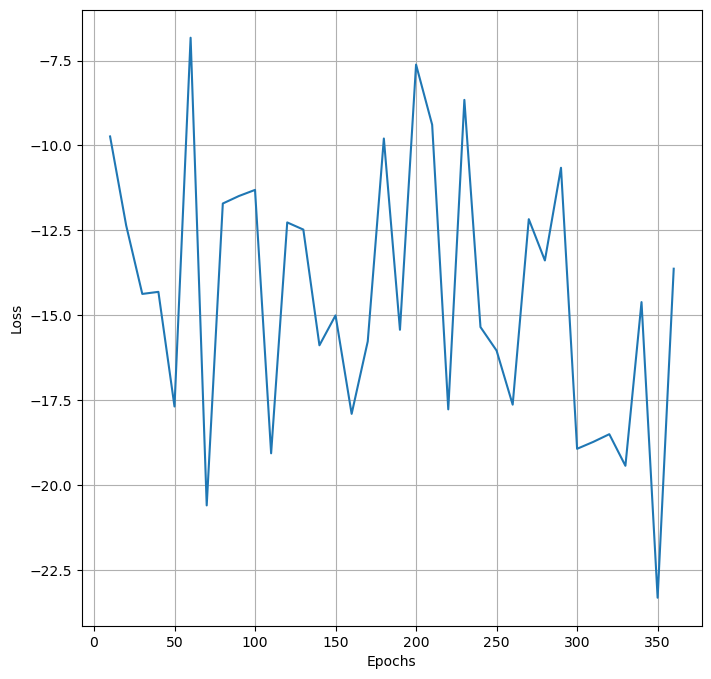

In [1260]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

In [1261]:
loss = jnp.load('scores/R'+str(N)+'/s2/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  70


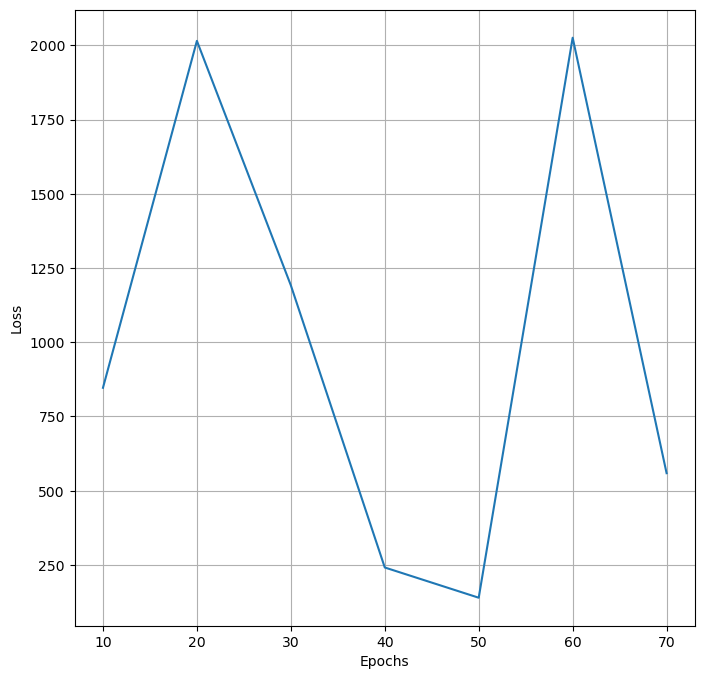

In [1262]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [1263]:
xs = pd.read_csv('Data/R'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/R'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

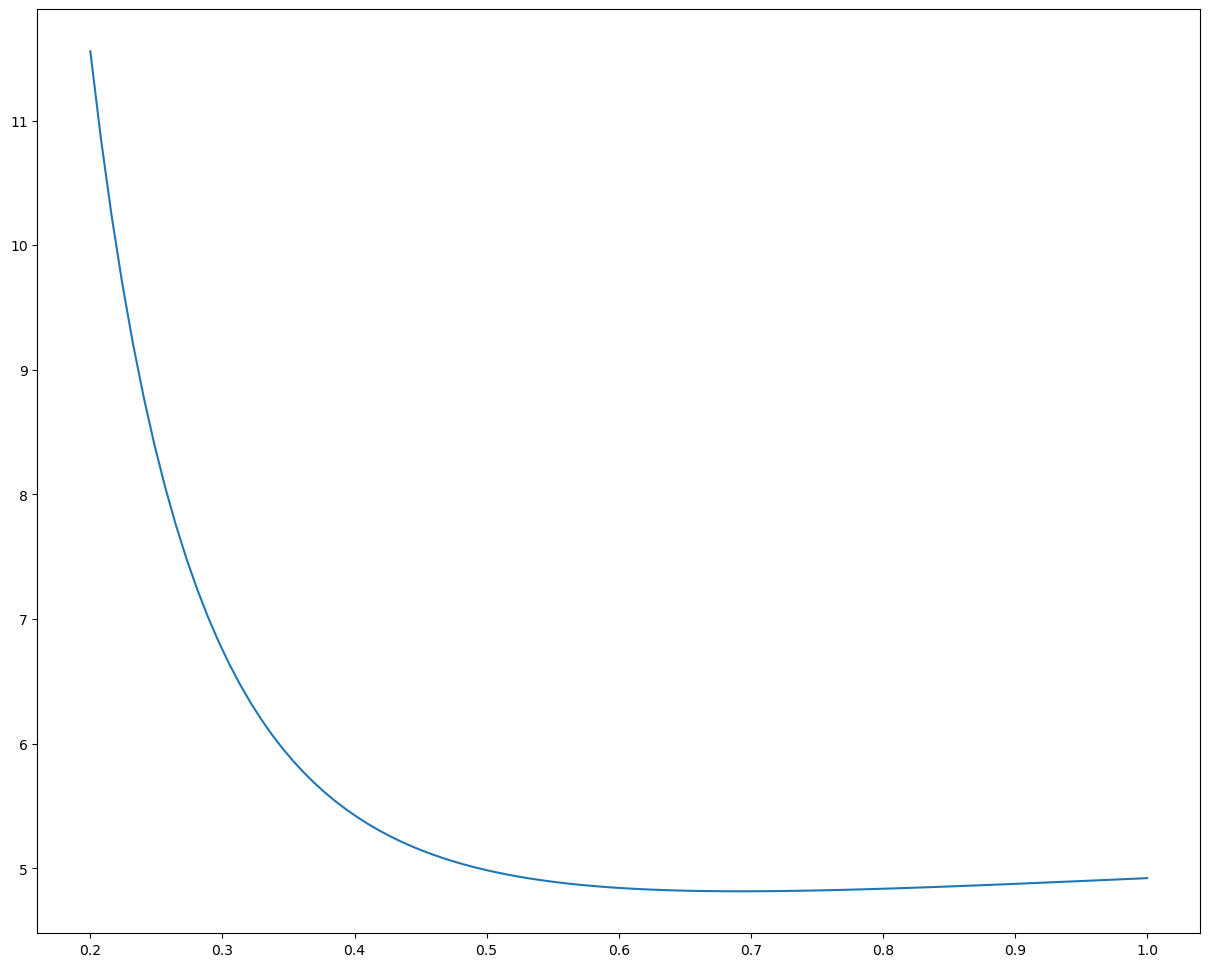

In [1264]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

In [1241]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                    step_size=0.01, max_iter=1000)

In [679]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.155812e+01 | T: ((Array([0.01136593, 0.09555456], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 1.042644e+01 | T: ((Array([0.00212493, 0.08565386], dtype=float32), Array(0.21992828, dtype=float32)), Array([0.], dtype=float32))
Final 1 | T: 1.042644e+01 | T: (Array([0.00212493, 0.08565386], dtype=float32), Array(0.21992828, dtype=float32))
Step 0 | T: 1.155812e+01 | T: ((Array([0.01136593, 0.09555456], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 1.042644e+01 | T: ((Array([0.00212493, 0.08565386], dtype=float32), Array(0.21992828, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 9.465787e+00 | T: ((Array([-0.0053882 ,  0.07591895], dtype=float32), Array(0.22974522, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 8.647336e+00 | T: ((Array([-0.01034314,  0.06641454], dtype=float32), Array(0.23941696, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 7.946887e+00

Step 55 | T: 2.574970e+00 | T: ((Array([-0.00011561,  0.00142795], dtype=float32), Array(0.48529682, dtype=float32)), Array([0.], dtype=float32))
Step 56 | T: 2.565113e+00 | T: ((Array([-0.0003367 ,  0.00194029], dtype=float32), Array(0.48727754, dtype=float32)), Array([0.], dtype=float32))
Step 57 | T: 2.555630e+00 | T: ((Array([-0.00050336,  0.00239471], dtype=float32), Array(0.48922145, dtype=float32)), Array([0.], dtype=float32))
Step 58 | T: 2.546501e+00 | T: ((Array([-0.00061332,  0.00279325], dtype=float32), Array(0.49113026, dtype=float32)), Array([0.], dtype=float32))
Step 59 | T: 2.537703e+00 | T: ((Array([-0.000667  ,  0.00313814], dtype=float32), Array(0.4930055, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 2.529217e+00 | T: ((Array([-0.00066722,  0.0034318 ], dtype=float32), Array(0.49484867, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 2.521026e+00 | T: ((Array([-0.00061887,  0.00367683], dtype=float32), Array(0.49666113, dtype=float32)), Array([

In [1242]:
mu_opt, T_opt = M.mlxt_hk(X_obs)

In [1243]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[0][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -0.0202 0.0059 )
T = 1.0000


In [1096]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgex[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.0005 0.0003 )
T = 0.5509


In [1097]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_opt[0]), ")")
print(f"T = {T_opt:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -0.0020 -0.0167 -0.0325 0.0214 0.0249 -0.0179 -0.0031 0.0078 0.0194 -0.0090 -0.0114 -0.0111 0.0276 -0.0282 0.0010 -0.0050 -0.0120 0.0215 0.0094 -0.0232 )
T = 0.5007


In [1098]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[0]-mu_sm[0][-1])/N:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt):.5f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[0]-mu_bridgex[-1])/N:.5f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt):.5f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.00190 
 -T error = 0.00283


TypeError: sub got incompatible shapes for broadcasting: (20,), (2,).

## Timing Score

In [129]:
dims = [2,3,5,10]
time_score = []
time_bridge = []

for N in dims:
    M = Euclidean(N=N)
    jstoch.Brownian_coords(M)
    jstat.diffusion_mean(M)
    x0 = (jnp.zeros(N), jnp.zeros(1))
    
    file_path = 'scores/R'+str(N)+'/s1_'+ loss_type + '/'
    state = model_loader.load_model(file_path)

    file_path_s2 = 'scores/R'+str(N)+'/s2/'
    state_s2 = model_loader.load_model(file_path_s2)
    if N<10:
        layers = [50,100,100,50]
    elif N<50:
        layers = [50,100,200,200,100,50]
    else:
        layers = [50,100,200,400,400,200,100,50]
    s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
    s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                    dim=M.dim, r = max(M.dim//2,1))(x))
    rng_key = jax.random.PRNGKey(2712)
    def grady_log(x,y,t):

        return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

    def gradt_log(x,y,t):

        s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
        s2_val = ggrady_log(x,y,t)

        div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())

        return 0.5*(jnp.dot(s1_val, s1_val)+div)

    def ggrady_log_ad(x,y,t):

        ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)

        return ggrad

    def ggrady_log_score(x,y,t):

        ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[0],y[0],t)))

        return ggrad

    if s2_approximation:
        ggrady_log = ggrady_log_score
    else:
        ggrady_log = ggrady_log_ad
        
    xs = pd.read_csv('Data/R'+str(N)+'/xs.csv', header=None)
    charts = pd.read_csv('Data/R'+str(N)+'/chart.csv', header=None)
    X_obs = (jnp.array(xs.values), jnp.array(charts.values))
    
    diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
    result = %timeit -o M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), \
                                           step_size=0.01, max_iter=100)
    time_score.append(result)
    result = %timeit -o M.diffusion_mean(X_obs,num_steps=100, N=1)
    time_bridge.append(result)

using M.Exp for Logarithm
231 ms ± 4.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Step 0 | T: 1.190953e+01 | T: ((Array([-0.18854065, -0.00813   ], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 1.072831e+01 | T: ((Array([-0.17860703, -0.00201511], dtype=float32), Array(0.2199275, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 9.722255e+00 | T: ((Array([-0.1687803 ,  0.00415572], dtype=float32), Array(0.22974214, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 8.864707e+00 | T: ((Array([-0.15909755,  0.00704197], dtype=float32), Array(0.23940943, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 8.130839e+00 | T: ((Array([-0.14959241,  0.00662608], dtype=float32), Array(0.24890064, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 7.500125e+00 | T: ((Array([-0.1402947 ,  0.00432054], dtype=float32), Array(0.25819233, dtype=float32)), Array([0.], dtype=float32))
Step 6 | T: 6.956180e+00 | T: ((Array(

Step 57 | T: 2.564610e+00 | T: ((Array([0.01340547, 0.00070815], dtype=float32), Array(0.48740524, dtype=float32)), Array([0.], dtype=float32))
Step 58 | T: 2.555373e+00 | T: ((Array([0.01314836, 0.00051395], dtype=float32), Array(0.48929903, dtype=float32)), Array([0.], dtype=float32))
Step 59 | T: 2.546467e+00 | T: ((Array([0.0128732 , 0.00033038], dtype=float32), Array(0.49115995, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 2.537874e+00 | T: ((Array([0.01258256, 0.00017649], dtype=float32), Array(0.49298942, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 2.529575e+00 | T: ((Array([1.2278834e-02, 6.6372282e-05], dtype=float32), Array(0.49478883, dtype=float32)), Array([0.], dtype=float32))
Step 62 | T: 2.521555e+00 | T: ((Array([1.1964234e-02, 8.0347090e-06], dtype=float32), Array(0.4965594, dtype=float32)), Array([0.], dtype=float32))
Step 63 | T: 2.513799e+00 | T: ((Array([1.1640803e-02, 3.1023474e-06], dtype=float32), Array(0.4983024, dtype=float32)), Arra

Step 17 | T: 4.035003e+00 | T: ((Array([-0.05100773,  0.00417425], dtype=float32), Array(0.3507486, dtype=float32)), Array([0.], dtype=float32))
Step 18 | T: 3.913647e+00 | T: ((Array([-0.04561154,  0.00385993], dtype=float32), Array(0.3568723, dtype=float32)), Array([0.], dtype=float32))
Step 19 | T: 3.804269e+00 | T: ((Array([-0.04052204,  0.00311494], dtype=float32), Array(0.3627737, dtype=float32)), Array([0.], dtype=float32))
Step 20 | T: 3.705415e+00 | T: ((Array([-0.03573229,  0.00208747], dtype=float32), Array(0.36846, dtype=float32)), Array([0.], dtype=float32))
Step 21 | T: 3.615835e+00 | T: ((Array([-0.03123453,  0.00094146], dtype=float32), Array(0.3739387, dtype=float32)), Array([0.], dtype=float32))
Step 22 | T: 3.534453e+00 | T: ((Array([-0.02702029, -0.00016455], dtype=float32), Array(0.37921745, dtype=float32)), Array([0.], dtype=float32))
Step 23 | T: 3.460329e+00 | T: ((Array([-0.02308058, -0.00109554], dtype=float32), Array(0.38430384, dtype=float32)), Array([0.], d

Step 76 | T: 2.431945e+00 | T: ((Array([0.00730829, 0.00052128], dtype=float32), Array(0.5188814, dtype=float32)), Array([0.], dtype=float32))
Step 77 | T: 2.426808e+00 | T: ((Array([0.00700097, 0.00044345], dtype=float32), Array(0.52033067, dtype=float32)), Array([0.], dtype=float32))
Step 78 | T: 2.421803e+00 | T: ((Array([0.0067006 , 0.00037331], dtype=float32), Array(0.52176374, dtype=float32)), Array([0.], dtype=float32))
Step 79 | T: 2.416926e+00 | T: ((Array([0.00640754, 0.00031795], dtype=float32), Array(0.52318114, dtype=float32)), Array([0.], dtype=float32))
Step 80 | T: 2.412172e+00 | T: ((Array([0.00612207, 0.00028214], dtype=float32), Array(0.5245833, dtype=float32)), Array([0.], dtype=float32))
Step 81 | T: 2.407536e+00 | T: ((Array([0.00584444, 0.00026804], dtype=float32), Array(0.5259706, dtype=float32)), Array([0.], dtype=float32))
Step 82 | T: 2.403014e+00 | T: ((Array([0.00557484, 0.0002752 ], dtype=float32), Array(0.5273434, dtype=float32)), Array([0.], dtype=float3

Step 33 | T: 2.980602e+00 | T: ((Array([0.00338815, 0.00188909], dtype=float32), Array(0.4262241, dtype=float32)), Array([0.], dtype=float32))
Step 34 | T: 2.949691e+00 | T: ((Array([0.00496336, 0.00211622], dtype=float32), Array(0.42967382, dtype=float32)), Array([0.], dtype=float32))
Step 35 | T: 2.920789e+00 | T: ((Array([0.00638267, 0.00213702], dtype=float32), Array(0.43301347, dtype=float32)), Array([0.], dtype=float32))
Step 36 | T: 2.893714e+00 | T: ((Array([0.00765516, 0.00196851], dtype=float32), Array(0.43624857, dtype=float32)), Array([0.], dtype=float32))
Step 37 | T: 2.868307e+00 | T: ((Array([0.00878964, 0.00164702], dtype=float32), Array(0.43938434, dtype=float32)), Array([0.], dtype=float32))
Step 38 | T: 2.844423e+00 | T: ((Array([0.00979463, 0.00122225], dtype=float32), Array(0.4424258, dtype=float32)), Array([0.], dtype=float32))
Step 39 | T: 2.821935e+00 | T: ((Array([0.01067836, 0.00075049], dtype=float32), Array(0.44537768, dtype=float32)), Array([0.], dtype=floa

Step 90 | T: 2.370494e+00 | T: ((Array([0.0037173 , 0.00055905], dtype=float32), Array(0.5378457, dtype=float32)), Array([0.], dtype=float32))
Step 91 | T: 2.366838e+00 | T: ((Array([0.00352244, 0.00055727], dtype=float32), Array(0.53910285, dtype=float32)), Array([0.], dtype=float32))
Step 92 | T: 2.363262e+00 | T: ((Array([0.00333562, 0.00054324], dtype=float32), Array(0.54034853, dtype=float32)), Array([0.], dtype=float32))
Step 93 | T: 2.359766e+00 | T: ((Array([0.00315672, 0.0005197 ], dtype=float32), Array(0.54158294, dtype=float32)), Array([0.], dtype=float32))
Step 94 | T: 2.356346e+00 | T: ((Array([0.00298559, 0.00049018], dtype=float32), Array(0.54280627, dtype=float32)), Array([0.], dtype=float32))
Step 95 | T: 2.353001e+00 | T: ((Array([0.00282208, 0.00045858], dtype=float32), Array(0.54401875, dtype=float32)), Array([0.], dtype=float32))
Step 96 | T: 2.349727e+00 | T: ((Array([0.00266601, 0.00042867], dtype=float32), Array(0.54522055, dtype=float32)), Array([0.], dtype=flo

Step 47 | T: 2.680533e+00 | T: ((Array([ 0.01426842, -0.00015123], dtype=float32), Array(0.4662687, dtype=float32)), Array([0.], dtype=float32))
Step 48 | T: 2.666548e+00 | T: ((Array([0.0143802 , 0.00014522], dtype=float32), Array(0.46859366, dtype=float32)), Array([0.], dtype=float32))
Step 49 | T: 2.653195e+00 | T: ((Array([0.0144361 , 0.00044741], dtype=float32), Array(0.4708653, dtype=float32)), Array([0.], dtype=float32))
Step 50 | T: 2.640429e+00 | T: ((Array([0.01444104, 0.00072195], dtype=float32), Array(0.47308627, dtype=float32)), Array([0.], dtype=float32))
Step 51 | T: 2.628213e+00 | T: ((Array([0.01439964, 0.00094153], dtype=float32), Array(0.475259, dtype=float32)), Array([0.], dtype=float32))
Step 52 | T: 2.616509e+00 | T: ((Array([0.01431627, 0.00108726], dtype=float32), Array(0.47738588, dtype=float32)), Array([0.], dtype=float32))
Step 53 | T: 2.605286e+00 | T: ((Array([0.01419505, 0.00115004], dtype=float32), Array(0.47946912, dtype=float32)), Array([0.], dtype=floa

Step 5 | T: 7.500125e+00 | T: ((Array([-0.1402947 ,  0.00432054], dtype=float32), Array(0.25819233, dtype=float32)), Array([0.], dtype=float32))
Step 6 | T: 6.956180e+00 | T: ((Array([-0.13123041,  0.00126469], dtype=float32), Array(0.26726595, dtype=float32)), Array([0.], dtype=float32))
Step 7 | T: 6.485485e+00 | T: ((Array([-0.12242181, -0.00163689], dtype=float32), Array(0.2761073, dtype=float32)), Array([0.], dtype=float32))
Step 8 | T: 6.076708e+00 | T: ((Array([-0.11388758, -0.0037074 ], dtype=float32), Array(0.284706, dtype=float32)), Array([0.], dtype=float32))
Step 9 | T: 5.720333e+00 | T: ((Array([-0.10564299, -0.00462384], dtype=float32), Array(0.29305488, dtype=float32)), Array([0.], dtype=float32))
Step 10 | T: 5.408418e+00 | T: ((Array([-0.09770017, -0.00441812], dtype=float32), Array(0.3011496, dtype=float32)), Array([0.], dtype=float32))
Step 11 | T: 5.134396e+00 | T: ((Array([-0.09006823, -0.00333683], dtype=float32), Array(0.30898827, dtype=float32)), Array([0.], dty

Step 62 | T: 2.521555e+00 | T: ((Array([1.1964234e-02, 8.0347090e-06], dtype=float32), Array(0.4965594, dtype=float32)), Array([0.], dtype=float32))
Step 63 | T: 2.513799e+00 | T: ((Array([1.1640803e-02, 3.1023474e-06], dtype=float32), Array(0.4983024, dtype=float32)), Array([0.], dtype=float32))
Step 64 | T: 2.506295e+00 | T: ((Array([1.1310428e-02, 4.7201425e-05], dtype=float32), Array(0.5000189, dtype=float32)), Array([0.], dtype=float32))
Step 65 | T: 2.499028e+00 | T: ((Array([0.01097485, 0.00013098], dtype=float32), Array(0.50171, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 2.491988e+00 | T: ((Array([0.01063565, 0.00024161], dtype=float32), Array(0.50337666, dtype=float32)), Array([0.], dtype=float32))
Step 67 | T: 2.485163e+00 | T: ((Array([0.0102943 , 0.00036445], dtype=float32), Array(0.50501984, dtype=float32)), Array([0.], dtype=float32))
Step 68 | T: 2.478543e+00 | T: ((Array([0.00995213, 0.0004849 ], dtype=float32), Array(0.50664043, dtype=float32)), Array([0

Step 19 | T: 3.804269e+00 | T: ((Array([-0.04052204,  0.00311494], dtype=float32), Array(0.3627737, dtype=float32)), Array([0.], dtype=float32))
Step 20 | T: 3.705415e+00 | T: ((Array([-0.03573229,  0.00208747], dtype=float32), Array(0.36846, dtype=float32)), Array([0.], dtype=float32))
Step 21 | T: 3.615835e+00 | T: ((Array([-0.03123453,  0.00094146], dtype=float32), Array(0.3739387, dtype=float32)), Array([0.], dtype=float32))
Step 22 | T: 3.534453e+00 | T: ((Array([-0.02702029, -0.00016455], dtype=float32), Array(0.37921745, dtype=float32)), Array([0.], dtype=float32))
Step 23 | T: 3.460329e+00 | T: ((Array([-0.02308058, -0.00109554], dtype=float32), Array(0.38430384, dtype=float32)), Array([0.], dtype=float32))
Step 24 | T: 3.392645e+00 | T: ((Array([-0.01940599, -0.00175375], dtype=float32), Array(0.38920557, dtype=float32)), Array([0.], dtype=float32))
Step 25 | T: 3.330687e+00 | T: ((Array([-0.01598674, -0.00208645], dtype=float32), Array(0.3939303, dtype=float32)), Array([0.], 

Step 78 | T: 2.421803e+00 | T: ((Array([0.0067006 , 0.00037331], dtype=float32), Array(0.52176374, dtype=float32)), Array([0.], dtype=float32))
Step 79 | T: 2.416926e+00 | T: ((Array([0.00640754, 0.00031795], dtype=float32), Array(0.52318114, dtype=float32)), Array([0.], dtype=float32))
Step 80 | T: 2.412172e+00 | T: ((Array([0.00612207, 0.00028214], dtype=float32), Array(0.5245833, dtype=float32)), Array([0.], dtype=float32))
Step 81 | T: 2.407536e+00 | T: ((Array([0.00584444, 0.00026804], dtype=float32), Array(0.5259706, dtype=float32)), Array([0.], dtype=float32))
Step 82 | T: 2.403014e+00 | T: ((Array([0.00557484, 0.0002752 ], dtype=float32), Array(0.5273434, dtype=float32)), Array([0.], dtype=float32))
Step 83 | T: 2.398602e+00 | T: ((Array([0.00531343, 0.00030083], dtype=float32), Array(0.5287021, dtype=float32)), Array([0.], dtype=float32))
Step 84 | T: 2.394296e+00 | T: ((Array([0.0050603 , 0.00034034], dtype=float32), Array(0.53004706, dtype=float32)), Array([0.], dtype=float3

Step 36 | T: 2.893714e+00 | T: ((Array([0.00765516, 0.00196851], dtype=float32), Array(0.43624857, dtype=float32)), Array([0.], dtype=float32))
Step 37 | T: 2.868307e+00 | T: ((Array([0.00878964, 0.00164702], dtype=float32), Array(0.43938434, dtype=float32)), Array([0.], dtype=float32))
Step 38 | T: 2.844423e+00 | T: ((Array([0.00979463, 0.00122225], dtype=float32), Array(0.4424258, dtype=float32)), Array([0.], dtype=float32))
Step 39 | T: 2.821935e+00 | T: ((Array([0.01067836, 0.00075049], dtype=float32), Array(0.44537768, dtype=float32)), Array([0.], dtype=float32))
Step 40 | T: 2.800728e+00 | T: ((Array([0.01144875, 0.0002879 ], dtype=float32), Array(0.44824454, dtype=float32)), Array([0.], dtype=float32))
Step 41 | T: 2.780698e+00 | T: ((Array([ 0.01211341, -0.00011562], dtype=float32), Array(0.45103073, dtype=float32)), Array([0.], dtype=float32))
Step 42 | T: 2.761750e+00 | T: ((Array([ 0.01267964, -0.00042128], dtype=float32), Array(0.4537403, dtype=float32)), Array([0.], dtype=

Step 94 | T: 2.356346e+00 | T: ((Array([0.00298559, 0.00049018], dtype=float32), Array(0.54280627, dtype=float32)), Array([0.], dtype=float32))
Step 95 | T: 2.353001e+00 | T: ((Array([0.00282208, 0.00045858], dtype=float32), Array(0.54401875, dtype=float32)), Array([0.], dtype=float32))
Step 96 | T: 2.349727e+00 | T: ((Array([0.00266601, 0.00042867], dtype=float32), Array(0.54522055, dtype=float32)), Array([0.], dtype=float32))
Step 97 | T: 2.346524e+00 | T: ((Array([0.00251723, 0.00040366], dtype=float32), Array(0.54641193, dtype=float32)), Array([0.], dtype=float32))
Step 98 | T: 2.343388e+00 | T: ((Array([0.00237553, 0.00038593], dtype=float32), Array(0.547593, dtype=float32)), Array([0.], dtype=float32))
Step 99 | T: 2.340318e+00 | T: ((Array([0.00224073, 0.00037679], dtype=float32), Array(0.54876393, dtype=float32)), Array([0.], dtype=float32))
Final 99 | T: 2.340318e+00 | T: (Array([0.00224073, 0.00037679], dtype=float32), Array(0.54876393, dtype=float32))
Step 0 | T: 1.190953e+0

Step 50 | T: 2.640429e+00 | T: ((Array([0.01444104, 0.00072195], dtype=float32), Array(0.47308627, dtype=float32)), Array([0.], dtype=float32))
Step 51 | T: 2.628213e+00 | T: ((Array([0.01439964, 0.00094153], dtype=float32), Array(0.475259, dtype=float32)), Array([0.], dtype=float32))
Step 52 | T: 2.616509e+00 | T: ((Array([0.01431627, 0.00108726], dtype=float32), Array(0.47738588, dtype=float32)), Array([0.], dtype=float32))
Step 53 | T: 2.605286e+00 | T: ((Array([0.01419505, 0.00115004], dtype=float32), Array(0.47946912, dtype=float32)), Array([0.], dtype=float32))
Step 54 | T: 2.594510e+00 | T: ((Array([0.01403985, 0.00113062], dtype=float32), Array(0.48151076, dtype=float32)), Array([0.], dtype=float32))
Step 55 | T: 2.584155e+00 | T: ((Array([0.01385429, 0.00103864], dtype=float32), Array(0.4835128, dtype=float32)), Array([0.], dtype=float32))
Step 56 | T: 2.574196e+00 | T: ((Array([0.01364177, 0.00089074], dtype=float32), Array(0.48547703, dtype=float32)), Array([0.], dtype=float

Step 5 | T: 1.129177e+01 | T: ((Array([-0.03450034, -0.01447822,  0.16372806], dtype=float32), Array(0.25819436, dtype=float32)), Array([0.], dtype=float32))
Step 6 | T: 1.047629e+01 | T: ((Array([-0.03998747, -0.01587556,  0.15455584], dtype=float32), Array(0.26726988, dtype=float32)), Array([0.], dtype=float32))
Step 7 | T: 9.769897e+00 | T: ((Array([-0.04423513, -0.01824704,  0.14560695], dtype=float32), Array(0.27611384, dtype=float32)), Array([0.], dtype=float32))
Step 8 | T: 9.155590e+00 | T: ((Array([-0.04728118, -0.02117358,  0.13689704], dtype=float32), Array(0.28471577, dtype=float32)), Array([0.], dtype=float32))
Step 9 | T: 8.619303e+00 | T: ((Array([-0.04921742, -0.0243137 ,  0.12843885], dtype=float32), Array(0.2930685, dtype=float32)), Array([0.], dtype=float32))
Step 10 | T: 8.149367e+00 | T: ((Array([-0.0501666 , -0.02738693,  0.12024249], dtype=float32), Array(0.30116755, dtype=float32)), Array([0.], dtype=float32))
Step 11 | T: 7.736075e+00 | T: ((Array([-0.05026415,

Step 58 | T: 3.830266e+00 | T: ((Array([-0.03035497, -0.02653276, -0.02757793], dtype=float32), Array(0.4891726, dtype=float32)), Array([0.], dtype=float32))
Step 59 | T: 3.816989e+00 | T: ((Array([-0.03015052, -0.02651012, -0.02794858], dtype=float32), Array(0.49102646, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 3.804178e+00 | T: ((Array([-0.0299163 , -0.02654009, -0.02828421], dtype=float32), Array(0.492849, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 3.791806e+00 | T: ((Array([-0.02965961, -0.02661651, -0.02858718], dtype=float32), Array(0.49464154, dtype=float32)), Array([0.], dtype=float32))
Step 62 | T: 3.779851e+00 | T: ((Array([-0.02938753, -0.02673171, -0.02885974], dtype=float32), Array(0.49640542, dtype=float32)), Array([0.], dtype=float32))
Step 63 | T: 3.768291e+00 | T: ((Array([-0.02910676, -0.02687699, -0.02910398], dtype=float32), Array(0.49814183, dtype=float32)), Array([0.], dtype=float32))
Step 64 | T: 3.757104e+00 | T: ((Array([-0.028823

Step 10 | T: 8.149367e+00 | T: ((Array([-0.0501666 , -0.02738693,  0.12024249], dtype=float32), Array(0.30116755, dtype=float32)), Array([0.], dtype=float32))
Step 11 | T: 7.736075e+00 | T: ((Array([-0.05026415, -0.03016967,  0.11231559], dtype=float32), Array(0.3090109, dtype=float32)), Array([0.], dtype=float32))
Step 12 | T: 7.371307e+00 | T: ((Array([-0.04964633, -0.03249747,  0.10466359], dtype=float32), Array(0.31659847, dtype=float32)), Array([0.], dtype=float32))
Step 13 | T: 7.048257e+00 | T: ((Array([-0.04844361, -0.03426696,  0.09728998], dtype=float32), Array(0.32393193, dtype=float32)), Array([0.], dtype=float32))
Step 14 | T: 6.761204e+00 | T: ((Array([-0.04677754, -0.0354329 ,  0.09019646], dtype=float32), Array(0.33101425, dtype=float32)), Array([0.], dtype=float32))
Step 15 | T: 6.505322e+00 | T: ((Array([-0.04475956, -0.03600001,  0.08338315], dtype=float32), Array(0.3378496, dtype=float32)), Array([0.], dtype=float32))
Step 16 | T: 6.276533e+00 | T: ((Array([-0.04249

Step 64 | T: 3.757104e+00 | T: ((Array([-0.02882361, -0.02704312, -0.0293219 ], dtype=float32), Array(0.49985188, dtype=float32)), Array([0.], dtype=float32))
Step 65 | T: 3.746272e+00 | T: ((Array([-0.02854381, -0.02722078, -0.02951537], dtype=float32), Array(0.5015366, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 3.735777e+00 | T: ((Array([-0.02827254, -0.02740096, -0.02968617], dtype=float32), Array(0.5031971, dtype=float32)), Array([0.], dtype=float32))
Step 67 | T: 3.725603e+00 | T: ((Array([-0.02801432, -0.02757539, -0.02983594], dtype=float32), Array(0.5048342, dtype=float32)), Array([0.], dtype=float32))
Step 68 | T: 3.715734e+00 | T: ((Array([-0.02777299, -0.0277368 , -0.02996626], dtype=float32), Array(0.5064488, dtype=float32)), Array([0.], dtype=float32))
Step 69 | T: 3.706156e+00 | T: ((Array([-0.02755175, -0.02787918, -0.0300786 ], dtype=float32), Array(0.5080418, dtype=float32)), Array([0.], dtype=float32))
Step 70 | T: 3.696855e+00 | T: ((Array([-0.02735306

Step 15 | T: 6.505322e+00 | T: ((Array([-0.04475956, -0.03600001,  0.08338315], dtype=float32), Array(0.3378496, dtype=float32)), Array([0.], dtype=float32))
Step 16 | T: 6.276533e+00 | T: ((Array([-0.04249084, -0.03601164,  0.07684878], dtype=float32), Array(0.34444302, dtype=float32)), Array([0.], dtype=float32))
Step 17 | T: 6.071374e+00 | T: ((Array([-0.04006242, -0.03553814,  0.07059091], dtype=float32), Array(0.35080037, dtype=float32)), Array([0.], dtype=float32))
Step 18 | T: 5.886896e+00 | T: ((Array([-0.03755551, -0.03466668,  0.064606  ], dtype=float32), Array(0.35692805, dtype=float32)), Array([0.], dtype=float32))
Step 19 | T: 5.720573e+00 | T: ((Array([-0.03504171, -0.03349309,  0.05888964], dtype=float32), Array(0.36283296, dtype=float32)), Array([0.], dtype=float32))
Step 20 | T: 5.570233e+00 | T: ((Array([-0.03258324, -0.0321155 ,  0.05343663], dtype=float32), Array(0.36852226, dtype=float32)), Array([0.], dtype=float32))
Step 21 | T: 5.433999e+00 | T: ((Array([-0.0302

Step 67 | T: 3.725603e+00 | T: ((Array([-0.02801432, -0.02757539, -0.02983594], dtype=float32), Array(0.5048342, dtype=float32)), Array([0.], dtype=float32))
Step 68 | T: 3.715734e+00 | T: ((Array([-0.02777299, -0.0277368 , -0.02996626], dtype=float32), Array(0.5064488, dtype=float32)), Array([0.], dtype=float32))
Step 69 | T: 3.706156e+00 | T: ((Array([-0.02755175, -0.02787918, -0.0300786 ], dtype=float32), Array(0.5080418, dtype=float32)), Array([0.], dtype=float32))
Step 70 | T: 3.696855e+00 | T: ((Array([-0.02735306, -0.02799789, -0.03017434], dtype=float32), Array(0.50961393, dtype=float32)), Array([0.], dtype=float32))
Step 71 | T: 3.687819e+00 | T: ((Array([-0.02717874, -0.02808982, -0.03025476], dtype=float32), Array(0.511166, dtype=float32)), Array([0.], dtype=float32))
Step 72 | T: 3.679036e+00 | T: ((Array([-0.02702997, -0.02815331, -0.0303211 ], dtype=float32), Array(0.5126986, dtype=float32)), Array([0.], dtype=float32))
Step 73 | T: 3.670495e+00 | T: ((Array([-0.0269073 ,

Step 18 | T: 5.886896e+00 | T: ((Array([-0.03755551, -0.03466668,  0.064606  ], dtype=float32), Array(0.35692805, dtype=float32)), Array([0.], dtype=float32))
Step 19 | T: 5.720573e+00 | T: ((Array([-0.03504171, -0.03349309,  0.05888964], dtype=float32), Array(0.36283296, dtype=float32)), Array([0.], dtype=float32))
Step 20 | T: 5.570233e+00 | T: ((Array([-0.03258324, -0.0321155 ,  0.05343663], dtype=float32), Array(0.36852226, dtype=float32)), Array([0.], dtype=float32))
Step 21 | T: 5.433999e+00 | T: ((Array([-0.03023312, -0.03062949,  0.04824114], dtype=float32), Array(0.37400338, dtype=float32)), Array([0.], dtype=float32))
Step 22 | T: 5.310242e+00 | T: ((Array([-0.02803535, -0.02912412,  0.04329678], dtype=float32), Array(0.3792839, dtype=float32)), Array([0.], dtype=float32))
Step 23 | T: 5.197545e+00 | T: ((Array([-0.02602522, -0.02767879,  0.03859673], dtype=float32), Array(0.3843715, dtype=float32)), Array([0.], dtype=float32))
Step 24 | T: 5.094671e+00 | T: ((Array([-0.02422

Step 70 | T: 3.696855e+00 | T: ((Array([-0.02735306, -0.02799789, -0.03017434], dtype=float32), Array(0.50961393, dtype=float32)), Array([0.], dtype=float32))
Step 71 | T: 3.687819e+00 | T: ((Array([-0.02717874, -0.02808982, -0.03025476], dtype=float32), Array(0.511166, dtype=float32)), Array([0.], dtype=float32))
Step 72 | T: 3.679036e+00 | T: ((Array([-0.02702997, -0.02815331, -0.0303211 ], dtype=float32), Array(0.5126986, dtype=float32)), Array([0.], dtype=float32))
Step 73 | T: 3.670495e+00 | T: ((Array([-0.0269073 , -0.02818814, -0.03037448], dtype=float32), Array(0.5142124, dtype=float32)), Array([0.], dtype=float32))
Step 74 | T: 3.662186e+00 | T: ((Array([-0.02681074, -0.02819542, -0.03041598], dtype=float32), Array(0.5157081, dtype=float32)), Array([0.], dtype=float32))
Step 75 | T: 3.654098e+00 | T: ((Array([-0.02673975, -0.02817736, -0.03044659], dtype=float32), Array(0.51718616, dtype=float32)), Array([0.], dtype=float32))
Step 76 | T: 3.646225e+00 | T: ((Array([-0.02669337

Step 21 | T: 5.433999e+00 | T: ((Array([-0.03023312, -0.03062949,  0.04824114], dtype=float32), Array(0.37400338, dtype=float32)), Array([0.], dtype=float32))
Step 22 | T: 5.310242e+00 | T: ((Array([-0.02803535, -0.02912412,  0.04329678], dtype=float32), Array(0.3792839, dtype=float32)), Array([0.], dtype=float32))
Step 23 | T: 5.197545e+00 | T: ((Array([-0.02602522, -0.02767879,  0.03859673], dtype=float32), Array(0.3843715, dtype=float32)), Array([0.], dtype=float32))
Step 24 | T: 5.094671e+00 | T: ((Array([-0.02422959, -0.02636071,  0.03413381], dtype=float32), Array(0.3892738, dtype=float32)), Array([0.], dtype=float32))
Step 25 | T: 5.000537e+00 | T: ((Array([-0.02266739, -0.02522319,  0.0299006 ], dtype=float32), Array(0.39399844, dtype=float32)), Array([0.], dtype=float32))
Step 26 | T: 4.914195e+00 | T: ((Array([-0.02135016, -0.0243046 ,  0.02588944], dtype=float32), Array(0.39855298, dtype=float32)), Array([0.], dtype=float32))
Step 27 | T: 4.834811e+00 | T: ((Array([-0.020282

Step 73 | T: 3.670495e+00 | T: ((Array([-0.0269073 , -0.02818814, -0.03037448], dtype=float32), Array(0.5142124, dtype=float32)), Array([0.], dtype=float32))
Step 74 | T: 3.662186e+00 | T: ((Array([-0.02681074, -0.02819542, -0.03041598], dtype=float32), Array(0.5157081, dtype=float32)), Array([0.], dtype=float32))
Step 75 | T: 3.654098e+00 | T: ((Array([-0.02673975, -0.02817736, -0.03044659], dtype=float32), Array(0.51718616, dtype=float32)), Array([0.], dtype=float32))
Step 76 | T: 3.646225e+00 | T: ((Array([-0.02669337, -0.02813714, -0.03046725], dtype=float32), Array(0.5186472, dtype=float32)), Array([0.], dtype=float32))
Step 77 | T: 3.638555e+00 | T: ((Array([-0.02667022, -0.02807862, -0.03047884], dtype=float32), Array(0.52009165, dtype=float32)), Array([0.], dtype=float32))
Step 78 | T: 3.631083e+00 | T: ((Array([-0.0266686 , -0.02800616, -0.03048216], dtype=float32), Array(0.5215201, dtype=float32)), Array([0.], dtype=float32))
Step 79 | T: 3.623800e+00 | T: ((Array([-0.0266865

Step 25 | T: 5.000537e+00 | T: ((Array([-0.02266739, -0.02522319,  0.0299006 ], dtype=float32), Array(0.39399844, dtype=float32)), Array([0.], dtype=float32))
Step 26 | T: 4.914195e+00 | T: ((Array([-0.02135016, -0.0243046 ,  0.02588944], dtype=float32), Array(0.39855298, dtype=float32)), Array([0.], dtype=float32))
Step 27 | T: 4.834811e+00 | T: ((Array([-0.02028264, -0.02362831,  0.02209256], dtype=float32), Array(0.4029448, dtype=float32)), Array([0.], dtype=float32))
Step 28 | T: 4.761660e+00 | T: ((Array([-0.01946355, -0.02320324,  0.01850209], dtype=float32), Array(0.40718117, dtype=float32)), Array([0.], dtype=float32))
Step 29 | T: 4.694101e+00 | T: ((Array([-0.01888627, -0.02302519,  0.01511017], dtype=float32), Array(0.41126916, dtype=float32)), Array([0.], dtype=float32))
Step 30 | T: 4.631569e+00 | T: ((Array([-0.01853968, -0.02307862,  0.0119089 ], dtype=float32), Array(0.41521564, dtype=float32)), Array([0.], dtype=float32))
Step 31 | T: 4.573576e+00 | T: ((Array([-0.0184

Step 77 | T: 3.638555e+00 | T: ((Array([-0.02667022, -0.02807862, -0.03047884], dtype=float32), Array(0.52009165, dtype=float32)), Array([0.], dtype=float32))
Step 78 | T: 3.631083e+00 | T: ((Array([-0.0266686 , -0.02800616, -0.03048216], dtype=float32), Array(0.5215201, dtype=float32)), Array([0.], dtype=float32))
Step 79 | T: 3.623800e+00 | T: ((Array([-0.02668654, -0.02792433, -0.03047798], dtype=float32), Array(0.52293295, dtype=float32)), Array([0.], dtype=float32))
Step 80 | T: 3.616698e+00 | T: ((Array([-0.02672186, -0.02783769, -0.030467  ], dtype=float32), Array(0.5243307, dtype=float32)), Array([0.], dtype=float32))
Step 81 | T: 3.609772e+00 | T: ((Array([-0.02677223, -0.02775063, -0.0304499 ], dtype=float32), Array(0.5257136, dtype=float32)), Array([0.], dtype=float32))
Step 82 | T: 3.603015e+00 | T: ((Array([-0.02683526, -0.02766713, -0.03042728], dtype=float32), Array(0.5270822, dtype=float32)), Array([0.], dtype=float32))
Step 83 | T: 3.596421e+00 | T: ((Array([-0.0269085

Step 28 | T: 4.761660e+00 | T: ((Array([-0.01946355, -0.02320324,  0.01850209], dtype=float32), Array(0.40718117, dtype=float32)), Array([0.], dtype=float32))
Step 29 | T: 4.694101e+00 | T: ((Array([-0.01888627, -0.02302519,  0.01511017], dtype=float32), Array(0.41126916, dtype=float32)), Array([0.], dtype=float32))
Step 30 | T: 4.631569e+00 | T: ((Array([-0.01853968, -0.02307862,  0.0119089 ], dtype=float32), Array(0.41521564, dtype=float32)), Array([0.], dtype=float32))
Step 31 | T: 4.573576e+00 | T: ((Array([-0.0184089 , -0.02333867,  0.00889048], dtype=float32), Array(0.4190273, dtype=float32)), Array([0.], dtype=float32))
Step 32 | T: 4.519680e+00 | T: ((Array([-0.01847603, -0.02377348,  0.00604715], dtype=float32), Array(0.4227106, dtype=float32)), Array([0.], dtype=float32))
Step 33 | T: 4.469498e+00 | T: ((Array([-0.0187209 , -0.02434635,  0.00337131], dtype=float32), Array(0.42627174, dtype=float32)), Array([0.], dtype=float32))
Step 34 | T: 4.422689e+00 | T: ((Array([-0.01912

Step 81 | T: 3.609772e+00 | T: ((Array([-0.02677223, -0.02775063, -0.0304499 ], dtype=float32), Array(0.5257136, dtype=float32)), Array([0.], dtype=float32))
Step 82 | T: 3.603015e+00 | T: ((Array([-0.02683526, -0.02766713, -0.03042728], dtype=float32), Array(0.5270822, dtype=float32)), Array([0.], dtype=float32))
Step 83 | T: 3.596421e+00 | T: ((Array([-0.02690852, -0.02759063, -0.03039972], dtype=float32), Array(0.52843684, dtype=float32)), Array([0.], dtype=float32))
Step 84 | T: 3.589985e+00 | T: ((Array([-0.02698957, -0.02752397, -0.03036774], dtype=float32), Array(0.5297778, dtype=float32)), Array([0.], dtype=float32))
Step 85 | T: 3.583700e+00 | T: ((Array([-0.0270761 , -0.02746925, -0.03033184], dtype=float32), Array(0.53110546, dtype=float32)), Array([0.], dtype=float32))
Step 86 | T: 3.577563e+00 | T: ((Array([-0.02716585, -0.02742785, -0.03029249], dtype=float32), Array(0.5324201, dtype=float32)), Array([0.], dtype=float32))
Step 87 | T: 3.571568e+00 | T: ((Array([-0.0272567

Step 32 | T: 4.519680e+00 | T: ((Array([-0.01847603, -0.02377348,  0.00604715], dtype=float32), Array(0.4227106, dtype=float32)), Array([0.], dtype=float32))
Step 33 | T: 4.469498e+00 | T: ((Array([-0.0187209 , -0.02434635,  0.00337131], dtype=float32), Array(0.42627174, dtype=float32)), Array([0.], dtype=float32))
Step 34 | T: 4.422689e+00 | T: ((Array([-0.01912171, -0.02501799,  0.00085544], dtype=float32), Array(0.4297167, dtype=float32)), Array([0.], dtype=float32))
Step 35 | T: 4.378948e+00 | T: ((Array([-0.01965568, -0.0257485 , -0.00150777], dtype=float32), Array(0.43305123, dtype=float32)), Array([0.], dtype=float32))
Step 36 | T: 4.338003e+00 | T: ((Array([-0.02029959, -0.0264992 , -0.00372549], dtype=float32), Array(0.43628085, dtype=float32)), Array([0.], dtype=float32))
Step 37 | T: 4.299614e+00 | T: ((Array([-0.02103029, -0.02723423, -0.00580469], dtype=float32), Array(0.43941078, dtype=float32)), Array([0.], dtype=float32))
Step 38 | T: 4.263560e+00 | T: ((Array([-0.02182

Step 86 | T: 3.577563e+00 | T: ((Array([-0.02716585, -0.02742785, -0.03029249], dtype=float32), Array(0.5324201, dtype=float32)), Array([0.], dtype=float32))
Step 87 | T: 3.571568e+00 | T: ((Array([-0.02725674, -0.0274004 , -0.03025009], dtype=float32), Array(0.53372204, dtype=float32)), Array([0.], dtype=float32))
Step 88 | T: 3.565710e+00 | T: ((Array([-0.02734685, -0.02738685, -0.03020504], dtype=float32), Array(0.5350116, dtype=float32)), Array([0.], dtype=float32))
Step 89 | T: 3.559984e+00 | T: ((Array([-0.02743446, -0.02738651, -0.03015772], dtype=float32), Array(0.536289, dtype=float32)), Array([0.], dtype=float32))
Step 90 | T: 3.554389e+00 | T: ((Array([-0.02751803, -0.02739816, -0.03010844], dtype=float32), Array(0.53755444, dtype=float32)), Array([0.], dtype=float32))
Step 91 | T: 3.548918e+00 | T: ((Array([-0.02759629, -0.02742014, -0.03005751], dtype=float32), Array(0.5388083, dtype=float32)), Array([0.], dtype=float32))
Step 92 | T: 3.543568e+00 | T: ((Array([-0.02766815

Step 30 | T: 7.210713e+00 | T: ((Array([ 0.02697011, -0.0203078 ,  0.0020833 ,  0.00755823, -0.00795604],      dtype=float32), Array(0.41559824, dtype=float32)), Array([0.], dtype=float32))
Step 31 | T: 7.124547e+00 | T: ((Array([ 0.02581739, -0.01876655,  0.00252626,  0.00843573, -0.00753696],      dtype=float32), Array(0.4194184, dtype=float32)), Array([0.], dtype=float32))
Step 32 | T: 7.044481e+00 | T: ((Array([ 0.02457661, -0.01718519,  0.00275969,  0.00911034, -0.0069584 ],      dtype=float32), Array(0.42310858, dtype=float32)), Array([0.], dtype=float32))
Step 33 | T: 6.969954e+00 | T: ((Array([ 0.0232664 , -0.01558241,  0.00277375,  0.00958927, -0.00624879],      dtype=float32), Array(0.426675, dtype=float32)), Array([0.], dtype=float32))
Step 34 | T: 6.900458e+00 | T: ((Array([ 0.02190407, -0.01397514,  0.00258741,  0.0098825 , -0.00543668],      dtype=float32), Array(0.4301236, dtype=float32)), Array([0.], dtype=float32))
Step 35 | T: 6.835551e+00 | T: ((Array([ 0.02050554, -

Step 74 | T: 5.790922e+00 | T: ((Array([-1.9364342e-03,  3.1928802e-03,  1.0690212e-03,  7.5368618e-04,
        7.8858327e-05], dtype=float32), Array(0.5151824, dtype=float32)), Array([0.], dtype=float32))
Step 75 | T: 5.779522e+00 | T: ((Array([-0.00175541,  0.00294316,  0.00102157,  0.00094066,  0.00014029],      dtype=float32), Array(0.51662, dtype=float32)), Array([0.], dtype=float32))
Step 76 | T: 5.768436e+00 | T: ((Array([-0.00156884,  0.00270151,  0.00100012,  0.00111436,  0.00021935],      dtype=float32), Array(0.5180401, dtype=float32)), Array([0.], dtype=float32))
Step 77 | T: 5.757651e+00 | T: ((Array([-0.00137866,  0.00246931,  0.00100495,  0.00127307,  0.00031265],      dtype=float32), Array(0.5194433, dtype=float32)), Array([0.], dtype=float32))
Step 78 | T: 5.747155e+00 | T: ((Array([-0.00118665,  0.00224771,  0.00103301,  0.0014155 ,  0.0004168 ],      dtype=float32), Array(0.52083, dtype=float32)), Array([0.], dtype=float32))
Step 79 | T: 5.736938e+00 | T: ((Array([-0

Step 18 | T: 9.063996e+00 | T: ((Array([ 0.02541746, -0.02650416,  0.00356028, -0.01563396,  0.00590902],      dtype=float32), Array(0.35711783, dtype=float32)), Array([0.], dtype=float32))
Step 19 | T: 8.819874e+00 | T: ((Array([ 0.02722179, -0.02752476,  0.00257157, -0.01338093,  0.00343383],      dtype=float32), Array(0.3630423, dtype=float32)), Array([0.], dtype=float32))
Step 20 | T: 8.598917e+00 | T: ((Array([ 0.0286257 , -0.0281521 ,  0.00146817, -0.01104387,  0.00112315],      dtype=float32), Array(0.36875108, dtype=float32)), Array([0.], dtype=float32))
Step 21 | T: 8.398413e+00 | T: ((Array([ 0.02965854, -0.02842247,  0.00042388, -0.0086801 , -0.00097828],      dtype=float32), Array(0.37425143, dtype=float32)), Array([0.], dtype=float32))
Step 22 | T: 8.216010e+00 | T: ((Array([ 0.03034991, -0.02837168, -0.00041684, -0.00634016, -0.00283675],      dtype=float32), Array(0.37955073, dtype=float32)), Array([0.], dtype=float32))
Step 23 | T: 8.049664e+00 | T: ((Array([ 0.03072922

Step 64 | T: 5.925692e+00 | T: ((Array([-0.00291485,  0.00567395,  0.00124371, -0.00118281,  0.0009987 ],      dtype=float32), Array(0.49970144, dtype=float32)), Array([0.], dtype=float32))
Step 65 | T: 5.910231e+00 | T: ((Array([-0.00292615,  0.00546795,  0.0013577 , -0.00104366,  0.00076244],      dtype=float32), Array(0.5013514, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 5.895271e+00 | T: ((Array([-0.00290526,  0.005244  ,  0.00144071, -0.00088003,  0.00055763],      dtype=float32), Array(0.5029764, dtype=float32)), Array([0.], dtype=float32))
Step 67 | T: 5.880785e+00 | T: ((Array([-0.00285531,  0.0050057 ,  0.00148528, -0.00069692,  0.00038587],      dtype=float32), Array(0.5045774, dtype=float32)), Array([0.], dtype=float32))
Step 68 | T: 5.866750e+00 | T: ((Array([-0.00277935,  0.00475644,  0.00148944, -0.0004992 ,  0.00024792],      dtype=float32), Array(0.5061553, dtype=float32)), Array([0.], dtype=float32))
Step 69 | T: 5.853147e+00 | T: ((Array([-0.00268036,  

Step 8 | T: 1.383794e+01 | T: ((Array([-0.01979586,  0.0123068 , -0.00268194, -0.01613971,  0.0213631 ],      dtype=float32), Array(0.28474772, dtype=float32)), Array([0.], dtype=float32))
Step 9 | T: 1.305543e+01 | T: ((Array([-0.01285198,  0.00576632, -0.00323365, -0.01929519,  0.02234734],      dtype=float32), Array(0.2931106, dtype=float32)), Array([0.], dtype=float32))
Step 10 | T: 1.236991e+01 | T: ((Array([-0.00644951, -0.00016386, -0.00273189, -0.02147867,  0.02237891],      dtype=float32), Array(0.3012214, dtype=float32)), Array([0.], dtype=float32))
Step 11 | T: 1.176695e+01 | T: ((Array([-0.00059923, -0.00547641, -0.00147238, -0.02278019,  0.02162442],      dtype=float32), Array(0.309078, dtype=float32)), Array([0.], dtype=float32))
Step 12 | T: 1.123460e+01 | T: ((Array([ 0.00469589, -0.01017387,  0.00017975, -0.02330089,  0.02024155],      dtype=float32), Array(0.31668025, dtype=float32)), Array([0.], dtype=float32))
Step 13 | T: 1.076293e+01 | T: ((Array([ 0.00943997, -0.

Step 53 | T: 6.138115e+00 | T: ((Array([0.00022092, 0.00558116, 0.00156986, 0.0001846 , 0.00429675],      dtype=float32), Array(0.47955868, dtype=float32)), Array([0.], dtype=float32))
Step 54 | T: 6.114828e+00 | T: ((Array([-0.00034465,  0.00584752,  0.00136699, -0.00021844,  0.0040772 ],      dtype=float32), Array(0.4815675, dtype=float32)), Array([0.], dtype=float32))
Step 55 | T: 6.092489e+00 | T: ((Array([-0.00084674,  0.00604938,  0.00116146, -0.00056104,  0.00381511],      dtype=float32), Array(0.48353574, dtype=float32)), Array([0.], dtype=float32))
Step 56 | T: 6.071037e+00 | T: ((Array([-0.00128734,  0.00619088,  0.00097876, -0.00084304,  0.00352009],      dtype=float32), Array(0.4854653, dtype=float32)), Array([0.], dtype=float32))
Step 57 | T: 6.050421e+00 | T: ((Array([-0.00166877,  0.0062763 ,  0.00083927, -0.00106528,  0.00320158],      dtype=float32), Array(0.4873579, dtype=float32)), Array([0.], dtype=float32))
Step 58 | T: 6.030587e+00 | T: ((Array([-0.00199354,  0.00

Step 98 | T: 5.584281e+00 | T: ((Array([0.00149779, 0.00043316, 0.00118744, 0.00138666, 0.0015112 ],      dtype=float32), Array(0.54568464, dtype=float32)), Array([0.], dtype=float32))
Step 99 | T: 5.577975e+00 | T: ((Array([0.00154649, 0.00044747, 0.00121063, 0.001329  , 0.00147726],      dtype=float32), Array(0.5468051, dtype=float32)), Array([0.], dtype=float32))
Final 99 | T: 5.577975e+00 | T: (Array([0.00154649, 0.00044747, 0.00121063, 0.001329  , 0.00147726],      dtype=float32), Array(0.5468051, dtype=float32))
Step 0 | T: 2.670123e+01 | T: ((Array([-0.09077686,  0.08215044, -0.006413  ,  0.04333053, -0.02968899],      dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 2.408207e+01 | T: ((Array([-0.08087856,  0.07226217, -0.00157764,  0.03352656, -0.01995495],      dtype=float32), Array(0.21992788, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 2.185810e+01 | T: ((Array([-0.07115047,  0.06256288,  0.00390205,  0.024081  , -0.0107

Step 42 | T: 6.480698e+00 | T: ((Array([ 0.01077329, -0.00245833,  0.0001604 ,  0.007296  ,  0.00172052],      dtype=float32), Array(0.45411012, dtype=float32)), Array([0.], dtype=float32))
Step 43 | T: 6.440995e+00 | T: ((Array([ 0.0095082 , -0.00131385,  0.00031392,  0.00660502,  0.00240479],      dtype=float32), Array(0.45672876, dtype=float32)), Array([0.], dtype=float32))
Step 44 | T: 6.403416e+00 | T: ((Array([ 0.00829543, -0.00025138,  0.0005615 ,  0.00588698,  0.00300079],      dtype=float32), Array(0.45927677, dtype=float32)), Array([0.], dtype=float32))
Step 45 | T: 6.367795e+00 | T: ((Array([0.00713951, 0.00072721, 0.00086415, 0.00515637, 0.00350347],      dtype=float32), Array(0.4617577, dtype=float32)), Array([0.], dtype=float32))
Step 46 | T: 6.333985e+00 | T: ((Array([0.0060441 , 0.00162098, 0.00117968, 0.00442655, 0.00391033],      dtype=float32), Array(0.4641749, dtype=float32)), Array([0.], dtype=float32))
Step 47 | T: 6.301853e+00 | T: ((Array([0.00501204, 0.00242985

Step 87 | T: 5.664043e+00 | T: ((Array([0.00040148, 0.00083117, 0.00128821, 0.00192669, 0.00136138],      dtype=float32), Array(0.53264, dtype=float32)), Array([0.], dtype=float32))
Step 88 | T: 5.655910e+00 | T: ((Array([0.00054528, 0.00074075, 0.0012555 , 0.0019089 , 0.00142864],      dtype=float32), Array(0.53388435, dtype=float32)), Array([0.], dtype=float32))
Step 89 | T: 5.647972e+00 | T: ((Array([0.00068049, 0.00066294, 0.00121798, 0.00188049, 0.00148423],      dtype=float32), Array(0.5351163, dtype=float32)), Array([0.], dtype=float32))
Step 90 | T: 5.640221e+00 | T: ((Array([0.00080686, 0.00059724, 0.00118088, 0.00184296, 0.00152797],      dtype=float32), Array(0.5363361, dtype=float32)), Array([0.], dtype=float32))
Step 91 | T: 5.632650e+00 | T: ((Array([0.00092426, 0.0005431 , 0.00114889, 0.00179779, 0.00155999],      dtype=float32), Array(0.537544, dtype=float32)), Array([0.], dtype=float32))
Step 92 | T: 5.625255e+00 | T: ((Array([0.00103262, 0.00049992, 0.00112562, 0.0017

Step 31 | T: 7.124547e+00 | T: ((Array([ 0.02581739, -0.01876655,  0.00252626,  0.00843573, -0.00753696],      dtype=float32), Array(0.4194184, dtype=float32)), Array([0.], dtype=float32))
Step 32 | T: 7.044481e+00 | T: ((Array([ 0.02457661, -0.01718519,  0.00275969,  0.00911034, -0.0069584 ],      dtype=float32), Array(0.42310858, dtype=float32)), Array([0.], dtype=float32))
Step 33 | T: 6.969954e+00 | T: ((Array([ 0.0232664 , -0.01558241,  0.00277375,  0.00958927, -0.00624879],      dtype=float32), Array(0.426675, dtype=float32)), Array([0.], dtype=float32))
Step 34 | T: 6.900458e+00 | T: ((Array([ 0.02190407, -0.01397514,  0.00258741,  0.0098825 , -0.00543668],      dtype=float32), Array(0.4301236, dtype=float32)), Array([0.], dtype=float32))
Step 35 | T: 6.835551e+00 | T: ((Array([ 0.02050554, -0.01237865,  0.00224294,  0.01000232, -0.00455007],      dtype=float32), Array(0.43346012, dtype=float32)), Array([0.], dtype=float32))
Step 36 | T: 6.774834e+00 | T: ((Array([ 0.01908544, -

Step 75 | T: 5.779522e+00 | T: ((Array([-0.00175541,  0.00294316,  0.00102157,  0.00094066,  0.00014029],      dtype=float32), Array(0.51662, dtype=float32)), Array([0.], dtype=float32))
Step 76 | T: 5.768436e+00 | T: ((Array([-0.00156884,  0.00270151,  0.00100012,  0.00111436,  0.00021935],      dtype=float32), Array(0.5180401, dtype=float32)), Array([0.], dtype=float32))
Step 77 | T: 5.757651e+00 | T: ((Array([-0.00137866,  0.00246931,  0.00100495,  0.00127307,  0.00031265],      dtype=float32), Array(0.5194433, dtype=float32)), Array([0.], dtype=float32))
Step 78 | T: 5.747155e+00 | T: ((Array([-0.00118665,  0.00224771,  0.00103301,  0.0014155 ,  0.0004168 ],      dtype=float32), Array(0.52083, dtype=float32)), Array([0.], dtype=float32))
Step 79 | T: 5.736938e+00 | T: ((Array([-0.00099446,  0.00203767,  0.00107861,  0.00154076,  0.00052846],      dtype=float32), Array(0.5222007, dtype=float32)), Array([0.], dtype=float32))
Step 80 | T: 5.726987e+00 | T: ((Array([-0.00080357,  0.001

Step 20 | T: 8.598917e+00 | T: ((Array([ 0.0286257 , -0.0281521 ,  0.00146817, -0.01104387,  0.00112315],      dtype=float32), Array(0.36875108, dtype=float32)), Array([0.], dtype=float32))
Step 21 | T: 8.398413e+00 | T: ((Array([ 0.02965854, -0.02842247,  0.00042388, -0.0086801 , -0.00097828],      dtype=float32), Array(0.37425143, dtype=float32)), Array([0.], dtype=float32))
Step 22 | T: 8.216010e+00 | T: ((Array([ 0.03034991, -0.02837168, -0.00041684, -0.00634016, -0.00283675],      dtype=float32), Array(0.37955073, dtype=float32)), Array([0.], dtype=float32))
Step 23 | T: 8.049664e+00 | T: ((Array([ 0.03072922, -0.02803465, -0.00095572, -0.00406797, -0.00442894],      dtype=float32), Array(0.38465646, dtype=float32)), Array([0.], dtype=float32))
Step 24 | T: 7.897599e+00 | T: ((Array([ 0.03082543, -0.02744513, -0.00114893, -0.00190094, -0.00574128],      dtype=float32), Array(0.38957614, dtype=float32)), Array([0.], dtype=float32))
Step 25 | T: 7.758264e+00 | T: ((Array([ 0.0306667

Step 65 | T: 5.910231e+00 | T: ((Array([-0.00292615,  0.00546795,  0.0013577 , -0.00104366,  0.00076244],      dtype=float32), Array(0.5013514, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 5.895271e+00 | T: ((Array([-0.00290526,  0.005244  ,  0.00144071, -0.00088003,  0.00055763],      dtype=float32), Array(0.5029764, dtype=float32)), Array([0.], dtype=float32))
Step 67 | T: 5.880785e+00 | T: ((Array([-0.00285531,  0.0050057 ,  0.00148528, -0.00069692,  0.00038587],      dtype=float32), Array(0.5045774, dtype=float32)), Array([0.], dtype=float32))
Step 68 | T: 5.866750e+00 | T: ((Array([-0.00277935,  0.00475644,  0.00148944, -0.0004992 ,  0.00024792],      dtype=float32), Array(0.5061553, dtype=float32)), Array([0.], dtype=float32))
Step 69 | T: 5.853147e+00 | T: ((Array([-0.00268036,  0.0044994 ,  0.00145638, -0.00029151,  0.00014367],      dtype=float32), Array(0.507711, dtype=float32)), Array([0.], dtype=float32))
Step 70 | T: 5.839953e+00 | T: ((Array([-2.5612088e-03, 

Step 10 | T: 1.236991e+01 | T: ((Array([-0.00644951, -0.00016386, -0.00273189, -0.02147867,  0.02237891],      dtype=float32), Array(0.3012214, dtype=float32)), Array([0.], dtype=float32))
Step 11 | T: 1.176695e+01 | T: ((Array([-0.00059923, -0.00547641, -0.00147238, -0.02278019,  0.02162442],      dtype=float32), Array(0.309078, dtype=float32)), Array([0.], dtype=float32))
Step 12 | T: 1.123460e+01 | T: ((Array([ 0.00469589, -0.01017387,  0.00017975, -0.02330089,  0.02024155],      dtype=float32), Array(0.31668025, dtype=float32)), Array([0.], dtype=float32))
Step 13 | T: 1.076293e+01 | T: ((Array([ 0.00943997, -0.01426747,  0.00186129, -0.02314523,  0.01837513],      dtype=float32), Array(0.32402962, dtype=float32)), Array([0.], dtype=float32))
Step 14 | T: 1.034360e+01 | T: ((Array([ 0.01364327, -0.01777573,  0.00326229, -0.02241606,  0.01615613],      dtype=float32), Array(0.33112893, dtype=float32)), Array([0.], dtype=float32))
Step 15 | T: 9.969557e+00 | T: ((Array([ 0.0173213 , 

Step 54 | T: 6.114828e+00 | T: ((Array([-0.00034465,  0.00584752,  0.00136699, -0.00021844,  0.0040772 ],      dtype=float32), Array(0.4815675, dtype=float32)), Array([0.], dtype=float32))
Step 55 | T: 6.092489e+00 | T: ((Array([-0.00084674,  0.00604938,  0.00116146, -0.00056104,  0.00381511],      dtype=float32), Array(0.48353574, dtype=float32)), Array([0.], dtype=float32))
Step 56 | T: 6.071037e+00 | T: ((Array([-0.00128734,  0.00619088,  0.00097876, -0.00084304,  0.00352009],      dtype=float32), Array(0.4854653, dtype=float32)), Array([0.], dtype=float32))
Step 57 | T: 6.050421e+00 | T: ((Array([-0.00166877,  0.0062763 ,  0.00083927, -0.00106528,  0.00320158],      dtype=float32), Array(0.4873579, dtype=float32)), Array([0.], dtype=float32))
Step 58 | T: 6.030587e+00 | T: ((Array([-0.00199354,  0.00631004,  0.00075621, -0.00122951,  0.00286869],      dtype=float32), Array(0.48921528, dtype=float32)), Array([0.], dtype=float32))
Step 59 | T: 6.011491e+00 | T: ((Array([-0.00226439, 

Step 99 | T: 5.577975e+00 | T: ((Array([0.00154649, 0.00044747, 0.00121063, 0.001329  , 0.00147726],      dtype=float32), Array(0.5468051, dtype=float32)), Array([0.], dtype=float32))
Final 99 | T: 5.577975e+00 | T: (Array([0.00154649, 0.00044747, 0.00121063, 0.001329  , 0.00147726],      dtype=float32), Array(0.5468051, dtype=float32))
Step 0 | T: 2.670123e+01 | T: ((Array([-0.09077686,  0.08215044, -0.006413  ,  0.04333053, -0.02968899],      dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 2.408207e+01 | T: ((Array([-0.08087856,  0.07226217, -0.00157764,  0.03352656, -0.01995495],      dtype=float32), Array(0.21992788, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 2.185810e+01 | T: ((Array([-0.07115047,  0.06256288,  0.00390205,  0.024081  , -0.0107326 ],      dtype=float32), Array(0.22974364, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 1.996532e+01 | T: ((Array([-0.06165955,  0.05312933,  0.0067304 ,  0.01517158, -0.

Step 42 | T: 6.480698e+00 | T: ((Array([ 0.01077329, -0.00245833,  0.0001604 ,  0.007296  ,  0.00172052],      dtype=float32), Array(0.45411012, dtype=float32)), Array([0.], dtype=float32))
Step 43 | T: 6.440995e+00 | T: ((Array([ 0.0095082 , -0.00131385,  0.00031392,  0.00660502,  0.00240479],      dtype=float32), Array(0.45672876, dtype=float32)), Array([0.], dtype=float32))
Step 44 | T: 6.403416e+00 | T: ((Array([ 0.00829543, -0.00025138,  0.0005615 ,  0.00588698,  0.00300079],      dtype=float32), Array(0.45927677, dtype=float32)), Array([0.], dtype=float32))
Step 45 | T: 6.367795e+00 | T: ((Array([0.00713951, 0.00072721, 0.00086415, 0.00515637, 0.00350347],      dtype=float32), Array(0.4617577, dtype=float32)), Array([0.], dtype=float32))
Step 46 | T: 6.333985e+00 | T: ((Array([0.0060441 , 0.00162098, 0.00117968, 0.00442655, 0.00391033],      dtype=float32), Array(0.4641749, dtype=float32)), Array([0.], dtype=float32))
Step 47 | T: 6.301853e+00 | T: ((Array([0.00501204, 0.00242985

Step 85 | T: 5.680914e+00 | T: ((Array([8.9548616e-05, 1.0514037e-03, 1.3196920e-03, 1.9248000e-03,
       1.1939965e-03], dtype=float32), Array(0.53011274, dtype=float32)), Array([0.], dtype=float32))
Step 86 | T: 5.672375e+00 | T: ((Array([0.00024942, 0.00093461, 0.00131101, 0.00193244, 0.0012829 ],      dtype=float32), Array(0.53138286, dtype=float32)), Array([0.], dtype=float32))
Step 87 | T: 5.664043e+00 | T: ((Array([0.00040148, 0.00083117, 0.00128821, 0.00192669, 0.00136138],      dtype=float32), Array(0.53264, dtype=float32)), Array([0.], dtype=float32))
Step 88 | T: 5.655910e+00 | T: ((Array([0.00054528, 0.00074075, 0.0012555 , 0.0019089 , 0.00142864],      dtype=float32), Array(0.53388435, dtype=float32)), Array([0.], dtype=float32))
Step 89 | T: 5.647972e+00 | T: ((Array([0.00068049, 0.00066294, 0.00121798, 0.00188049, 0.00148423],      dtype=float32), Array(0.5351163, dtype=float32)), Array([0.], dtype=float32))
Step 90 | T: 5.640221e+00 | T: ((Array([0.00080686, 0.00059724

Step 20 | T: 1.862456e+01 | T: ((Array([-0.00730957,  0.02545472, -0.00279036,  0.01678952,  0.01203541,
       -0.00217996, -0.02942636,  0.02112245, -0.0056121 , -0.0307554 ],      dtype=float32), Array(0.3689642, dtype=float32)), Array([0.], dtype=float32))
Step 21 | T: 1.817755e+01 | T: ((Array([-0.0073449 ,  0.0247113 , -0.00192808,  0.01894034,  0.00808023,
       -0.00083326, -0.03065307,  0.01954274, -0.0033441 , -0.02987919],      dtype=float32), Array(0.3744904, dtype=float32)), Array([0.], dtype=float32))
Step 22 | T: 1.777041e+01 | T: ((Array([-0.00702775,  0.02370314, -0.00129626,  0.02074528,  0.00442991,
        0.00026649, -0.03153575,  0.01778494, -0.00126795, -0.02874886],      dtype=float32), Array(0.37981713, dtype=float32)), Array([0.], dtype=float32))
Step 23 | T: 1.739867e+01 | T: ((Array([-0.00642082,  0.0224719 , -0.00097233,  0.02222589,  0.00107323,
        0.00107665, -0.03210241,  0.01589487,  0.0005856 , -0.02740686],      dtype=float32), Array(0.3849518, 

Step 53 | T: 1.306836e+01 | T: ((Array([-0.00228129, -0.00907398, -0.00274171,  0.00348828, -0.01906712,
       -0.00157675, -0.00305485, -0.00761832, -0.00608467,  0.00329868],      dtype=float32), Array(0.48120746, dtype=float32)), Array([0.], dtype=float32))
Step 54 | T: 1.301400e+01 | T: ((Array([-0.00212203, -0.00889359, -0.00258712,  0.00264929, -0.01854347,
       -0.00168054, -0.00242395, -0.00712373, -0.00602053,  0.00306111],      dtype=float32), Array(0.48327088, dtype=float32)), Array([0.], dtype=float32))
Step 55 | T: 1.296179e+01 | T: ((Array([-0.00202765, -0.00866769, -0.00248634,  0.00185434, -0.01800724,
       -0.00183784, -0.00185425, -0.0066222 , -0.00589864,  0.00278257],      dtype=float32), Array(0.48529398, dtype=float32)), Array([0.], dtype=float32))
Step 56 | T: 1.291160e+01 | T: ((Array([-0.00199855, -0.0084028 , -0.00244842,  0.00110422, -0.0174617 ,
       -0.00203543, -0.00134428, -0.0061206 , -0.00572678,  0.00246977],      dtype=float32), Array(0.4872786

Step 86 | T: 1.196706e+01 | T: ((Array([-0.00284561, -0.00168651, -0.00284044, -0.00501377, -0.00483233,
       -0.00283524, -0.00159523, -0.00210223, -0.00260247, -0.00407982],      dtype=float32), Array(0.5349056, dtype=float32)), Array([0.], dtype=float32))
Step 87 | T: 1.194699e+01 | T: ((Array([-0.00289776, -0.00171176, -0.00281119, -0.00492171, -0.00462488,
       -0.00289388, -0.00174811, -0.00221566, -0.00269712, -0.00403641],      dtype=float32), Array(0.53622055, dtype=float32)), Array([0.], dtype=float32))
Step 88 | T: 1.192739e+01 | T: ((Array([-0.00294326, -0.00174695, -0.00279352, -0.00482573, -0.00443009,
       -0.00294582, -0.00189481, -0.00232669, -0.00278647, -0.00398442],      dtype=float32), Array(0.5375228, dtype=float32)), Array([0.], dtype=float32))
Step 89 | T: 1.190823e+01 | T: ((Array([-0.00297961, -0.00179077, -0.00278887, -0.00472678, -0.00424754,
       -0.00298888, -0.00203484, -0.00243415, -0.00286916, -0.00392524],      dtype=float32), Array(0.53881264,

Step 18 | T: 1.965966e+01 | T: ((Array([-0.00604982,  0.02596986, -0.00464798,  0.01136664,  0.02090213,
       -0.00532747, -0.02582896,  0.02354585, -0.01055308, -0.03156382],      dtype=float32), Array(0.3572839, dtype=float32)), Array([0.], dtype=float32))
Step 19 | T: 1.911661e+01 | T: ((Array([-0.00688128,  0.02588952, -0.00375266,  0.01427174,  0.0163061 ,
       -0.00370746, -0.02782756,  0.02247456, -0.00803177, -0.03133263],      dtype=float32), Array(0.3632311, dtype=float32)), Array([0.], dtype=float32))
Step 20 | T: 1.862456e+01 | T: ((Array([-0.00730957,  0.02545472, -0.00279036,  0.01678952,  0.01203541,
       -0.00217996, -0.02942636,  0.02112245, -0.0056121 , -0.0307554 ],      dtype=float32), Array(0.3689642, dtype=float32)), Array([0.], dtype=float32))
Step 21 | T: 1.817755e+01 | T: ((Array([-0.0073449 ,  0.0247113 , -0.00192808,  0.01894034,  0.00808023,
       -0.00083326, -0.03065307,  0.01954274, -0.0033441 , -0.02987919],      dtype=float32), Array(0.3744904, d

Step 50 | T: 1.324585e+01 | T: ((Array([-0.00307186, -0.00927538, -0.00331347,  0.00625573, -0.02052566,
       -0.00168693, -0.00532399, -0.00898329, -0.00586203,  0.0036958 ],      dtype=float32), Array(0.4747547, dtype=float32)), Array([0.], dtype=float32))
Step 51 | T: 1.318412e+01 | T: ((Array([-0.00276867, -0.00927159, -0.00313236,  0.00529331, -0.02006221,
       -0.00157285, -0.00450436, -0.00855636, -0.00601148,  0.00362311],      dtype=float32), Array(0.47695154, dtype=float32)), Array([0.], dtype=float32))
Step 52 | T: 1.312501e+01 | T: ((Array([-0.00250021, -0.00920222, -0.00293193,  0.00437015, -0.01957465,
       -0.00153792, -0.00374808, -0.00809854, -0.00608383,  0.00348836],      dtype=float32), Array(0.47910172, dtype=float32)), Array([0.], dtype=float32))
Step 53 | T: 1.306836e+01 | T: ((Array([-0.00228129, -0.00907398, -0.00274171,  0.00348828, -0.01906712,
       -0.00157675, -0.00305485, -0.00761832, -0.00608467,  0.00329868],      dtype=float32), Array(0.48120746

Step 82 | T: 1.205232e+01 | T: ((Array([-0.00264347, -0.00171133, -0.00298462, -0.00532122, -0.00579644,
       -0.00259725, -0.00093568, -0.00165351, -0.00220694, -0.00413934],      dtype=float32), Array(0.5295129, dtype=float32)), Array([0.], dtype=float32))
Step 83 | T: 1.203022e+01 | T: ((Array([-0.00268476, -0.00168363, -0.00295608, -0.00525582, -0.00553452,
       -0.00264993, -0.00110614, -0.00176167, -0.00230416, -0.00414445],      dtype=float32), Array(0.53088164, dtype=float32)), Array([0.], dtype=float32))
Step 84 | T: 1.200866e+01 | T: ((Array([-0.00273507, -0.00167112, -0.00291842, -0.00518197, -0.00528676,
       -0.00270973, -0.00127348, -0.00187368, -0.002404  , -0.00413527],      dtype=float32), Array(0.53223646, dtype=float32)), Array([0.], dtype=float32))
Step 85 | T: 1.198761e+01 | T: ((Array([-0.00279009, -0.00167252, -0.00287786, -0.00510089, -0.00505282,
       -0.00277274, -0.00143679, -0.00198774, -0.00250414, -0.00411325],      dtype=float32), Array(0.5335777,

Step 14 | T: 2.249910e+01 | T: ((Array([ 0.00014784,  0.02178863, -0.00447713, -0.00448689,  0.04269909,
       -0.01039069, -0.01332071,  0.02384592, -0.02029672, -0.02803611],      dtype=float32), Array(0.33122015, dtype=float32)), Array([0.], dtype=float32))
Step 15 | T: 2.167008e+01 | T: ((Array([-0.00161434,  0.02360598, -0.00527464,  0.00014284,  0.03672529,
       -0.00959742, -0.01717197,  0.02449298, -0.01807404, -0.02968668],      dtype=float32), Array(0.33808967, dtype=float32)), Array([0.], dtype=float32))
Step 16 | T: 2.092763e+01 | T: ((Array([-0.00332693,  0.02487661, -0.00554221,  0.00431899,  0.03110465,
       -0.00839973, -0.02052587,  0.02461617, -0.01564987, -0.03079128],      dtype=float32), Array(0.34471962, dtype=float32)), Array([0.], dtype=float32))
Step 17 | T: 2.026064e+01 | T: ((Array([-0.00484218,  0.02564836, -0.00529775,  0.00805498,  0.0258324 ,
       -0.0069324 , -0.02340361,  0.02427966, -0.01311591, -0.03140009],      dtype=float32), Array(0.3511156

Step 46 | T: 1.352295e+01 | T: ((Array([-0.00421693, -0.00850489, -0.0033456 ,  0.01043999, -0.02204426,
       -0.00289105, -0.00922363, -0.01019825, -0.00442722,  0.00322625],      dtype=float32), Array(0.46545094, dtype=float32)), Array([0.], dtype=float32))
Step 47 | T: 1.344870e+01 | T: ((Array([-0.00398722, -0.00882774, -0.00347203,  0.00935088, -0.02172516,
       -0.00249404, -0.00815822, -0.00998751, -0.00491422,  0.00347122],      dtype=float32), Array(0.46785966, dtype=float32)), Array([0.], dtype=float32))
Step 48 | T: 1.337792e+01 | T: ((Array([-0.00370393, -0.0090598 , -0.003504  ,  0.00828781, -0.02136209,
       -0.00215319, -0.00715194, -0.0097083 , -0.00531563,  0.00362675],      dtype=float32), Array(0.47021133, dtype=float32)), Array([0.], dtype=float32))
Step 49 | T: 1.331038e+01 | T: ((Array([-0.00339091, -0.00920694, -0.0034457 ,  0.0072549 , -0.02096055,
       -0.00188146, -0.00620676, -0.00937037, -0.00563109,  0.00369935],      dtype=float32), Array(0.4725088

Step 78 | T: 1.214642e+01 | T: ((Array([-0.00263902, -0.00199791, -0.00292941, -0.00547092, -0.00699164,
       -0.00253008, -0.0002458 , -0.0012988 , -0.00189574, -0.00394854],      dtype=float32), Array(0.523891, dtype=float32)), Array([0.], dtype=float32))
Step 79 | T: 1.212199e+01 | T: ((Array([-0.00261102, -0.00189772, -0.00297079, -0.00545317, -0.0066702 ,
       -0.00251924, -0.00041686, -0.00137157, -0.00195647, -0.00402439],      dtype=float32), Array(0.5253193, dtype=float32)), Array([0.], dtype=float32))
Step 80 | T: 1.209818e+01 | T: ((Array([-0.00260356, -0.00181724, -0.00299443, -0.00542131, -0.006364  ,
       -0.00252853, -0.0005898 , -0.00145639, -0.00203042, -0.00408064],      dtype=float32), Array(0.5267321, dtype=float32)), Array([0.], dtype=float32))
Step 81 | T: 1.207496e+01 | T: ((Array([-0.00261524, -0.00175547, -0.00299863, -0.00537684, -0.00607283,
       -0.00255558, -0.00076318, -0.00155107, -0.00211481, -0.00411852],      dtype=float32), Array(0.5281298, dt

Step 10 | T: 2.698245e+01 | T: ((Array([ 0.00394216,  0.00820819,  0.00044897, -0.02769642,  0.07015236,
       -0.00734001,  0.00734765,  0.01476243, -0.02494291, -0.01507415],      dtype=float32), Array(0.3012628, dtype=float32)), Array([0.], dtype=float32))
Step 11 | T: 2.564923e+01 | T: ((Array([ 0.00387659,  0.0126205 , -0.00045751, -0.02118476,  0.06275847,
       -0.00916995,  0.0013742 ,  0.0181244 , -0.02466976, -0.0193451 ],      dtype=float32), Array(0.30912966, dtype=float32)), Array([0.], dtype=float32))
Step 12 | T: 2.447170e+01 | T: ((Array([ 0.00309286,  0.01633482, -0.00180547, -0.01514566,  0.05571599,
       -0.01026859, -0.00405883,  0.02072298, -0.02371476, -0.0229072 ],      dtype=float32), Array(0.31674358, dtype=float32)), Array([0.], dtype=float32))
Step 13 | T: 2.342780e+01 | T: ((Array([ 0.00178235,  0.01937887, -0.00324808, -0.00958071,  0.04902903,
       -0.010651  , -0.00895424,  0.02261035, -0.02221507, -0.0257912 ],      dtype=float32), Array(0.32410613

Step 42 | T: 1.386048e+01 | T: ((Array([-0.00421362, -0.00620705, -0.00228472,  0.01495184, -0.02275872,
       -0.00463516, -0.01401211, -0.010163  , -0.00170229,  0.0012388 ],      dtype=float32), Array(0.4551833, dtype=float32)), Array([0.], dtype=float32))
Step 43 | T: 1.376938e+01 | T: ((Array([-0.00437967, -0.00694067, -0.00256486,  0.01381273, -0.02267759,
       -0.00422453, -0.01274437, -0.01032239, -0.00248666,  0.00189655],      dtype=float32), Array(0.4578518, dtype=float32)), Array([0.], dtype=float32))
Step 44 | T: 1.368298e+01 | T: ((Array([-0.00442961, -0.00756584, -0.00286243,  0.01267665, -0.02252689,
       -0.00377944, -0.01152049, -0.01037528, -0.00320789,  0.00244416],      dtype=float32), Array(0.46045026, dtype=float32)), Array([0.], dtype=float32))
Step 45 | T: 1.360095e+01 | T: ((Array([-0.00437073, -0.00808587, -0.00313449,  0.01155038, -0.02231358,
       -0.0033267 , -0.01034551, -0.01033074, -0.00385696,  0.00288575],      dtype=float32), Array(0.4629822, 

Step 74 | T: 1.225081e+01 | T: ((Array([-0.00293313, -0.00261069, -0.00271133, -0.00536859, -0.00843258,
       -0.00278541,  0.0003863 , -0.00117349, -0.00183798, -0.00342911],      dtype=float32), Array(0.5180134, dtype=float32)), Array([0.], dtype=float32))
Step 75 | T: 1.222366e+01 | T: ((Array([-0.00283849, -0.00242463, -0.00275685, -0.00542352, -0.00804894,
       -0.00269178,  0.00023976, -0.0011754 , -0.00181968, -0.003593  ],      dtype=float32), Array(0.5195084, dtype=float32)), Array([0.], dtype=float32))
Step 76 | T: 1.219723e+01 | T: ((Array([-2.7550887e-03, -2.2607397e-03, -2.8144668e-03, -5.4577426e-03,
       -7.6809181e-03, -2.6166923e-03,  8.4276180e-05, -1.1984357e-03,
       -1.8247592e-03, -3.7337474e-03], dtype=float32), Array(0.520986, dtype=float32)), Array([0.], dtype=float32))
Step 77 | T: 1.217149e+01 | T: ((Array([-2.6875534e-03, -2.1186823e-03, -2.8749199e-03, -5.4729865e-03,
       -7.3285094e-03, -2.5624637e-03, -7.8190162e-05, -1.2403266e-03,
       -1.8

Step 6 | T: 3.448893e+01 | T: ((Array([-0.00439325, -0.01654756, -0.00425162, -0.05825076,  0.1030521 ,
        0.00453457,  0.03645424, -0.00687267, -0.01632231,  0.00927238],      dtype=float32), Array(0.2672992, dtype=float32)), Array([0.], dtype=float32))
Step 7 | T: 3.220883e+01 | T: ((Array([-0.00119602, -0.0093172 , -0.0019825 , -0.04997233,  0.09435598,
        0.00139669,  0.02843425, -0.00022893, -0.02020565,  0.00211779],      dtype=float32), Array(0.27615556, dtype=float32)), Array([0.], dtype=float32))
Step 8 | T: 3.022716e+01 | T: ((Array([ 0.00140026, -0.00276479, -0.00023363, -0.04210534,  0.08596304,
       -0.00184597,  0.02089292,  0.00560055, -0.02285619, -0.00434056],      dtype=float32), Array(0.28477255, dtype=float32)), Array([0.], dtype=float32))
Step 9 | T: 2.849782e+01 | T: ((Array([ 0.00313846,  0.00308097,  0.00059214, -0.034674  ,  0.0778906 ,
       -0.00484468,  0.01385764,  0.01059616, -0.02438817, -0.01007463],      dtype=float32), Array(0.2931431, dty

Step 39 | T: 1.416622e+01 | T: ((Array([-0.00306839, -0.00333733, -0.0019639 ,  0.01830835, -0.02250875,
       -0.0053907 , -0.01801453, -0.00896442,  0.00090466, -0.00142223],      dtype=float32), Array(0.44671932, dtype=float32)), Array([0.], dtype=float32))
Step 40 | T: 1.405845e+01 | T: ((Array([-3.5442906e-03, -4.4060750e-03, -1.9503055e-03,  1.7208332e-02,
       -2.2682283e-02, -5.2437382e-03, -1.6654560e-02, -9.4913412e-03,
        8.1977341e-06, -4.1900761e-04], dtype=float32), Array(0.44962108, dtype=float32)), Array([0.], dtype=float32))
Step 41 | T: 1.395670e+01 | T: ((Array([-0.00393208, -0.00536262, -0.00206664,  0.01608647, -0.02276288,
       -0.0049838 , -0.0153178 , -0.00988858, -0.00086611,  0.00046767],      dtype=float32), Array(0.45244104, dtype=float32)), Array([0.], dtype=float32))
Step 42 | T: 1.386048e+01 | T: ((Array([-0.00421362, -0.00620705, -0.00228472,  0.01495184, -0.02275872,
       -0.00463516, -0.01401211, -0.010163  , -0.00170229,  0.0012388 ],     

Step 71 | T: 1.233693e+01 | T: ((Array([-0.00322037, -0.00330192, -0.00271764, -0.00506195, -0.00967627,
       -0.00313492,  0.0007507 , -0.00131576, -0.00205109, -0.00279549],      dtype=float32), Array(0.51341796, dtype=float32)), Array([0.], dtype=float32))
Step 72 | T: 1.230742e+01 | T: ((Array([-0.00313131, -0.00304959, -0.00268748, -0.00518959, -0.00924642,
       -0.00301243,  0.00064405, -0.00124164, -0.0019523 , -0.00303042],      dtype=float32), Array(0.5149688, dtype=float32)), Array([0.], dtype=float32))
Step 73 | T: 1.227872e+01 | T: ((Array([-0.00303305, -0.00281906, -0.00268621, -0.00529121, -0.00883179,
       -0.00289393,  0.0005218 , -0.00119487, -0.00188166, -0.00324165],      dtype=float32), Array(0.5165004, dtype=float32)), Array([0.], dtype=float32))
Step 74 | T: 1.225081e+01 | T: ((Array([-0.00293313, -0.00261069, -0.00271133, -0.00536859, -0.00843258,
       -0.00278541,  0.0003863 , -0.00117349, -0.00183798, -0.00342911],      dtype=float32), Array(0.5180134, 

Step 3 | T: 4.373327e+01 | T: ((Array([-0.01247406, -0.04176889, -0.00639953, -0.08522049,  0.13072729,
        0.0083128 ,  0.06299163, -0.03110866,  0.00291563,  0.03436707],      dtype=float32), Array(0.23941597, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 4.017739e+01 | T: ((Array([-0.01070561, -0.03284233, -0.00735732, -0.07591422,  0.12126502,
        0.00863136,  0.05377994, -0.02239452, -0.00469455,  0.02546783],      dtype=float32), Array(0.2489133, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 3.712288e+01 | T: ((Array([-0.00775792, -0.02440995, -0.00633405, -0.06691021,  0.11203019,
        0.00713035,  0.04491728, -0.0142849 , -0.01114537,  0.01707688],      dtype=float32), Array(0.2582138, dtype=float32)), Array([0.], dtype=float32))
Step 6 | T: 3.448893e+01 | T: ((Array([-0.00439325, -0.01654756, -0.00425162, -0.05825076,  0.1030521 ,
        0.00453457,  0.03645424, -0.00687267, -0.01632231,  0.00927238],      dtype=float32), Array(0.2672992, dtyp

Step 36 | T: 1.453118e+01 | T: ((Array([-0.00141273,  0.00052213, -0.00279118,  0.02137418, -0.02134247,
       -0.00498275, -0.02213919, -0.00655517,  0.00353596, -0.00512014],      dtype=float32), Array(0.43747887, dtype=float32)), Array([0.], dtype=float32))
Step 37 | T: 1.440196e+01 | T: ((Array([-0.00196588, -0.0008697 , -0.00240459,  0.02040244, -0.02184805,
       -0.00527094, -0.02076738, -0.00749995,  0.00268954, -0.00377542],      dtype=float32), Array(0.44065288, dtype=float32)), Array([0.], dtype=float32))
Step 38 | T: 1.428053e+01 | T: ((Array([-0.00253094, -0.00215763, -0.00211851,  0.01937663, -0.02223367,
       -0.00540456, -0.01938879, -0.00830208,  0.00180515, -0.00254164],      dtype=float32), Array(0.44373143, dtype=float32)), Array([0.], dtype=float32))
Step 39 | T: 1.416622e+01 | T: ((Array([-0.00306839, -0.00333733, -0.0019639 ,  0.01830835, -0.02250875,
       -0.0053907 , -0.01801453, -0.00896442,  0.00090466, -0.00142223],      dtype=float32), Array(0.4467193

Step 68 | T: 1.243081e+01 | T: ((Array([-0.0033594 , -0.00418124, -0.0029429 , -0.00450478, -0.01105359,
       -0.00345577,  0.00095217, -0.00171875, -0.00251971, -0.00195369],      dtype=float32), Array(0.50864327, dtype=float32)), Array([0.], dtype=float32))
Step 69 | T: 1.239858e+01 | T: ((Array([-0.003341  , -0.0038689 , -0.00285338, -0.00472134, -0.0105803 ,
       -0.00336401,  0.00090736, -0.00155289, -0.00233505, -0.0022563 ],      dtype=float32), Array(0.51025593, dtype=float32)), Array([0.], dtype=float32))
Step 70 | T: 1.236731e+01 | T: ((Array([-0.00329264, -0.00357536, -0.00277497, -0.00490646, -0.01012103,
       -0.00325457,  0.00083933, -0.00141899, -0.00217865, -0.00253723],      dtype=float32), Array(0.51184726, dtype=float32)), Array([0.], dtype=float32))
Step 71 | T: 1.233693e+01 | T: ((Array([-0.00322037, -0.00330192, -0.00271764, -0.00506195, -0.00967627,
       -0.00313492,  0.0007507 , -0.00131576, -0.00205109, -0.00279549],      dtype=float32), Array(0.5134179

Step 0 | T: 5.850478e+01 | T: ((Array([ 0.00028784, -0.07062504,  0.00311671, -0.11445608,  0.160125  ,
       -0.00990549,  0.09213092, -0.05975911,  0.03052886,  0.06319657],      dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 5.276461e+01 | T: ((Array([-0.00784362, -0.06075362,  0.00110681, -0.10454521,  0.15019645,
       -0.00102004,  0.08223031, -0.04990816,  0.02077471,  0.05332784],      dtype=float32), Array(0.21992819, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 4.788899e+01 | T: ((Array([-0.01198868, -0.05110345, -0.00308993, -0.09478151,  0.14038356,
        0.00528731,  0.07249561, -0.0403188 ,  0.01148721,  0.04368557],      dtype=float32), Array(0.22974484, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 4.373327e+01 | T: ((Array([-0.01247406, -0.04176889, -0.00639953, -0.08522049,  0.13072729,
        0.0083128 ,  0.06299163, -0.03110866,  0.00291563,  0.03436707],      dtype=float32), Array(0.23941597, d

Step 32 | T: 1.514146e+01 | T: ((Array([-0.00016189,  0.00697895, -0.00420109,  0.02445785, -0.01791861,
       -0.00245434, -0.02729522, -0.00135908,  0.00606116, -0.01147534],      dtype=float32), Array(0.42372507, dtype=float32)), Array([0.], dtype=float32))
Step 33 | T: 1.497308e+01 | T: ((Array([-0.00025144,  0.00525115, -0.00399855,  0.02383592, -0.01900594,
       -0.00325188, -0.02608525, -0.00286432,  0.00560885, -0.00975837],      dtype=float32), Array(0.4273331, dtype=float32)), Array([0.], dtype=float32))
Step 34 | T: 1.481589e+01 | T: ((Array([-0.00051368,  0.00359145, -0.00365352,  0.02310472, -0.0199318 ,
       -0.0039576 , -0.02481218, -0.00423535,  0.00502038, -0.0081197 ],      dtype=float32), Array(0.4308243, dtype=float32)), Array([0.], dtype=float32))
Step 35 | T: 1.466888e+01 | T: ((Array([-0.00091426,  0.00201182, -0.00322848,  0.0222794 , -0.02070712,
       -0.00454139, -0.02349194, -0.00546667,  0.00432105, -0.00657059],      dtype=float32), Array(0.43420443,

Step 64 | T: 1.257007e+01 | T: ((Array([-0.00307882, -0.00557945, -0.00315481, -0.00328989, -0.01307272,
       -0.00351537,  0.00084368, -0.00271571, -0.00350398, -0.0005596 ],      dtype=float32), Array(0.5019624, dtype=float32)), Array([0.], dtype=float32))
Step 65 | T: 1.253359e+01 | T: ((Array([-0.00320158, -0.00521242, -0.00314802, -0.00364921, -0.01255078,
       -0.00355688,  0.00091964, -0.00241602, -0.00322664, -0.0009314 ],      dtype=float32), Array(0.50366896, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 1.249826e+01 | T: ((Array([-0.00329076, -0.00485523, -0.00310345, -0.0039704 , -0.01203963,
       -0.00355808,  0.00096113, -0.00214989, -0.0029679 , -0.00128931],      dtype=float32), Array(0.50535065, dtype=float32)), Array([0.], dtype=float32))
Step 67 | T: 1.246401e+01 | T: ((Array([-0.00334343, -0.0045107 , -0.00303083, -0.00425504, -0.01154028,
       -0.00352261,  0.00097102, -0.00191754, -0.00273133, -0.00163079],      dtype=float32), Array(0.50700843

Step 96 | T: 1.178558e+01 | T: ((Array([-0.00294415, -0.00223839, -0.00292497, -0.00401708, -0.00327591,
       -0.00299797, -0.00280486, -0.00301876, -0.00320128, -0.00341186],      dtype=float32), Array(0.54751474, dtype=float32)), Array([0.], dtype=float32))
Step 97 | T: 1.176955e+01 | T: ((Array([-0.00291332, -0.00230981, -0.00292904, -0.00392068, -0.00317561,
       -0.00296831, -0.00288374, -0.00307296, -0.00321191, -0.00333677],      dtype=float32), Array(0.54871386, dtype=float32)), Array([0.], dtype=float32))
Step 98 | T: 1.175387e+01 | T: ((Array([-0.00288262, -0.00238047, -0.00292464, -0.00382694, -0.00308364,
       -0.00293622, -0.00295503, -0.00311944, -0.00321441, -0.00326373],      dtype=float32), Array(0.54990256, dtype=float32)), Array([0.], dtype=float32))
Step 99 | T: 1.173851e+01 | T: ((Array([-0.00285417, -0.00244969, -0.00291322, -0.00373618, -0.00299957,
       -0.00290371, -0.00301892, -0.00315834, -0.00320949, -0.00319335],      dtype=float32), Array(0.551081,

Step 28 | T: 1.595119e+01 | T: ((Array([-0.00182711,  0.0142535 , -0.00305698,  0.02551966, -0.01172488,
        0.00077507, -0.03114176,  0.00579902,  0.00603061, -0.01882042],      dtype=float32), Array(0.40800345, dtype=float32)), Array([0.], dtype=float32))
Step 29 | T: 1.572551e+01 | T: ((Array([-1.1135156e-03,  1.2417999e-02, -3.6157751e-03,  2.5503537e-02,
       -1.3573621e-02,  6.4310560e-05, -3.0368507e-02,  3.8667524e-03,
        6.3580549e-03, -1.6949255e-02], dtype=float32), Array(0.41213998, dtype=float32)), Array([0.], dtype=float32))
Step 30 | T: 1.551635e+01 | T: ((Array([-0.00058803,  0.01057999, -0.00401597,  0.02530897, -0.01521415,
       -0.00074704, -0.02945591,  0.00201884,  0.00645877, -0.01508787],      dtype=float32), Array(0.41613474, dtype=float32)), Array([0.], dtype=float32))
Step 31 | T: 1.532213e+01 | T: ((Array([-0.00026995,  0.00876071, -0.00421424,  0.0249545 , -0.01665853,
       -0.00160392, -0.02842491,  0.00027228,  0.00635243, -0.01325713],     

Step 60 | T: 1.272876e+01 | T: ((Array([-0.00240346, -0.00707594, -0.00279923, -0.00144372, -0.01524282,
       -0.00294852,  0.00013749, -0.00422822, -0.00470152,  0.00100082],      dtype=float32), Array(0.49486634, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 1.268703e+01 | T: ((Array([-0.002579  , -0.00670557, -0.00293053, -0.00196903, -0.01469093,
       -0.00314406,  0.00038009, -0.0038066 , -0.00440051,  0.00060737],      dtype=float32), Array(0.49668315, dtype=float32)), Array([0.], dtype=float32))
Step 62 | T: 1.264673e+01 | T: ((Array([-0.00275804, -0.00632983, -0.00304164, -0.0024511 , -0.01414419,
       -0.00330708,  0.00057678, -0.0034125 , -0.00409637,  0.00021339],      dtype=float32), Array(0.49847063, dtype=float32)), Array([0.], dtype=float32))
Step 63 | T: 1.260776e+01 | T: ((Array([-0.00292819, -0.00595312, -0.00311896, -0.00289098, -0.0136043 ,
       -0.00343189,  0.00073036, -0.00304828, -0.00379559, -0.00017688],      dtype=float32), Array(0.50023, 

Step 92 | T: 1.185331e+01 | T: ((Array([-0.00302167, -0.00196151, -0.00283927, -0.0044207 , -0.003769  ,
       -0.00305307, -0.00241132, -0.00272554, -0.00306759, -0.00371738],      dtype=float32), Array(0.5426103, dtype=float32)), Array([0.], dtype=float32))
Step 93 | T: 1.183581e+01 | T: ((Array([-0.00301368, -0.00202757, -0.00286639, -0.00431807, -0.00363107,
       -0.00305237, -0.00252149, -0.00280994, -0.00311526, -0.00364196],      dtype=float32), Array(0.543853, dtype=float32)), Array([0.], dtype=float32))
Step 94 | T: 1.181870e+01 | T: ((Array([-0.0029967 , -0.00209639, -0.00289187, -0.00421624, -0.00350321,
       -0.0030419 , -0.0026238 , -0.00288712, -0.00315333, -0.00356528],      dtype=float32), Array(0.5450845, dtype=float32)), Array([0.], dtype=float32))
Step 95 | T: 1.180196e+01 | T: ((Array([-0.00297275, -0.00216697, -0.00291221, -0.00411574, -0.00338497,
       -0.00302317, -0.00271825, -0.00295679, -0.0031819 , -0.00348829],      dtype=float32), Array(0.546305, dty

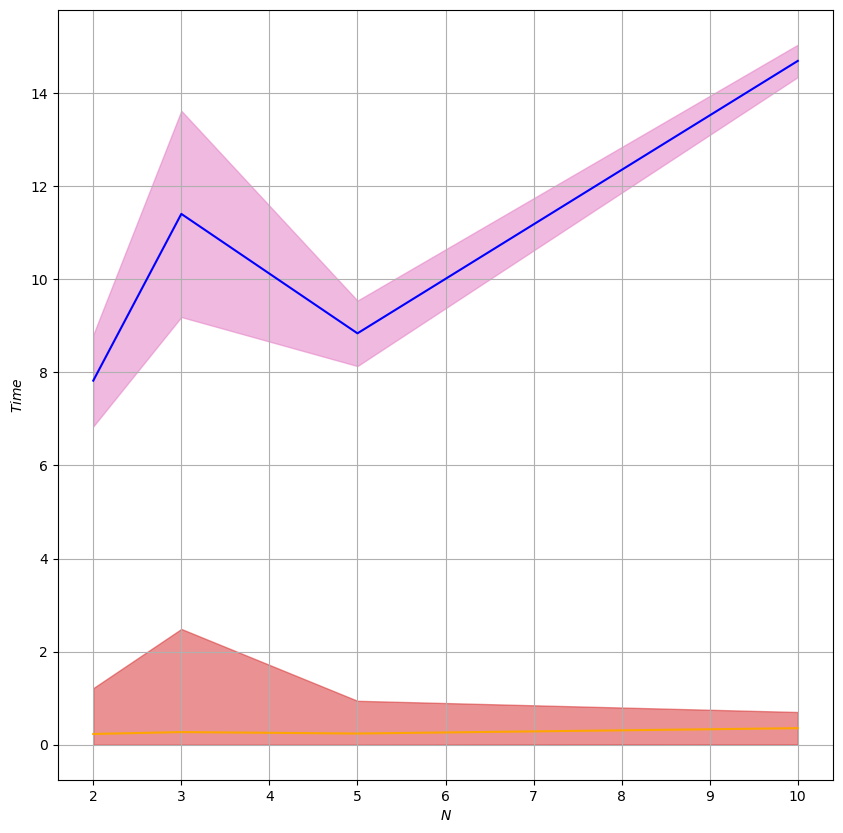

In [144]:
#Plotting time difference

rn_dims = jnp.array(dims)

rn_score_tmean = jnp.array([time.average for time in time_score])
rn_score_tstd = jnp.array([time.stdev for time in time_bridge])

rn_bridge_tmean = jnp.array([time.average for time in time_bridge])
rn_bridge_tstd = jnp.array([time.stdev for time in time_bridge])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(rn_dims, rn_score_tmean, color='orange')
ax.plot(rn_dims, bridge_tmean, color='blue')
ax.set_xlabel(f'$N$')
ax.set_ylabel(f'$Time$')
ax.grid(True)
ax.fill_between(
    rn_dims,
    jnp.maximum(rn_score_tmean - 1.96 * rn_score_tstd, jnp.zeros_like(rn_score_tmean)),
    jnp.maximum(rn_score_tmean + 1.96 * rn_score_tstd, jnp.zeros_like(rn_score_tmean)),
    color="tab:red",
    alpha=0.5,
)
ax.fill_between(
    dims,
    jnp.maximum(rn_bridge_tmean - 1.96 * rn_bridge_tstd, jnp.zeros_like(rn_bridge_tmean)),
    jnp.maximum(rn_bridge_tmean + 1.96 * rn_bridge_tstd, jnp.zeros_like(rn_bridge_tmean)),
    color="tab:pink",
    alpha=0.5,
)
ax.grid(True)



# Circle

## Defining Manifold and Loading Score

In [4]:
M = S1()
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.])

using M.Exp for Logarithm


In [5]:
file_path = 'scores/S1/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)
layers = [50,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

## Loading Loss

In [6]:
loss = jnp.load('scores/S1/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


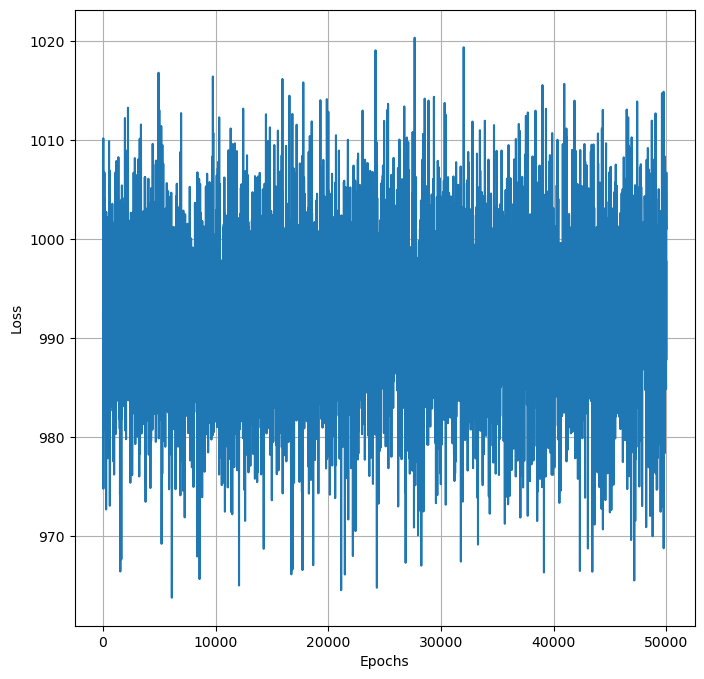

In [7]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

In [69]:
loss = jnp.load('scores/S1/s2/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

FileNotFoundError: [Errno 2] No such file or directory: 'scores/S1/s2/loss_arrays.npy'

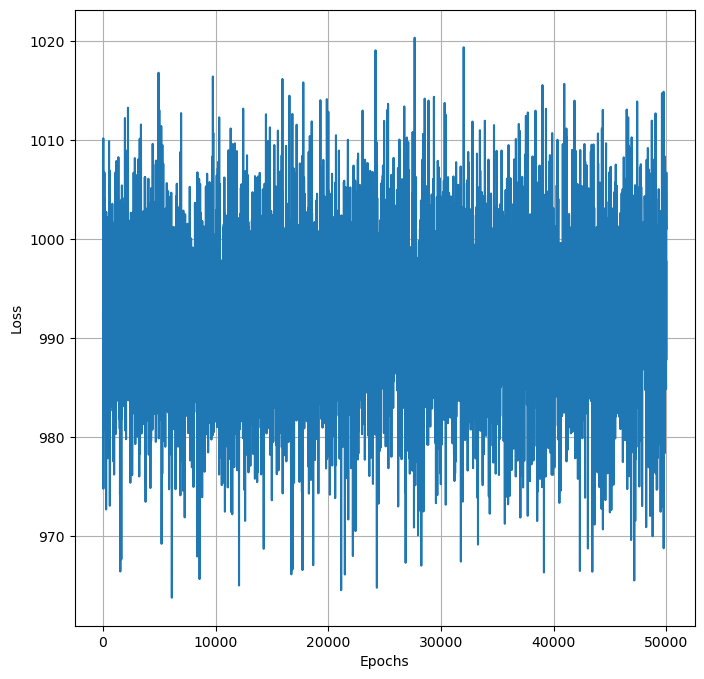

In [9]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [10]:
xs = pd.read_csv('Data/S1/xs.csv', header=None)
charts = pd.read_csv('Data/S1/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

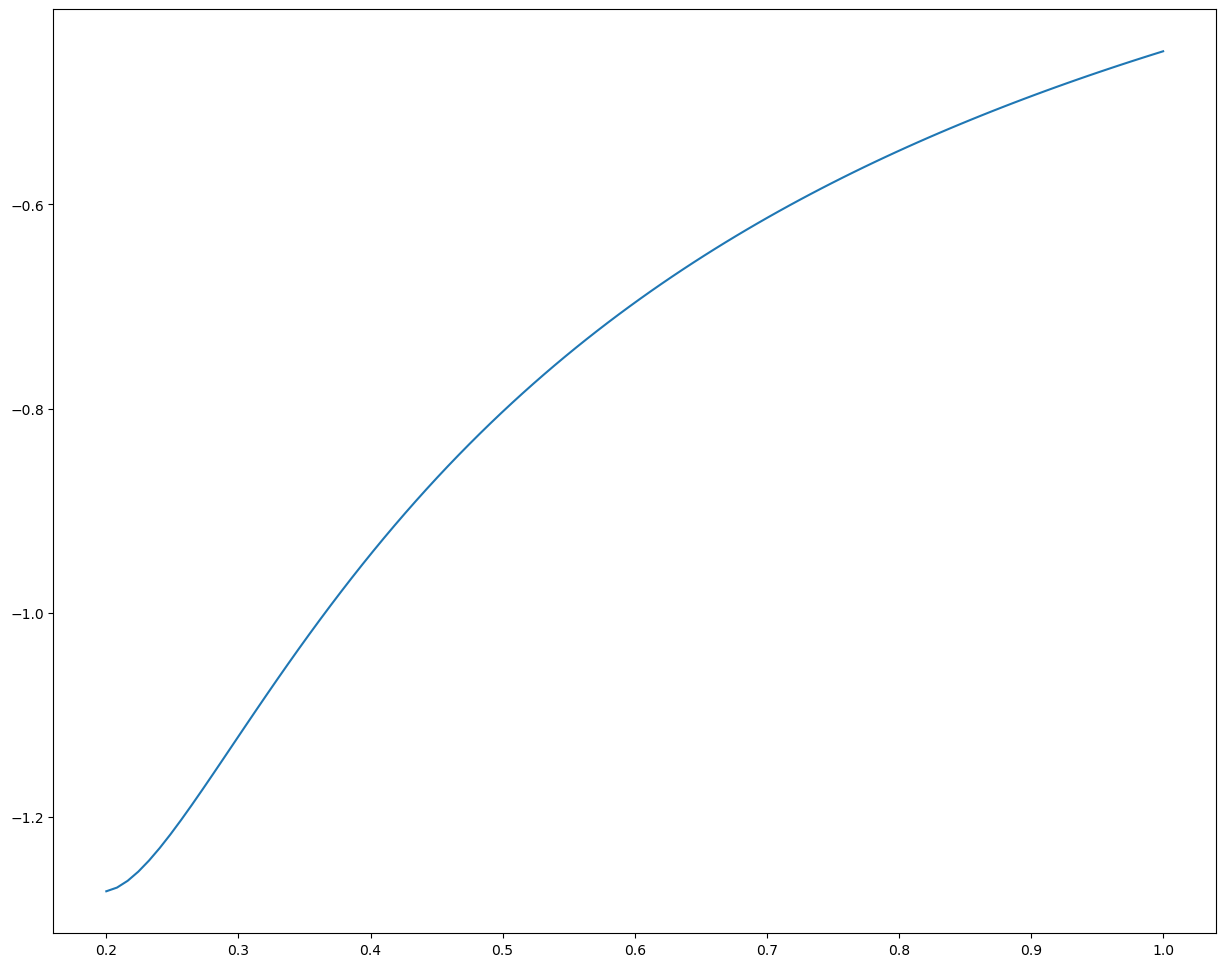

In [11]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

In [12]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[0][0]), jnp.array([0.2]), 
                                     step_size=0.01, max_iter=100)

In [13]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean((X_obs[0],X_obs[0]),num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean((X_obs[0],X_obs[0]),num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.714728e+02 | T: ((Array([-0.09553418], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 1.566660e+02 | T: ((Array([-0.08556889], dtype=float32), Array(0.21993957, dtype=float32)), Array([0.], dtype=float32))
Final 1 | T: 1.566660e+02 | T: (Array([-0.08556889], dtype=float32), Array(0.21993957, dtype=float32))
Step 0 | T: 1.714728e+02 | T: ((Array([-0.09553418], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 1.566660e+02 | T: ((Array([-0.08556889], dtype=float32), Array(0.21993957, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 1.442695e+02 | T: ((Array([-0.07565641], dtype=float32), Array(0.22978765, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 1.331197e+02 | T: ((Array([-0.06581438], dtype=float32), Array(0.23951484, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 1.240912e+02 | T: ((Array([-0.05605482], dtype=float32), Array(0.24910116, dtype=float32)), A

Step 62 | T: 3.230989e+01 | T: ((Array([0.33525652], dtype=float32), Array(0.5447885, dtype=float32)), Array([0.], dtype=float32))
Step 63 | T: 3.199137e+01 | T: ((Array([0.3403068], dtype=float32), Array(0.5475595, dtype=float32)), Array([0.], dtype=float32))
Step 64 | T: 3.168121e+01 | T: ((Array([0.345336], dtype=float32), Array(0.5503032, dtype=float32)), Array([0.], dtype=float32))
Step 65 | T: 3.150926e+01 | T: ((Array([0.35034573], dtype=float32), Array(0.55302113, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 3.127750e+01 | T: ((Array([0.3553367], dtype=float32), Array(0.5557142, dtype=float32)), Array([0.], dtype=float32))
Step 67 | T: 3.098785e+01 | T: ((Array([0.36030886], dtype=float32), Array(0.5583828, dtype=float32)), Array([0.], dtype=float32))
Step 68 | T: 3.076848e+01 | T: ((Array([0.36526296], dtype=float32), Array(0.5610279, dtype=float32)), Array([0.], dtype=float32))
Step 69 | T: 3.055449e+01 | T: ((Array([0.37019968], dtype=float32), Array(0.5636503, 

In [36]:
def gradt_log_opt(x,y,t):
    
    s1_val = M.grady_log_hk(x,y,t)
    s2_val = jacfwdx(lambda y: M.grady_log_hk(x,y,t))(y)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div).squeeze()

In [41]:
def gradt_log_opt(x,y,t):
    
    ggrad = jacfwdx(lambda y: M.grady_log_hk(x,y,t))(y)
    
    return ggrad.squeeze()

In [42]:
diffusion_mean(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t).squeeze(), s2_model = gradt_log_opt, method="Gradient")
mu_opt, T_opt, _, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[0][0]), jnp.array([0.2]))

In [57]:
mu_opt = x0
T_opt = jnp.array([0.5]).reshape(1,1)

In [58]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[0][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0179 )
T = 0.1000


In [59]:
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_sm[1][-1]):.5f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt[-1][0]):.5f}")

Score Diffusion mean: 
 -mean error = 0.01786 
 -T error = 0.40000


In [60]:
mu_bridge = M.F((mu_bridgex[-1], mu_bridgechart[-1]))

In [61]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridge), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.5124 )
T = 0.6345


In [63]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_opt[1]), ")")
print(f"T = {T_opt[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0000 )
T = 0.5000


In [64]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1]-mu_sm[1][-1]):.5f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt[-1][0]):.5f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1]-mu_bridgechart[-1]):.5f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.5f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.01786 
 -T error = 0.40000
Bridge Diffusion mean: 
 -mean error = 0.00000 
 -T error = 0.13449


In [66]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[0][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

183 ms ± 2.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
%timeit M.diffusion_mean(X_obs,num_steps=100, N=1)

Step 0 | T: 1.852988e+01 | T: ((Array([-0.23001227], dtype=float32), Array(0.20999993, dtype=float32)), Array([1., 0.], dtype=float32))
Step 1 | T: 1.651170e+01 | T: ((Array([-0.22005376], dtype=float32), Array(0.21992284, dtype=float32)), Array([1., 0.], dtype=float32))
Step 2 | T: 1.479264e+01 | T: ((Array([-0.2101603], dtype=float32), Array(0.22972557, dtype=float32)), Array([1., 0.], dtype=float32))
Step 3 | T: 1.332320e+01 | T: ((Array([-0.20035248], dtype=float32), Array(0.23937148, dtype=float32)), Array([1., 0.], dtype=float32))
Step 4 | T: 1.206231e+01 | T: ((Array([-0.19064815], dtype=float32), Array(0.24883002, dtype=float32)), Array([1., 0.], dtype=float32))
Step 5 | T: 1.097600e+01 | T: ((Array([-0.18106249], dtype=float32), Array(0.25807643, dtype=float32)), Array([1., 0.], dtype=float32))
Step 6 | T: 1.003619e+01 | T: ((Array([-0.17160816], dtype=float32), Array(0.2670912, dtype=float32)), Array([1., 0.], dtype=float32))
Step 7 | T: 9.219672e+00 | T: ((Array([-0.16229557

Step 61 | T: 1.765231e+00 | T: ((Array([0.15533094], dtype=float32), Array(0.4775787, dtype=float32)), Array([1., 0.], dtype=float32))
Step 62 | T: 1.743972e+00 | T: ((Array([0.15936193], dtype=float32), Array(0.47891006, dtype=float32)), Array([1., 0.], dtype=float32))
Step 63 | T: 1.723262e+00 | T: ((Array([0.16336693], dtype=float32), Array(0.48021078, dtype=float32)), Array([1., 0.], dtype=float32))
Step 64 | T: 1.703075e+00 | T: ((Array([0.16734692], dtype=float32), Array(0.481482, dtype=float32)), Array([1., 0.], dtype=float32))
Step 65 | T: 1.683385e+00 | T: ((Array([0.17130281], dtype=float32), Array(0.4827248, dtype=float32)), Array([1., 0.], dtype=float32))
Step 66 | T: 1.664172e+00 | T: ((Array([0.17523544], dtype=float32), Array(0.48394015, dtype=float32)), Array([1., 0.], dtype=float32))
Step 67 | T: 1.645412e+00 | T: ((Array([0.1791456], dtype=float32), Array(0.48512906, dtype=float32)), Array([1., 0.], dtype=float32))
Step 68 | T: 1.627086e+00 | T: ((Array([0.18303408], 

Step 21 | T: 4.075386e+00 | T: ((Array([-0.04890837], dtype=float32), Array(0.37125227, dtype=float32)), Array([1., 0.], dtype=float32))
Step 22 | T: 3.919297e+00 | T: ((Array([-0.04200172], dtype=float32), Array(0.3762729, dtype=float32)), Array([1., 0.], dtype=float32))
Step 23 | T: 3.775929e+00 | T: ((Array([-0.03523772], dtype=float32), Array(0.3810926, dtype=float32)), Array([1., 0.], dtype=float32))
Step 24 | T: 3.643910e+00 | T: ((Array([-0.02861202], dtype=float32), Array(0.3857195, dtype=float32)), Array([1., 0.], dtype=float32))
Step 25 | T: 3.522033e+00 | T: ((Array([-0.02212016], dtype=float32), Array(0.39016163, dtype=float32)), Array([1., 0.], dtype=float32))
Step 26 | T: 3.409250e+00 | T: ((Array([-0.01575764], dtype=float32), Array(0.39442685, dtype=float32)), Array([1., 0.], dtype=float32))
Step 27 | T: 3.304638e+00 | T: ((Array([-0.00951992], dtype=float32), Array(0.39852297, dtype=float32)), Array([1., 0.], dtype=float32))
Step 28 | T: 3.207382e+00 | T: ((Array([-0.0

Step 82 | T: 1.407408e+00 | T: ((Array([0.23552549], dtype=float32), Array(0.50028527, dtype=float32)), Array([1., 0.], dtype=float32))
Step 83 | T: 1.393872e+00 | T: ((Array([0.23915423], dtype=float32), Array(0.5011429, dtype=float32)), Array([1., 0.], dtype=float32))
Step 84 | T: 1.380572e+00 | T: ((Array([0.2427688], dtype=float32), Array(0.501984, dtype=float32)), Array([1., 0.], dtype=float32))
Step 85 | T: 1.367503e+00 | T: ((Array([0.24636945], dtype=float32), Array(0.5028088, dtype=float32)), Array([1., 0.], dtype=float32))
Step 86 | T: 1.354655e+00 | T: ((Array([0.24995646], dtype=float32), Array(0.50361764, dtype=float32)), Array([1., 0.], dtype=float32))
Step 87 | T: 1.342025e+00 | T: ((Array([0.25353009], dtype=float32), Array(0.50441086, dtype=float32)), Array([1., 0.], dtype=float32))
Step 88 | T: 1.329604e+00 | T: ((Array([0.25709054], dtype=float32), Array(0.50518876, dtype=float32)), Array([1., 0.], dtype=float32))
Step 89 | T: 1.317386e+00 | T: ((Array([0.26063803], 

Step 42 | T: 2.330246e+00 | T: ((Array([0.07200319], dtype=float32), Array(0.44426972, dtype=float32)), Array([1., 0.], dtype=float32))
Step 43 | T: 2.289187e+00 | T: ((Array([0.07681054], dtype=float32), Array(0.44653004, dtype=float32)), Array([1., 0.], dtype=float32))
Step 44 | T: 2.249915e+00 | T: ((Array([0.08155822], dtype=float32), Array(0.44871762, dtype=float32)), Array([1., 0.], dtype=float32))
Step 45 | T: 2.212302e+00 | T: ((Array([0.08624896], dtype=float32), Array(0.45083603, dtype=float32)), Array([1., 0.], dtype=float32))
Step 46 | T: 2.176231e+00 | T: ((Array([0.09088535], dtype=float32), Array(0.45288864, dtype=float32)), Array([1., 0.], dtype=float32))
Step 47 | T: 2.141595e+00 | T: ((Array([0.09546988], dtype=float32), Array(0.45487866, dtype=float32)), Array([1., 0.], dtype=float32))
Step 48 | T: 2.108297e+00 | T: ((Array([0.1000049], dtype=float32), Array(0.4568091, dtype=float32)), Array([1., 0.], dtype=float32))
Step 49 | T: 2.076249e+00 | T: ((Array([0.10449263

Step 2 | T: 1.479264e+01 | T: ((Array([-0.2101603], dtype=float32), Array(0.22972557, dtype=float32)), Array([1., 0.], dtype=float32))
Step 3 | T: 1.332320e+01 | T: ((Array([-0.20035248], dtype=float32), Array(0.23937148, dtype=float32)), Array([1., 0.], dtype=float32))
Step 4 | T: 1.206231e+01 | T: ((Array([-0.19064815], dtype=float32), Array(0.24883002, dtype=float32)), Array([1., 0.], dtype=float32))
Step 5 | T: 1.097600e+01 | T: ((Array([-0.18106249], dtype=float32), Array(0.25807643, dtype=float32)), Array([1., 0.], dtype=float32))
Step 6 | T: 1.003619e+01 | T: ((Array([-0.17160816], dtype=float32), Array(0.2670912, dtype=float32)), Array([1., 0.], dtype=float32))
Step 7 | T: 9.219672e+00 | T: ((Array([-0.16229557], dtype=float32), Array(0.27585956, dtype=float32)), Array([1., 0.], dtype=float32))
Step 8 | T: 8.507276e+00 | T: ((Array([-0.15313306], dtype=float32), Array(0.28437072, dtype=float32)), Array([1., 0.], dtype=float32))
Step 9 | T: 7.883114e+00 | T: ((Array([-0.14412718

Step 63 | T: 1.723261e+00 | T: ((Array([0.16336696], dtype=float32), Array(0.48021078, dtype=float32)), Array([1., 0.], dtype=float32))
Step 64 | T: 1.703075e+00 | T: ((Array([0.16734695], dtype=float32), Array(0.481482, dtype=float32)), Array([1., 0.], dtype=float32))
Step 65 | T: 1.683385e+00 | T: ((Array([0.17130284], dtype=float32), Array(0.4827248, dtype=float32)), Array([1., 0.], dtype=float32))
Step 66 | T: 1.664171e+00 | T: ((Array([0.17523547], dtype=float32), Array(0.48394015, dtype=float32)), Array([1., 0.], dtype=float32))
Step 67 | T: 1.645412e+00 | T: ((Array([0.17914563], dtype=float32), Array(0.48512906, dtype=float32)), Array([1., 0.], dtype=float32))
Step 68 | T: 1.627086e+00 | T: ((Array([0.1830341], dtype=float32), Array(0.48629236, dtype=float32)), Array([1., 0.], dtype=float32))
Step 69 | T: 1.609175e+00 | T: ((Array([0.18690158], dtype=float32), Array(0.48743093, dtype=float32)), Array([1., 0.], dtype=float32))
Step 70 | T: 1.591661e+00 | T: ((Array([0.19074874],

Step 23 | T: 3.775930e+00 | T: ((Array([-0.03523771], dtype=float32), Array(0.38109258, dtype=float32)), Array([1., 0.], dtype=float32))
Step 24 | T: 3.643910e+00 | T: ((Array([-0.02861201], dtype=float32), Array(0.38571948, dtype=float32)), Array([1., 0.], dtype=float32))
Step 25 | T: 3.522034e+00 | T: ((Array([-0.02212015], dtype=float32), Array(0.3901616, dtype=float32)), Array([1., 0.], dtype=float32))
Step 26 | T: 3.409251e+00 | T: ((Array([-0.01575763], dtype=float32), Array(0.39442682, dtype=float32)), Array([1., 0.], dtype=float32))
Step 27 | T: 3.304639e+00 | T: ((Array([-0.00951991], dtype=float32), Array(0.39852294, dtype=float32)), Array([1., 0.], dtype=float32))
Step 28 | T: 3.207383e+00 | T: ((Array([-0.00340244], dtype=float32), Array(0.4024575, dtype=float32)), Array([1., 0.], dtype=float32))
Step 29 | T: 3.116768e+00 | T: ((Array([0.00259931], dtype=float32), Array(0.40623787, dtype=float32)), Array([1., 0.], dtype=float32))
Step 30 | T: 3.032159e+00 | T: ((Array([0.00

Step 84 | T: 1.380572e+00 | T: ((Array([0.24276878], dtype=float32), Array(0.501984, dtype=float32)), Array([1., 0.], dtype=float32))
Step 85 | T: 1.367503e+00 | T: ((Array([0.24636944], dtype=float32), Array(0.5028088, dtype=float32)), Array([1., 0.], dtype=float32))
Step 86 | T: 1.354656e+00 | T: ((Array([0.24995644], dtype=float32), Array(0.50361764, dtype=float32)), Array([1., 0.], dtype=float32))
Step 87 | T: 1.342025e+00 | T: ((Array([0.25353006], dtype=float32), Array(0.50441086, dtype=float32)), Array([1., 0.], dtype=float32))
Step 88 | T: 1.329604e+00 | T: ((Array([0.2570905], dtype=float32), Array(0.50518876, dtype=float32)), Array([1., 0.], dtype=float32))
Step 89 | T: 1.317386e+00 | T: ((Array([0.260638], dtype=float32), Array(0.5059516, dtype=float32)), Array([1., 0.], dtype=float32))
Step 90 | T: 1.305366e+00 | T: ((Array([0.26417276], dtype=float32), Array(0.50669956, dtype=float32)), Array([1., 0.], dtype=float32))
Step 91 | T: 1.293538e+00 | T: ((Array([0.26769498], dt

Step 44 | T: 2.249915e+00 | T: ((Array([0.08155822], dtype=float32), Array(0.44871762, dtype=float32)), Array([1., 0.], dtype=float32))
Step 45 | T: 2.212302e+00 | T: ((Array([0.08624896], dtype=float32), Array(0.45083603, dtype=float32)), Array([1., 0.], dtype=float32))
Step 46 | T: 2.176231e+00 | T: ((Array([0.09088535], dtype=float32), Array(0.45288864, dtype=float32)), Array([1., 0.], dtype=float32))
Step 47 | T: 2.141595e+00 | T: ((Array([0.09546988], dtype=float32), Array(0.45487866, dtype=float32)), Array([1., 0.], dtype=float32))
Step 48 | T: 2.108297e+00 | T: ((Array([0.1000049], dtype=float32), Array(0.4568091, dtype=float32)), Array([1., 0.], dtype=float32))
Step 49 | T: 2.076249e+00 | T: ((Array([0.10449263], dtype=float32), Array(0.4586828, dtype=float32)), Array([1., 0.], dtype=float32))
Step 50 | T: 2.045369e+00 | T: ((Array([0.10893523], dtype=float32), Array(0.46050248, dtype=float32)), Array([1., 0.], dtype=float32))
Step 51 | T: 2.015582e+00 | T: ((Array([0.11333469]

Step 4 | T: 1.206231e+01 | T: ((Array([-0.19064815], dtype=float32), Array(0.24883002, dtype=float32)), Array([1., 0.], dtype=float32))
Step 5 | T: 1.097600e+01 | T: ((Array([-0.18106249], dtype=float32), Array(0.25807643, dtype=float32)), Array([1., 0.], dtype=float32))
Step 6 | T: 1.003619e+01 | T: ((Array([-0.17160816], dtype=float32), Array(0.2670912, dtype=float32)), Array([1., 0.], dtype=float32))
Step 7 | T: 9.219672e+00 | T: ((Array([-0.16229557], dtype=float32), Array(0.27585956, dtype=float32)), Array([1., 0.], dtype=float32))
Step 8 | T: 8.507276e+00 | T: ((Array([-0.15313306], dtype=float32), Array(0.28437072, dtype=float32)), Array([1., 0.], dtype=float32))
Step 9 | T: 7.883113e+00 | T: ((Array([-0.14412718], dtype=float32), Array(0.29261747, dtype=float32)), Array([1., 0.], dtype=float32))
Step 10 | T: 7.334003e+00 | T: ((Array([-0.13528283], dtype=float32), Array(0.3005955, dtype=float32)), Array([1., 0.], dtype=float32))
Step 11 | T: 6.848979e+00 | T: ((Array([-0.126603

Step 65 | T: 1.683385e+00 | T: ((Array([0.17130286], dtype=float32), Array(0.4827248, dtype=float32)), Array([1., 0.], dtype=float32))
Step 66 | T: 1.664171e+00 | T: ((Array([0.17523548], dtype=float32), Array(0.48394015, dtype=float32)), Array([1., 0.], dtype=float32))
Step 67 | T: 1.645412e+00 | T: ((Array([0.17914565], dtype=float32), Array(0.48512906, dtype=float32)), Array([1., 0.], dtype=float32))
Step 68 | T: 1.627086e+00 | T: ((Array([0.18303412], dtype=float32), Array(0.48629236, dtype=float32)), Array([1., 0.], dtype=float32))
Step 69 | T: 1.609175e+00 | T: ((Array([0.1869016], dtype=float32), Array(0.48743093, dtype=float32)), Array([1., 0.], dtype=float32))
Step 70 | T: 1.591661e+00 | T: ((Array([0.19074875], dtype=float32), Array(0.48854554, dtype=float32)), Array([1., 0.], dtype=float32))
Step 71 | T: 1.574529e+00 | T: ((Array([0.19457622], dtype=float32), Array(0.48963696, dtype=float32)), Array([1., 0.], dtype=float32))
Step 72 | T: 1.557763e+00 | T: ((Array([0.19838458

Step 25 | T: 3.522034e+00 | T: ((Array([-0.02212015], dtype=float32), Array(0.3901616, dtype=float32)), Array([1., 0.], dtype=float32))
Step 26 | T: 3.409251e+00 | T: ((Array([-0.01575763], dtype=float32), Array(0.39442682, dtype=float32)), Array([1., 0.], dtype=float32))
Step 27 | T: 3.304639e+00 | T: ((Array([-0.00951991], dtype=float32), Array(0.39852294, dtype=float32)), Array([1., 0.], dtype=float32))
Step 28 | T: 3.207383e+00 | T: ((Array([-0.00340244], dtype=float32), Array(0.4024575, dtype=float32)), Array([1., 0.], dtype=float32))
Step 29 | T: 3.116768e+00 | T: ((Array([0.00259931], dtype=float32), Array(0.40623787, dtype=float32)), Array([1., 0.], dtype=float32))
Step 30 | T: 3.032159e+00 | T: ((Array([0.00848979], dtype=float32), Array(0.40987122, dtype=float32)), Array([1., 0.], dtype=float32))
Step 31 | T: 2.952994e+00 | T: ((Array([0.01427342], dtype=float32), Array(0.41336444, dtype=float32)), Array([1., 0.], dtype=float32))
Step 32 | T: 2.878774e+00 | T: ((Array([0.0199

Step 86 | T: 1.354656e+00 | T: ((Array([0.24995644], dtype=float32), Array(0.50361764, dtype=float32)), Array([1., 0.], dtype=float32))
Step 87 | T: 1.342025e+00 | T: ((Array([0.25353006], dtype=float32), Array(0.50441086, dtype=float32)), Array([1., 0.], dtype=float32))
Step 88 | T: 1.329604e+00 | T: ((Array([0.2570905], dtype=float32), Array(0.50518876, dtype=float32)), Array([1., 0.], dtype=float32))
Step 89 | T: 1.317386e+00 | T: ((Array([0.260638], dtype=float32), Array(0.5059516, dtype=float32)), Array([1., 0.], dtype=float32))
Step 90 | T: 1.305366e+00 | T: ((Array([0.26417276], dtype=float32), Array(0.50669956, dtype=float32)), Array([1., 0.], dtype=float32))
Step 91 | T: 1.293538e+00 | T: ((Array([0.26769498], dtype=float32), Array(0.507433, dtype=float32)), Array([1., 0.], dtype=float32))
Step 92 | T: 1.281898e+00 | T: ((Array([0.27120483], dtype=float32), Array(0.5081521, dtype=float32)), Array([1., 0.], dtype=float32))
Step 93 | T: 1.270439e+00 | T: ((Array([0.27470252], dt

# n-Sphere

## Defining Manifold and Loading Score

In [1136]:
N = 2 #Change this for S2, S3, S5, S10, S20

In [1137]:
M = nSphere(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*N)

using M.Exp for Logarithm


In [1138]:
file_path = 'scores/S'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

file_path_s2 = 'scores/S'+str(N)+'/s2/'
state_s2 = model_loader.load_model(file_path_s2)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log_ad(x,y,t):
    
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

def ggrady_log_score(x,y,t):
    
    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[1],y[1],t)))
    
    return jnp.dot(M.invJF((M.F(y), y[1])), ggrad)

if s2_approximation:
    ggrady_log = ggrady_log_score
else:
    ggrady_log = ggrady_log_ad

## Loading Loss

In [1139]:
loss = jnp.load('scores/S'+str(N)+'/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  210


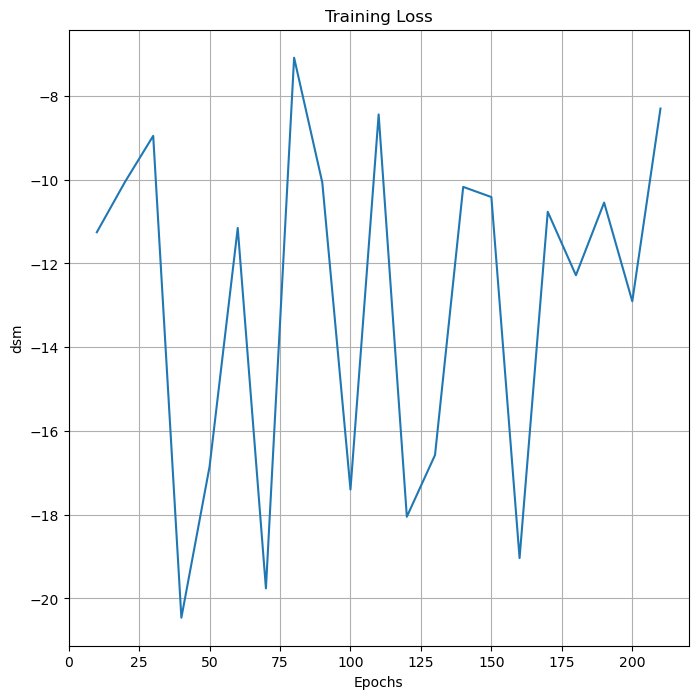

In [1140]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

In [1141]:
loss = jnp.load('scores/S'+str(N)+'/s2/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  270


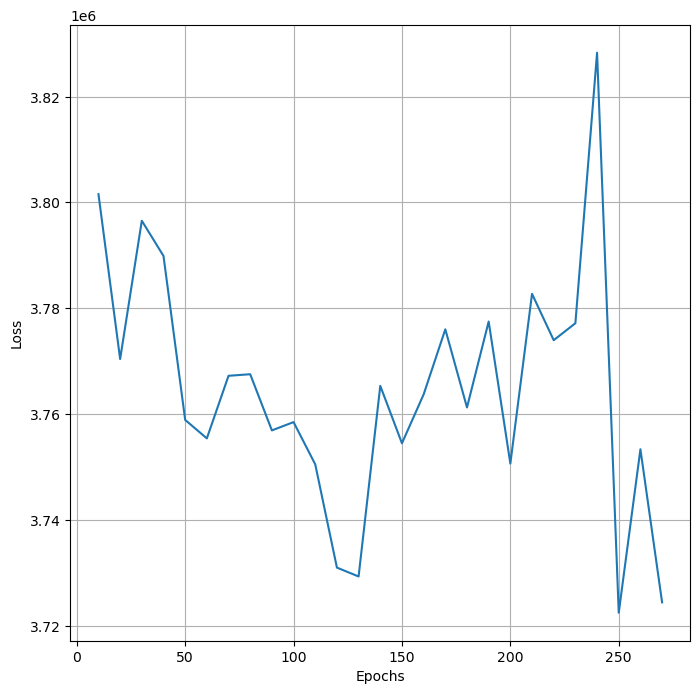

In [1142]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [1143]:
xs = pd.read_csv('Data/S'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/S'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

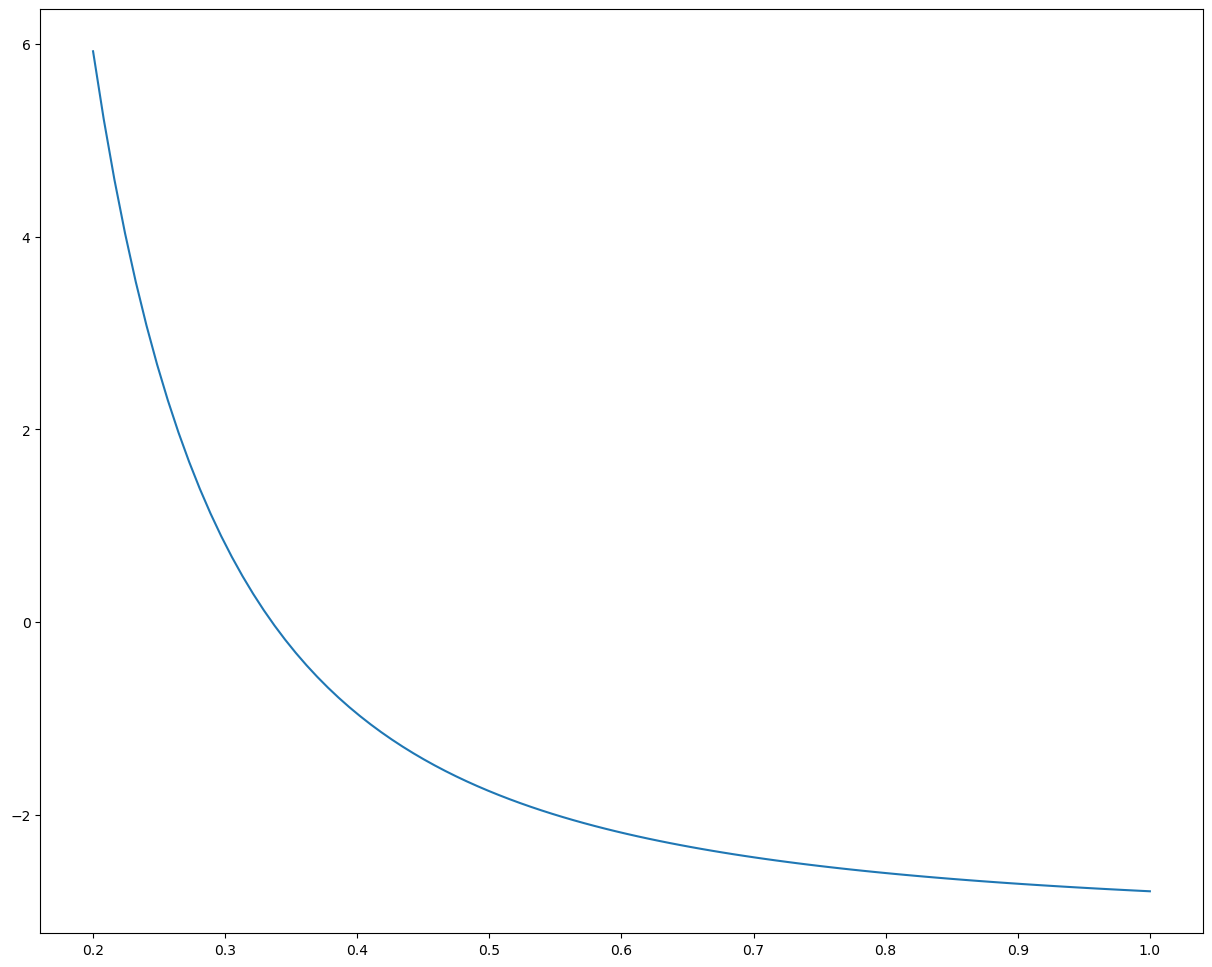

In [1144]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

In [1145]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")

In [1146]:
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.3]), 
                                     step_size=0.1, max_iter=1000)

In [83]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.532447e+01 | T: ((Array([-2.2847826e-09,  6.5007510e-10,  2.8858853e-09,  3.3108427e-10,
        2.1574467e-09,  4.8258170e-10,  5.0847299e-10,  4.1910438e-12,
       -4.6942193e-11,  4.2621540e-10], dtype=float32), Array(0.20999993, dtype=float32)), Array([ 0.01318251, -0.2719123 ,  0.0348863 , -0.20547883, -0.05547192,
       -0.17059147, -0.04376092, -0.018911  ,  0.0090002 , -0.10080759,
        0.9152906 ], dtype=float32))
Step 1 | T: 1.256124e+01 | T: ((Array([ 0.00884337,  0.00999874,  0.00912418, -0.00987595,  0.00855115,
        0.00692009, -0.00302555,  0.00766935,  0.00854711, -0.00235898],      dtype=float32), Array(0.21991883, dtype=float32)), Array([ 0.01318251, -0.2719123 ,  0.0348863 , -0.20547883, -0.05547192,
       -0.17059147, -0.04376092, -0.018911  ,  0.0090002 , -0.10080759,
        0.9152906 ], dtype=float32))
Final 1 | T: 1.256124e+01 | T: (Array([ 0.00884337,  0.00999874,  0.00912418, -0.00987595,  0.00855115,
        0.00692009, -0.00302555,  0.

Step 18 | T: 1.133659e+00 | T: ((Array([ 5.1467024e-02,  9.2320181e-03,  5.3735949e-02, -9.2574116e-03,
        1.5120372e-02,  4.4925790e-03, -7.1625700e-03, -1.7375284e-03,
       -4.2606494e-05,  6.7571248e-04], dtype=float32), Array(0.3524191, dtype=float32)), Array([ 0.01318251, -0.2719123 ,  0.0348863 , -0.20547883, -0.05547192,
       -0.17059147, -0.04376092, -0.018911  ,  0.0090002 , -0.10080759,
        0.9152906 ], dtype=float32))
Step 19 | T: 9.921764e-01 | T: ((Array([ 4.8538487e-02,  9.0696532e-03,  5.0526924e-02, -1.0761491e-02,
        1.2087273e-02,  5.0221654e-03, -5.9948112e-03, -2.4024523e-03,
       -1.2463648e-03,  7.0529990e-05], dtype=float32), Array(0.3577586, dtype=float32)), Array([ 0.01318251, -0.2719123 ,  0.0348863 , -0.20547883, -0.05547192,
       -0.17059147, -0.04376092, -0.018911  ,  0.0090002 , -0.10080759,
        0.9152906 ], dtype=float32))
Step 20 | T: 8.678766e-01 | T: ((Array([ 4.5388769e-02,  8.1981923e-03,  4.7094431e-02, -1.1644943e-02,
    

Step 38 | T: 1.417412e-03 | T: ((Array([ 0.00925358,  0.00359413,  0.01046329, -0.00753702,  0.01239556,
        0.00194861, -0.00250582,  0.00158672,  0.00846905,  0.00260117],      dtype=float32), Array(0.42248845, dtype=float32)), Array([ 0.01318251, -0.2719123 ,  0.0348863 , -0.20547883, -0.05547192,
       -0.17059147, -0.04376092, -0.018911  ,  0.0090002 , -0.10080759,
        0.9152906 ], dtype=float32))
Step 39 | T: -1.373746e-02 | T: ((Array([ 0.00970966,  0.00270981,  0.01110404, -0.00731771,  0.01298678,
        0.00149306, -0.00306809,  0.00143911,  0.00749671,  0.00253103],      dtype=float32), Array(0.42450398, dtype=float32)), Array([ 0.01318251, -0.2719123 ,  0.0348863 , -0.20547883, -0.05547192,
       -0.17059147, -0.04376092, -0.018911  ,  0.0090002 , -0.10080759,
        0.9152906 ], dtype=float32))
Step 40 | T: -2.686092e-02 | T: ((Array([ 0.01034725,  0.00197606,  0.01192032, -0.00683074,  0.01336186,
        0.00093344, -0.00360934,  0.00106855,  0.00651071,  0.0

Step 58 | T: -1.404936e-01 | T: ((Array([ 2.0461304e-02,  2.1844890e-03,  2.1655507e-02, -4.6097068e-03,
        6.2984177e-03,  3.5245219e-05, -2.4417310e-03,  1.8585820e-04,
        6.6930731e-03,  3.4813073e-03], dtype=float32), Array(0.44948354, dtype=float32)), Array([ 0.01318251, -0.2719123 ,  0.0348863 , -0.20547883, -0.05547192,
       -0.17059147, -0.04376092, -0.018911  ,  0.0090002 , -0.10080759,
        0.9152906 ], dtype=float32))
Step 59 | T: -1.419288e-01 | T: ((Array([ 2.0111380e-02,  2.4608651e-03,  2.1184145e-02, -4.2661252e-03,
        6.5039583e-03, -9.0794914e-05, -2.3700206e-03,  4.6540826e-04,
        6.6027902e-03,  3.6679707e-03], dtype=float32), Array(0.45031834, dtype=float32)), Array([ 0.01318251, -0.2719123 ,  0.0348863 , -0.20547883, -0.05547192,
       -0.17059147, -0.04376092, -0.018911  ,  0.0090002 , -0.10080759,
        0.9152906 ], dtype=float32))
Step 60 | T: -1.434907e-01 | T: ((Array([ 0.01969836,  0.00274311,  0.02065797, -0.00403815,  0.00678097

Step 78 | T: -1.714769e-01 | T: ((Array([ 0.01495985,  0.00305367,  0.01637322, -0.00437459,  0.00784146,
        0.000481  , -0.00271858,  0.00015663,  0.00546582,  0.0041213 ],      dtype=float32), Array(0.4616089, dtype=float32)), Array([ 0.01318251, -0.2719123 ,  0.0348863 , -0.20547883, -0.05547192,
       -0.17059147, -0.04376092, -0.018911  ,  0.0090002 , -0.10080759,
        0.9152906 ], dtype=float32))
Step 79 | T: -1.721356e-01 | T: ((Array([ 0.01511598,  0.00295938,  0.01657284, -0.00448491,  0.00766771,
        0.00052572, -0.00260028,  0.00020466,  0.0054965 ,  0.00423015],      dtype=float32), Array(0.46203056, dtype=float32)), Array([ 0.01318251, -0.2719123 ,  0.0348863 , -0.20547883, -0.05547192,
       -0.17059147, -0.04376092, -0.018911  ,  0.0090002 , -0.10080759,
        0.9152906 ], dtype=float32))
Step 80 | T: -1.732133e-01 | T: ((Array([ 0.01528987,  0.00280919,  0.01677835, -0.00457525,  0.00751925,
        0.00055526, -0.00251727,  0.00031798,  0.00548381,  0.0

Step 98 | T: -1.816699e-01 | T: ((Array([ 0.01590137,  0.00272571,  0.01686885, -0.00446123,  0.00795678,
        0.00042846, -0.00279667,  0.00032246,  0.00507727,  0.00404612],      dtype=float32), Array(0.4681085, dtype=float32)), Array([ 0.01318251, -0.2719123 ,  0.0348863 , -0.20547883, -0.05547192,
       -0.17059147, -0.04376092, -0.018911  ,  0.0090002 , -0.10080759,
        0.9152906 ], dtype=float32))
Step 99 | T: -1.836410e-01 | T: ((Array([ 0.01579251,  0.00275303,  0.01676073, -0.00441832,  0.00791184,
        0.00039452, -0.00274018,  0.00032868,  0.00510447,  0.00400808],      dtype=float32), Array(0.4683481, dtype=float32)), Array([ 0.01318251, -0.2719123 ,  0.0348863 , -0.20547883, -0.05547192,
       -0.17059147, -0.04376092, -0.018911  ,  0.0090002 , -0.10080759,
        0.9152906 ], dtype=float32))
Final 99 | T: -1.836410e-01 | T: (Array([ 0.01579251,  0.00275303,  0.01676073, -0.00441832,  0.00791184,
        0.00039452, -0.00274018,  0.00032868,  0.00510447,  0.00

In [1147]:
#diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = lambda x,y,t: jacfwdx(lambda y: M.grady_log_hk(x,y,t)[0])(y), method="Gradient")
diffusion_mean(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = M.gradt_log_hk, method="Gradient")
mu_opt, T_opt, _, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]))

In [1148]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0891 0.0801 0.9927 )
T = 1.0000


In [97]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.0132 -0.2719 0.0349 -0.2055 -0.0555 -0.1706 -0.0438 -0.0189 0.0090 -0.1008 0.9153 )
T = 0.4683


In [98]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_opt[1][-1]), ")")
print(f"T = {T_opt[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0567 0.0145 0.1066 0.0924 -0.0552 -0.0367 0.0101 -0.0443 0.0050 -0.0209 0.9848 )
T = 0.5000


In [99]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.4588 
 -T error = 0.0317


In [100]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_sm[1][-1])/N:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt[-1][0]):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_bridgechart[-1])/N:.5f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.00000 
 -T error = 0.0000
Bridge Diffusion mean: 
 -mean error = 0.04588 
 -T error = 0.0317


## Timing Score

In [103]:
dims = [2,3,5,10]
time_score = []
time_bridge = []

for N in dims:
    print(N)
    M = nSphere(N=N)
    jstoch.Brownian_coords(M)
    jstat.diffusion_mean(M)
    x0 = M.coords([0.]*N)

    file_path = 'scores/S'+str(N)+'/s1_'+ loss_type + '/'
    state = model_loader.load_model(file_path)

    file_path_s2 = 'scores/S'+str(N)+'/s2/'
    state_s2 = model_loader.load_model(file_path_s2)
    if N<10:
        layers = [50,100,100,50]
    elif N<50:
        layers = [50,100,200,200,100,50]
    else:
        layers = [50,100,200,400,400,200,100,50]
    s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
    s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                    dim=M.emb_dim, r = max(M.dim//2,1))(x))
    rng_key = jax.random.PRNGKey(2712)
    def grady_log(x,y,t):

        return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

    def gradt_log(x,y,t):

        s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
        s2_val = ggrady_log(x,y,t)
        s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)

        div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())

        return 0.5*(jnp.dot(s1_val, s1_val)+div)

    def ggrady_log_ad(x,y,t):

        ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)

        return ggrad

    def ggrady_log_score(x,y,t):

        ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[1],y[1],t)))

        return jnp.dot(M.invJF((M.F(y), y[1])), ggrad)

    if s2_approximation:
        ggrady_log = ggrady_log_score
    else:
        ggrady_log = ggrady_log_ad
        
    xs = pd.read_csv('Data/S'+str(N)+'/xs.csv', header=None)
    charts = pd.read_csv('Data/S'+str(N)+'/chart.csv', header=None)
    X_obs = (jnp.array(xs.values), jnp.array(charts.values))
    
    diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
    result = %timeit -o M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), \
                                           step_size=0.01, max_iter=100)
    time_score.append(result)
    result = %timeit -o M.diffusion_mean(X_obs,num_steps=100, N=1)
    time_bridge.append(result)

2
using M.Exp for Logarithm
914 ms ± 9.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Step 0 | T: 9.045785e+00 | T: ((Array([ 0.01163083, -0.0434425 ], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 7.991252e+00 | T: ((Array([ 0.01245216, -0.03357188], dtype=float32), Array(0.21992584, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 2 | T: 7.101362e+00 | T: ((Array([ 0.0160122 , -0.02392925], dtype=float32), Array(0.22973661, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 3 | T: 6.349108e+00 | T: ((Array([ 0.01915262, -0.01461921], dtype=float32), Array(0.2393977, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 4 | T: 5.710273e+00 | T: ((Array([ 0.02020616, -0.00574349], dtype=float32), Array(0.2488805, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 5 | T: 5.166684e+00 | T: ((Array([0.01926227, 0.00260007], dtype=float32), Array(0.25816208, dtype=float32)), Array([0., 0., 1.], dtype=

Step 64 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 65 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 66 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 67 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 68 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 69 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 70 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 71 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 72 | T: nan | T: ((

Step 25 | T: 1.628686e+00 | T: ((Array([0.01294184, 0.03626966], dtype=float32), Array(0.3937581, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 26 | T: 1.578584e+00 | T: ((Array([0.01356781, 0.03414906], dtype=float32), Array(0.3983018, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 27 | T: 1.532483e+00 | T: ((Array([0.01421534, 0.03199829], dtype=float32), Array(0.40268132, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 28 | T: 1.490357e+00 | T: ((Array([0.01475554, 0.02984851], dtype=float32), Array(0.40690377, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 29 | T: 1.450842e+00 | T: ((Array([0.0151051 , 0.02772752], dtype=float32), Array(0.41097602, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 30 | T: 1.415187e+00 | T: ((Array([0.01520836, 0.02566148], dtype=float32), Array(0.41490492, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 31 | T: 1.382138e+00 | T: ((Array([0.01506971, 0.02367251], dtype=float32), Array(0.4

Step 80 | T: 8.526035e-01 | T: ((Array([0.01261372, 0.01755135], dtype=float32), Array(0.52148575, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 81 | T: 8.493322e-01 | T: ((Array([0.01260655, 0.01741161], dtype=float32), Array(0.5227987, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 82 | T: 8.456793e-01 | T: ((Array([0.01259632, 0.0172654 ], dtype=float32), Array(0.524097, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 83 | T: 8.416598e-01 | T: ((Array([0.0125951 , 0.01711522], dtype=float32), Array(0.52538097, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 84 | T: 8.386741e-01 | T: ((Array([0.01258443, 0.0169617 ], dtype=float32), Array(0.5266509, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 85 | T: 8.350921e-01 | T: ((Array([0.01258632, 0.01680811], dtype=float32), Array(0.52790713, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 86 | T: 8.323963e-01 | T: ((Array([0.01258634, 0.01665593], dtype=float32), Array(0.529

Step 38 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 39 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 40 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 41 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 42 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 43 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 44 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 45 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 46 | T: nan | T: ((

Step 4 | T: 5.711473e+00 | T: ((Array([ 0.02016209, -0.00573971], dtype=float32), Array(0.24888098, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 5 | T: 5.166816e+00 | T: ((Array([0.01922329, 0.0026055 ], dtype=float32), Array(0.2581626, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 6 | T: 4.701509e+00 | T: ((Array([0.01714822, 0.01033262], dtype=float32), Array(0.26722497, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 7 | T: 4.300499e+00 | T: ((Array([0.01478965, 0.01736988], dtype=float32), Array(0.2760544, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 8 | T: 3.955084e+00 | T: ((Array([0.01288747, 0.02366466], dtype=float32), Array(0.28464112, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 9 | T: 3.655872e+00 | T: ((Array([0.01190002, 0.02918439], dtype=float32), Array(0.29297855, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 10 | T: 3.393794e+00 | T: ((Array([0.0119092 , 0.03391863], dtype=float32), Array(0.30106

Step 59 | T: 9.597480e-01 | T: ((Array([0.01335757, 0.01459817], dtype=float32), Array(0.48954654, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 60 | T: 9.532180e-01 | T: ((Array([0.01332889, 0.01506102], dtype=float32), Array(0.49131104, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 61 | T: 9.462790e-01 | T: ((Array([0.01324594, 0.01549778], dtype=float32), Array(0.49304473, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 62 | T: 9.399000e-01 | T: ((Array([0.01313908, 0.01590524], dtype=float32), Array(0.49474895, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 63 | T: 9.334344e-01 | T: ((Array([0.01302965, 0.01628076], dtype=float32), Array(0.49642488, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 64 | T: 9.274523e-01 | T: ((Array([0.01291892, 0.01662284], dtype=float32), Array(0.4980737, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 65 | T: 9.219731e-01 | T: ((Array([0.01283034, 0.01692861], dtype=float32), Array(0.

Step 16 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 17 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 18 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 19 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 20 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 21 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 22 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 23 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 24 | T: nan | T: ((

Step 84 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 85 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 86 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 87 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 88 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 89 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 90 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 91 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 92 | T: nan | T: ((

Step 51 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 52 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 53 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 54 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 55 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 56 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 57 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 58 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 59 | T: nan | T: ((

Step 15 | T: 2.483171e+00 | T: ((Array([0.01686817, 0.04654293], dtype=float32), Array(0.33768317, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 16 | T: 2.354946e+00 | T: ((Array([0.01693961, 0.0471529 ], dtype=float32), Array(0.34426856, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 17 | T: 2.239385e+00 | T: ((Array([0.01649255, 0.04725169], dtype=float32), Array(0.35061872, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 18 | T: 2.135923e+00 | T: ((Array([0.01567659, 0.04689742], dtype=float32), Array(0.35673988, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 19 | T: 2.041491e+00 | T: ((Array([0.01466813, 0.04614703], dtype=float32), Array(0.3626386, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 20 | T: 1.956218e+00 | T: ((Array([0.01367999, 0.04505685], dtype=float32), Array(0.36832184, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 21 | T: 1.877450e+00 | T: ((Array([0.01287332, 0.04367841], dtype=float32), Array(0.

Step 70 | T: 8.955953e-01 | T: ((Array([0.01285   , 0.01794191], dtype=float32), Array(0.50745, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 71 | T: 8.904602e-01 | T: ((Array([0.01288277, 0.01802357], dtype=float32), Array(0.50893635, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 72 | T: 8.860428e-01 | T: ((Array([0.01291974, 0.01807266], dtype=float32), Array(0.5104028, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 73 | T: 8.811446e-01 | T: ((Array([0.01293461, 0.01808997], dtype=float32), Array(0.51184994, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 74 | T: 8.766546e-01 | T: ((Array([0.0129155 , 0.01807828], dtype=float32), Array(0.5132784, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 75 | T: 8.727586e-01 | T: ((Array([0.01287149, 0.01804045], dtype=float32), Array(0.5146889, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 76 | T: 8.682425e-01 | T: ((Array([0.0128057, 0.0179783], dtype=float32), Array(0.5160819

Step 25 | T: 1.628514e+00 | T: ((Array([0.013002 , 0.0362714], dtype=float32), Array(0.3937595, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 26 | T: 1.578343e+00 | T: ((Array([0.0136104 , 0.03415186], dtype=float32), Array(0.39830318, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 27 | T: 1.531988e+00 | T: ((Array([0.01422564, 0.03200113], dtype=float32), Array(0.40268257, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 28 | T: 1.490155e+00 | T: ((Array([0.01473398, 0.02985139], dtype=float32), Array(0.4069049, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 29 | T: 1.451111e+00 | T: ((Array([0.01504014, 0.02773125], dtype=float32), Array(0.4109771, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 30 | T: 1.415330e+00 | T: ((Array([0.01511728, 0.02566602], dtype=float32), Array(0.414906, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 31 | T: 1.382319e+00 | T: ((Array([0.01497632, 0.02367731], dtype=float32), Array(0.418698

Step 80 | T: 8.528425e-01 | T: ((Array([0.01258389, 0.01757165], dtype=float32), Array(0.52148867, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 81 | T: 8.492763e-01 | T: ((Array([0.01256143, 0.01743128], dtype=float32), Array(0.52280164, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 82 | T: 8.455395e-01 | T: ((Array([0.01255391, 0.01728428], dtype=float32), Array(0.52409995, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 83 | T: 8.422064e-01 | T: ((Array([0.0125618 , 0.01713132], dtype=float32), Array(0.52538395, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 84 | T: 8.386081e-01 | T: ((Array([0.01258198, 0.01697478], dtype=float32), Array(0.526654, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 85 | T: 8.354800e-01 | T: ((Array([0.0126243 , 0.01681809], dtype=float32), Array(0.5279104, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 86 | T: 8.323006e-01 | T: ((Array([0.01266598, 0.01666282], dtype=float32), Array(0.52

Step 24 | T: 2.180932e+00 | T: ((Array([-0.07632288,  0.01397538,  0.03365638], dtype=float32), Array(0.38671273, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 25 | T: 2.110601e+00 | T: ((Array([-0.07807811,  0.01305317,  0.03199854], dtype=float32), Array(0.39128554, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 26 | T: 2.046082e+00 | T: ((Array([-0.07953563,  0.01205928,  0.03016413], dtype=float32), Array(0.3956882, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 27 | T: 1.986766e+00 | T: ((Array([-0.08071133,  0.01104077,  0.02818881], dtype=float32), Array(0.39992818, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 28 | T: 1.932590e+00 | T: ((Array([-0.08162117,  0.0100344 ,  0.02610647], dtype=float32), Array(0.40401283, dtype=float32)), Array([-0.03674259,  0.18040879,  0.003065

Step 64 | T: 1.195142e+00 | T: ((Array([-0.05150324,  0.00725415, -0.00202238], dtype=float32), Array(0.4912967, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 65 | T: 1.187531e+00 | T: ((Array([-0.05086002,  0.00718176, -0.00153639], dtype=float32), Array(0.49283504, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 66 | T: 1.179862e+00 | T: ((Array([-0.05026503,  0.00714597, -0.00105861], dtype=float32), Array(0.49434927, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 67 | T: 1.173751e+00 | T: ((Array([-0.04971831,  0.00713644, -0.000595  ], dtype=float32), Array(0.49584037, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 68 | T: 1.166327e+00 | T: ((Array([-0.04921651,  0.00715526, -0.00014741], dtype=float32), Array(0.4973092, dtype=float32)), Array([-0.03674259,  0.18040879,  0.0030658

Step 4 | T: 7.920360e+00 | T: ((Array([-0.03754917, -0.02907104,  0.03917426], dtype=float32), Array(0.24882035, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593223, 0.9305281 ], dtype=float32))
Step 5 | T: 7.114683e+00 | T: ((Array([-0.04628538, -0.03226851,  0.04847256], dtype=float32), Array(0.2580634, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593223, 0.9305281 ], dtype=float32))
Step 6 | T: 6.428734e+00 | T: ((Array([-0.0546921 , -0.03381805,  0.0573892 ], dtype=float32), Array(0.26707602, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593223, 0.9305281 ], dtype=float32))
Step 7 | T: 5.843668e+00 | T: ((Array([-0.06273833, -0.03397847,  0.06585204], dtype=float32), Array(0.2758443, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593223, 0.9305281 ], dtype=float32))
Step 8 | T: 5.341877e+00 | T: ((Array([ 9.5814601e-10,  1.0832047e-10, -1.8833879e-09], dtype=float32), Array(0.28435847, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899

Step 44 | T: 1.430257e+00 | T: ((Array([-0.07306666,  0.0079308 , -0.0026878 ], dtype=float32), Array(0.45334113, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 45 | T: 1.413023e+00 | T: ((Array([-0.07180492,  0.00830906, -0.00354675], dtype=float32), Array(0.45568585, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 46 | T: 1.395797e+00 | T: ((Array([-0.07052713,  0.00864812, -0.00427345], dtype=float32), Array(0.45796838, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 47 | T: 1.379908e+00 | T: ((Array([-0.06924219,  0.00893948, -0.00487144], dtype=float32), Array(0.46019188, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 48 | T: 1.365347e+00 | T: ((Array([-0.06795681,  0.00917245, -0.00534546], dtype=float32), Array(0.46235937, dtype=float32)), Array([-0.03673254,  0.18041973,  0.00300

Step 84 | T: 1.083288e+00 | T: ((Array([-0.0458579 ,  0.00777991,  0.00319078], dtype=float32), Array(0.5183311, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 85 | T: 1.078878e+00 | T: ((Array([-0.04584624,  0.00773207,  0.00317659], dtype=float32), Array(0.5195156, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 86 | T: 1.074768e+00 | T: ((Array([-0.04584648,  0.00767833,  0.00314449], dtype=float32), Array(0.5206871, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 87 | T: 1.070988e+00 | T: ((Array([-0.0458559 ,  0.00762035,  0.00309489], dtype=float32), Array(0.521846, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 88 | T: 1.067153e+00 | T: ((Array([-0.04587323,  0.00756016,  0.00302863], dtype=float32), Array(0.52299255, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  , 

Step 24 | T: 2.181210e+00 | T: ((Array([-0.07632178,  0.01395577,  0.03366904], dtype=float32), Array(0.386712, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 25 | T: 2.110474e+00 | T: ((Array([-0.07807846,  0.01302865,  0.03200902], dtype=float32), Array(0.39128482, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 26 | T: 2.046990e+00 | T: ((Array([-0.07953769,  0.01203413,  0.03017149], dtype=float32), Array(0.39568758, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 27 | T: 1.987230e+00 | T: ((Array([-0.08071557,  0.01101506,  0.02819367], dtype=float32), Array(0.39992768, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 28 | T: 1.932219e+00 | T: ((Array([-0.08162772,  0.01001132,  0.02610901], dtype=float32), Array(0.40401235, dtype=float32)), Array([-0.03674789,  0.18041676,  0.0030122

Step 64 | T: 1.195109e+00 | T: ((Array([-0.0514839 ,  0.00729262, -0.00203124], dtype=float32), Array(0.4912951, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 65 | T: 1.187732e+00 | T: ((Array([-0.05083869,  0.00720299, -0.00154877], dtype=float32), Array(0.4928334, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 66 | T: 1.179949e+00 | T: ((Array([-0.05024233,  0.00714788, -0.00107492], dtype=float32), Array(0.49434757, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 67 | T: 1.173604e+00 | T: ((Array([-0.04969326,  0.00712425, -0.00061408], dtype=float32), Array(0.49583858, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 68 | T: 1.167078e+00 | T: ((Array([-0.04918887,  0.00713048, -0.00016838], dtype=float32), Array(0.49730736, dtype=float32)), Array([-0.03674789,  0.18041676,  0.0030122

Step 4 | T: 7.919983e+00 | T: ((Array([-0.03755009, -0.02908238,  0.03917663], dtype=float32), Array(0.24881986, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 5 | T: 7.114481e+00 | T: ((Array([-0.04628715, -0.03228177,  0.04847465], dtype=float32), Array(0.25806257, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 6 | T: 6.428839e+00 | T: ((Array([-0.05469453, -0.03383695,  0.05739053], dtype=float32), Array(0.26707485, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 7 | T: 5.843569e+00 | T: ((Array([-0.06274144, -0.03399646,  0.0658535 ], dtype=float32), Array(0.27584288, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 8 | T: 5.340868e+00 | T: ((Array([ 2.4467806e-09,  2.1462701e-11, -1.8297976e-09], dtype=float32), Array(0.2843566, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.98290

Step 44 | T: 1.430719e+00 | T: ((Array([-0.07304336,  0.0079729 , -0.00270865], dtype=float32), Array(0.45333236, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 45 | T: 1.413223e+00 | T: ((Array([-0.0717819 ,  0.00834753, -0.00356317], dtype=float32), Array(0.45567712, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 46 | T: 1.396348e+00 | T: ((Array([-0.07050394,  0.00868422, -0.00428509], dtype=float32), Array(0.4579597, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 47 | T: 1.379564e+00 | T: ((Array([-0.06921791,  0.00897365, -0.00487857], dtype=float32), Array(0.46018326, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 48 | T: 1.364959e+00 | T: ((Array([-0.06793229,  0.00920542, -0.00534849], dtype=float32), Array(0.46235082, dtype=float32)), Array([-0.03672874,  0.18041234,  0.002953

Step 84 | T: 1.082973e+00 | T: ((Array([-0.0458329 ,  0.00785341,  0.00318827], dtype=float32), Array(0.5183209, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 85 | T: 1.078416e+00 | T: ((Array([-0.04582181,  0.00780332,  0.00316793], dtype=float32), Array(0.5195053, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 86 | T: 1.075073e+00 | T: ((Array([-0.04582163,  0.00774661,  0.00312912], dtype=float32), Array(0.52067685, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 87 | T: 1.071362e+00 | T: ((Array([-0.04583264,  0.00768042,  0.00307471], dtype=float32), Array(0.52183574, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 88 | T: 1.066998e+00 | T: ((Array([-0.04585174,  0.00761448,  0.00300694], dtype=float32), Array(0.5229823, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366

Step 24 | T: 2.181390e+00 | T: ((Array([-0.07634588,  0.01393291,  0.03365735], dtype=float32), Array(0.38670892, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 25 | T: 2.111240e+00 | T: ((Array([-0.07810432,  0.01299793,  0.0319964 ], dtype=float32), Array(0.3912816, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 26 | T: 2.047206e+00 | T: ((Array([-0.07956445,  0.01199939,  0.03015795], dtype=float32), Array(0.39568427, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 27 | T: 1.987495e+00 | T: ((Array([-0.08074307,  0.01097715,  0.02817926], dtype=float32), Array(0.3999243, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 28 | T: 1.932657e+00 | T: ((Array([-0.08165558,  0.00997228,  0.02609472], dtype=float32), Array(0.40400898, dtype=float32)), Array([-0.03674502,  0.18041939,  0.0030338

Step 64 | T: 1.194899e+00 | T: ((Array([-0.05150449,  0.00730229, -0.00203192], dtype=float32), Array(0.4912919, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 65 | T: 1.187667e+00 | T: ((Array([-0.0508603 ,  0.00721967, -0.00154921], dtype=float32), Array(0.4928303, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 66 | T: 1.180626e+00 | T: ((Array([-0.05026455,  0.00716641, -0.00107522], dtype=float32), Array(0.49434465, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 67 | T: 1.173752e+00 | T: ((Array([-0.04971559,  0.00714746, -0.00061294], dtype=float32), Array(0.49583587, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 68 | T: 1.166353e+00 | T: ((Array([-0.04921364,  0.0071597 , -0.00016939], dtype=float32), Array(0.49730483, dtype=float32)), Array([-0.03674502,  0.18041939,  0.0030338

Step 4 | T: 7.921003e+00 | T: ((Array([-0.03754768, -0.02905001,  0.03917802], dtype=float32), Array(0.24882077, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 5 | T: 7.114496e+00 | T: ((Array([-0.0462841 , -0.03224456,  0.04847597], dtype=float32), Array(0.2580638, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 6 | T: 6.430240e+00 | T: ((Array([-0.05469113, -0.03378661,  0.05739272], dtype=float32), Array(0.26707646, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 7 | T: 5.844712e+00 | T: ((Array([-0.06273765, -0.03394192,  0.06585623], dtype=float32), Array(0.2758449, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 8 | T: 5.341676e+00 | T: ((Array([-6.4139853e-09, -2.8468812e-11,  1.6161046e-09], dtype=float32), Array(0.28435913, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.982898

Step 44 | T: 1.430168e+00 | T: ((Array([-0.07303432,  0.00793134, -0.00264969], dtype=float32), Array(0.4533359, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 45 | T: 1.412456e+00 | T: ((Array([-0.07177364,  0.00830642, -0.00350672], dtype=float32), Array(0.45568043, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 46 | T: 1.395867e+00 | T: ((Array([-0.0704971 ,  0.00864153, -0.00423124], dtype=float32), Array(0.45796278, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 47 | T: 1.380344e+00 | T: ((Array([-0.06921256,  0.00892865, -0.00482781], dtype=float32), Array(0.46018618, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 48 | T: 1.365081e+00 | T: ((Array([-0.06792774,  0.009156  , -0.00530044], dtype=float32), Array(0.46235362, dtype=float32)), Array([-0.03674645,  0.18041795,  0.003067

Step 84 | T: 1.083711e+00 | T: ((Array([-0.04587873,  0.00781169,  0.00318143], dtype=float32), Array(0.518325, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 85 | T: 1.078781e+00 | T: ((Array([-0.04586844,  0.00775813,  0.00316301], dtype=float32), Array(0.5195095, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 86 | T: 1.074830e+00 | T: ((Array([-0.04586916,  0.00769546,  0.00312654], dtype=float32), Array(0.5206811, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 87 | T: 1.071238e+00 | T: ((Array([-0.04587795,  0.00762757,  0.00307468], dtype=float32), Array(0.52184004, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 88 | T: 1.067188e+00 | T: ((Array([-0.04589515,  0.00756099,  0.00300977], dtype=float32), Array(0.52298665, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,

Step 24 | T: 2.181361e+00 | T: ((Array([-0.07632068,  0.01407506,  0.03363745], dtype=float32), Array(0.38670778, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 25 | T: 2.110771e+00 | T: ((Array([-0.07807758,  0.01315674,  0.031977  ], dtype=float32), Array(0.39128044, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 26 | T: 2.045927e+00 | T: ((Array([-0.07953639,  0.01216731,  0.03013863], dtype=float32), Array(0.395683, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 27 | T: 1.986577e+00 | T: ((Array([-0.08071247,  0.01114905,  0.02816003], dtype=float32), Array(0.39992285, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 28 | T: 1.932618e+00 | T: ((Array([-0.0816227 ,  0.01014393,  0.02607611], dtype=float32), Array(0.40400738, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318

Step 64 | T: 1.195366e+00 | T: ((Array([-0.05145447,  0.00732757, -0.0020245 ], dtype=float32), Array(0.49129108, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 65 | T: 1.187483e+00 | T: ((Array([-0.05081154,  0.00723342, -0.00154079], dtype=float32), Array(0.49282944, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 66 | T: 1.181040e+00 | T: ((Array([-0.05021778,  0.00717502, -0.00106521], dtype=float32), Array(0.4943438, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 67 | T: 1.173500e+00 | T: ((Array([-0.04967105,  0.00713686, -0.00060252], dtype=float32), Array(0.49583498, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 68 | T: 1.166558e+00 | T: ((Array([-0.04917051,  0.0071291 , -0.0001573 ], dtype=float32), Array(0.4973039, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (4,) and (2,)

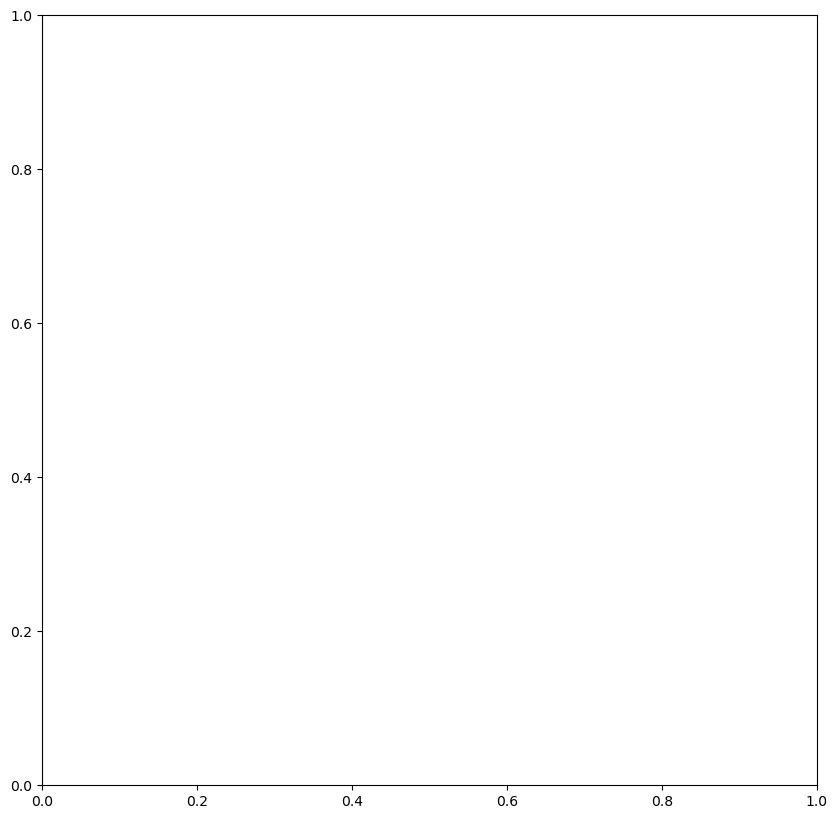

In [104]:
#Plotting time difference

sn_dims = jnp.array(dims)

sn_score_tmean = jnp.array([time.average for time in time_score])
sn_score_tstd = jnp.array([time.stdev for time in time_bridge])

sn_bridge_tmean = jnp.array([time.average for time in time_bridge])
sn_bridge_tstd = jnp.array([time.stdev for time in time_bridge])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(sn_dims, sn_score_tmean, color='orange')
ax.plot(sn_dims, sn_bridge_tmean, color='blue')
ax.set_xlabel(f'$N$')
ax.set_ylabel(f'$Time$')
ax.grid(True)
ax.fill_between(
    rn_dims,
    jnp.maximum(sn_score_tmean - 1.96 * sn_score_tstd, jnp.zeros_like(sn_score_tmean)),
    jnp.maximum(sn_score_tmean + 1.96 * sn_score_tstd, jnp.zeros_like(sn_score_tmean)),
    color="tab:red",
    alpha=0.5,
)
ax.fill_between(
    dims,
    jnp.maximum(sn_bridge_tmean - 1.96 * sn_bridge_tstd, jnp.zeros_like(sn_bridge_tmean)),
    jnp.maximum(sn_bridge_tmean + 1.96 * sn_bridge_tstd, jnp.zeros_like(sn_bridge_tmean)),
    color="tab:pink",
    alpha=0.5,
)
ax.grid(True)



# n-Ellipsoid

## Defining Manifold and Loading Score

In [4]:
N = 5 #Change this for Ellipsoid2, Ellipsoid3, Ellipsoid5, Ellipsoid10, Ellipsoid20

In [5]:
M = nEllipsoid(N=N, params = jnp.linspace(0.5,1.0,N+1))
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*N)

using M.Exp for Logarithm


In [6]:
file_path = 'scores/Ellipsoid'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

file_path_s2 = 'scores/Ellipsoid'+str(N)+'/s2/'
state_s2 = model_loader.load_model(file_path_s2)
if N<10:
    layers = [50,100,200,200,100,50]
elif N<50:
    layers = [50,100,200,400,400,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log_ad(x,y,t):
    
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

def ggrady_log_score(x,y,t):
    
    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[1],y[1],t)))
    
    return jnp.dot(M.invJF((M.F(y), y[1])), ggrad)

if s2_approximation:
    ggrady_log = ggrady_log_score
else:
    ggrady_log = ggrady_log_ad

## Loading Loss

In [7]:
loss = jnp.load('scores/Ellipsoid'+str(N)+'/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


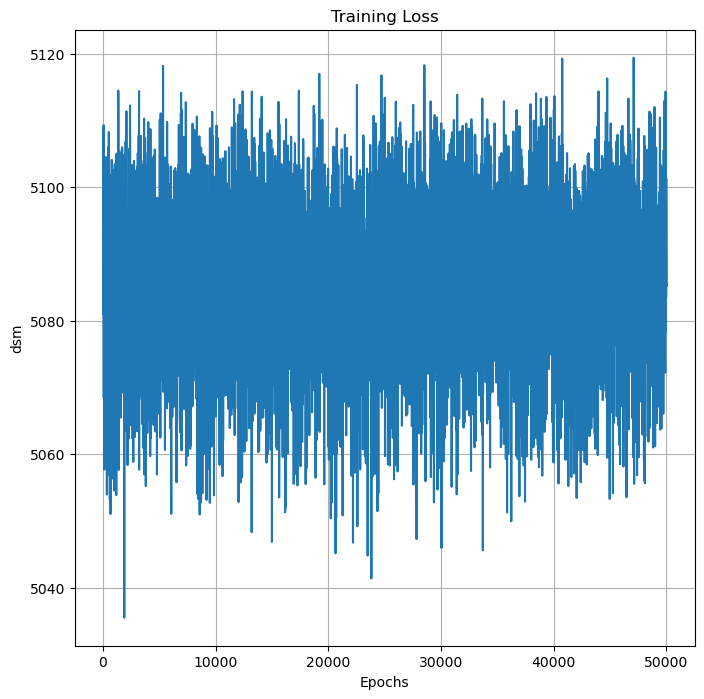

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [9]:
xs = pd.read_csv('Data/Ellipsoid'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/Ellipsoid'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

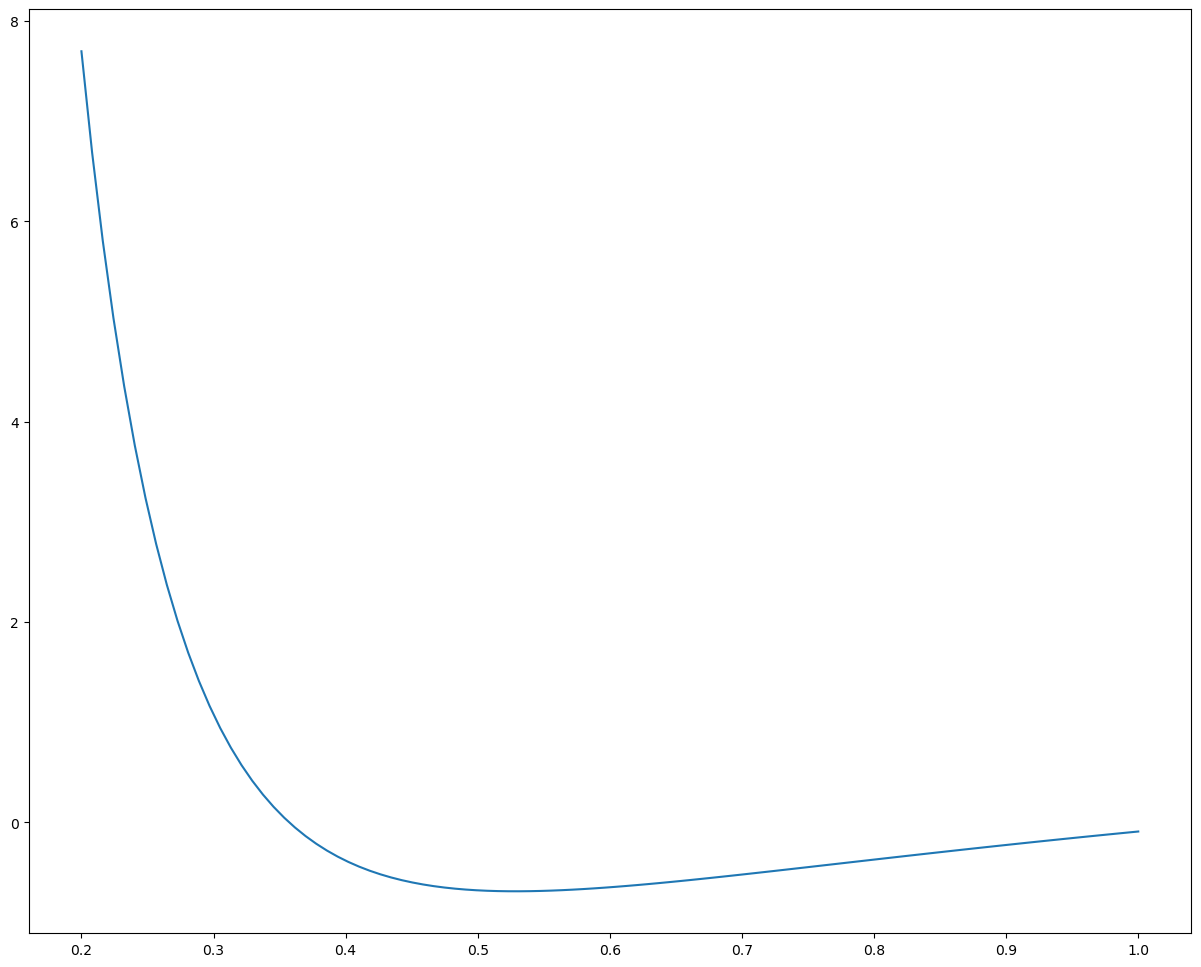

In [10]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

In [11]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")

In [12]:
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.01, max_iter=1000)

In [13]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 7.988443e+00 | T: ((Array([ 7.304285e-10,  7.072030e-09, -7.675185e-10,  0.000000e+00,
       -0.000000e+00], dtype=float32), Array(0.20999993, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 1 | T: 6.308940e+00 | T: ((Array([ 0.00267503, -0.00850208,  0.00732838, -0.00878681,  0.0043459 ],      dtype=float32), Array(0.21986869, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Final 1 | T: 6.308940e+00 | T: (Array([ 0.00267503, -0.00850208,  0.00732838, -0.00878681,  0.0043459 ],      dtype=float32), Array(0.21986869, dtype=float32))
Step 0 | T: 7.988943e+00 | T: ((Array([ 7.304285e-10,  7.072030e-09, -7.675185e-10,  0.000000e+00,
       -0.000000e+00], dtype=float32), Array(0.20999993, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 1

Step 28 | T: 1.443838e+00 | T: ((Array([-0.00113742, -0.01998527,  0.00696823, -0.0085279 , -0.05336267],      dtype=float32), Array(0.39043367, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 29 | T: 1.431378e+00 | T: ((Array([-0.00105809, -0.01812041,  0.00690034, -0.00997708, -0.0531062 ],      dtype=float32), Array(0.39342338, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 30 | T: 1.419907e+00 | T: ((Array([-0.00059141, -0.01643053,  0.00661477, -0.01143166, -0.05278644],      dtype=float32), Array(0.3962499, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 31 | T: 1.411155e+00 | T: ((Array([ 7.74780638e-05, -1.49261085e-02,  6.13748934e-03, -1.28165698e-02,
       -5.24291657e-02], dtype=float32), Array(0.39892128, dtype=float32)), Arra

Step 58 | T: 1.340508e+00 | T: ((Array([ 0.00017663, -0.01796327,  0.00326702, -0.01182691, -0.05704661],      dtype=float32), Array(0.43422815, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 59 | T: 1.341329e+00 | T: ((Array([ 0.0004388 , -0.01813338,  0.00306873, -0.01221958, -0.05729782],      dtype=float32), Array(0.4347436, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 60 | T: 1.338729e+00 | T: ((Array([ 0.0006343 , -0.01824311,  0.00288849, -0.01259238, -0.05749977],      dtype=float32), Array(0.43522942, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 61 | T: 1.340548e+00 | T: ((Array([ 0.00075199, -0.0182962 ,  0.00273261, -0.01292981, -0.05765264],      dtype=float32), Array(0.43568757, dtype=float32)), Array([ 0.13723479,  0.020

Step 89 | T: 1.336584e+00 | T: ((Array([ 0.00036709, -0.01503757,  0.0029117 , -0.01270778, -0.05757137],      dtype=float32), Array(0.44176534, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 90 | T: 1.337759e+00 | T: ((Array([ 0.0001713 , -0.01509787,  0.00297327, -0.01272994, -0.05764845],      dtype=float32), Array(0.44184697, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 91 | T: 1.337981e+00 | T: ((Array([ 0.00021848, -0.01516283,  0.00303546, -0.0127139 , -0.05772037],      dtype=float32), Array(0.44192395, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 92 | T: 1.337053e+00 | T: ((Array([ 0.00053351, -0.01523165,  0.00308997, -0.01266958, -0.05778564],      dtype=float32), Array(0.44199648, dtype=float32)), Array([ 0.13723479,  0.02

In [14]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -0.0014 0.0008 0.0003 -0.0023 0.0009 0.0307 )
T = 0.1586


In [15]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.1372 0.0201 0.1975 -0.0797 0.0939 0.9626 )
T = 0.4424


In [337]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.4f}")

The difference between the score and bridge:


TypeError: sub got incompatible shapes for broadcasting: (2,), (6,).

In [338]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_sm[1][-1])/N:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1])/N:.5f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.19516 
 -T error = 0.4600


TypeError: sub got incompatible shapes for broadcasting: (6,), (2,).

## Timing Score

In [103]:
dims = [2,3,5,10]
time_score = []
time_bridge = []

for N in dims:
    print(N)
    M = nEllipsoid(N=N, params = jnp.linspace(0.5,1.0,N+1))
    jstoch.Brownian_coords(M)
    jstat.diffusion_mean(M)
    x0 = M.coords([0.]*N)

    file_path = 'scores/Ellipsoid'+str(N)+'/s1_'+ loss_type + '/'
    state = model_loader.load_model(file_path)

    file_path_s2 = 'scores/Ellipsoid'+str(N)+'/s2/'
    state_s2 = model_loader.load_model(file_path_s2)
    if N<10:
        layers = [50,100,100,50]
    elif N<50:
        layers = [50,100,200,200,100,50]
    else:
        layers = [50,100,200,400,400,200,100,50]
    s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
    s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                    dim=M.emb_dim, r = max(M.dim//2,1))(x))
    rng_key = jax.random.PRNGKey(2712)
    def grady_log(x,y,t):

        return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

    def gradt_log(x,y,t):

        s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
        s2_val = ggrady_log(x,y,t)
        s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)

        div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())

        return 0.5*(jnp.dot(s1_val, s1_val)+div)

    def ggrady_log_ad(x,y,t):

        ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)

        return ggrad

    def ggrady_log_score(x,y,t):

        ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[1],y[1],t)))

        return jnp.dot(M.invJF((M.F(y), y[1])), ggrad)

    if s2_approximation:
        ggrady_log = ggrady_log_score
    else:
        ggrady_log = ggrady_log_ad
        
    xs = pd.read_csv('Data/Ellipsoid'+str(N)+'/xs.csv', header=None)
    charts = pd.read_csv('Data/Ellipsoid'+str(N)+'/chart.csv', header=None)
    X_obs = (jnp.array(xs.values), jnp.array(charts.values))
    
    diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
    result = %timeit -o M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), \
                                           step_size=0.01, max_iter=100)
    time_score.append(result)
    result = %timeit -o M.diffusion_mean(X_obs,num_steps=100, N=1)
    time_bridge.append(result)

2
using M.Exp for Logarithm
914 ms ± 9.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Step 0 | T: 9.045785e+00 | T: ((Array([ 0.01163083, -0.0434425 ], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 7.991252e+00 | T: ((Array([ 0.01245216, -0.03357188], dtype=float32), Array(0.21992584, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 2 | T: 7.101362e+00 | T: ((Array([ 0.0160122 , -0.02392925], dtype=float32), Array(0.22973661, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 3 | T: 6.349108e+00 | T: ((Array([ 0.01915262, -0.01461921], dtype=float32), Array(0.2393977, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 4 | T: 5.710273e+00 | T: ((Array([ 0.02020616, -0.00574349], dtype=float32), Array(0.2488805, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 5 | T: 5.166684e+00 | T: ((Array([0.01926227, 0.00260007], dtype=float32), Array(0.25816208, dtype=float32)), Array([0., 0., 1.], dtype=

Step 64 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 65 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 66 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 67 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 68 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 69 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 70 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 71 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 72 | T: nan | T: ((

Step 25 | T: 1.628686e+00 | T: ((Array([0.01294184, 0.03626966], dtype=float32), Array(0.3937581, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 26 | T: 1.578584e+00 | T: ((Array([0.01356781, 0.03414906], dtype=float32), Array(0.3983018, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 27 | T: 1.532483e+00 | T: ((Array([0.01421534, 0.03199829], dtype=float32), Array(0.40268132, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 28 | T: 1.490357e+00 | T: ((Array([0.01475554, 0.02984851], dtype=float32), Array(0.40690377, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 29 | T: 1.450842e+00 | T: ((Array([0.0151051 , 0.02772752], dtype=float32), Array(0.41097602, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 30 | T: 1.415187e+00 | T: ((Array([0.01520836, 0.02566148], dtype=float32), Array(0.41490492, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 31 | T: 1.382138e+00 | T: ((Array([0.01506971, 0.02367251], dtype=float32), Array(0.4

Step 80 | T: 8.526035e-01 | T: ((Array([0.01261372, 0.01755135], dtype=float32), Array(0.52148575, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 81 | T: 8.493322e-01 | T: ((Array([0.01260655, 0.01741161], dtype=float32), Array(0.5227987, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 82 | T: 8.456793e-01 | T: ((Array([0.01259632, 0.0172654 ], dtype=float32), Array(0.524097, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 83 | T: 8.416598e-01 | T: ((Array([0.0125951 , 0.01711522], dtype=float32), Array(0.52538097, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 84 | T: 8.386741e-01 | T: ((Array([0.01258443, 0.0169617 ], dtype=float32), Array(0.5266509, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 85 | T: 8.350921e-01 | T: ((Array([0.01258632, 0.01680811], dtype=float32), Array(0.52790713, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 86 | T: 8.323963e-01 | T: ((Array([0.01258634, 0.01665593], dtype=float32), Array(0.529

Step 38 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 39 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 40 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 41 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 42 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 43 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 44 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 45 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 46 | T: nan | T: ((

Step 4 | T: 5.711473e+00 | T: ((Array([ 0.02016209, -0.00573971], dtype=float32), Array(0.24888098, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 5 | T: 5.166816e+00 | T: ((Array([0.01922329, 0.0026055 ], dtype=float32), Array(0.2581626, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 6 | T: 4.701509e+00 | T: ((Array([0.01714822, 0.01033262], dtype=float32), Array(0.26722497, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 7 | T: 4.300499e+00 | T: ((Array([0.01478965, 0.01736988], dtype=float32), Array(0.2760544, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 8 | T: 3.955084e+00 | T: ((Array([0.01288747, 0.02366466], dtype=float32), Array(0.28464112, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 9 | T: 3.655872e+00 | T: ((Array([0.01190002, 0.02918439], dtype=float32), Array(0.29297855, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 10 | T: 3.393794e+00 | T: ((Array([0.0119092 , 0.03391863], dtype=float32), Array(0.30106

Step 59 | T: 9.597480e-01 | T: ((Array([0.01335757, 0.01459817], dtype=float32), Array(0.48954654, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 60 | T: 9.532180e-01 | T: ((Array([0.01332889, 0.01506102], dtype=float32), Array(0.49131104, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 61 | T: 9.462790e-01 | T: ((Array([0.01324594, 0.01549778], dtype=float32), Array(0.49304473, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 62 | T: 9.399000e-01 | T: ((Array([0.01313908, 0.01590524], dtype=float32), Array(0.49474895, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 63 | T: 9.334344e-01 | T: ((Array([0.01302965, 0.01628076], dtype=float32), Array(0.49642488, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 64 | T: 9.274523e-01 | T: ((Array([0.01291892, 0.01662284], dtype=float32), Array(0.4980737, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 65 | T: 9.219731e-01 | T: ((Array([0.01283034, 0.01692861], dtype=float32), Array(0.

Step 16 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 17 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 18 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 19 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 20 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 21 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 22 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 23 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 24 | T: nan | T: ((

Step 84 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 85 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 86 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 87 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 88 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 89 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 90 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 91 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 92 | T: nan | T: ((

Step 51 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 52 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 53 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 54 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 55 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 56 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 57 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 58 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 59 | T: nan | T: ((

Step 15 | T: 2.483171e+00 | T: ((Array([0.01686817, 0.04654293], dtype=float32), Array(0.33768317, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 16 | T: 2.354946e+00 | T: ((Array([0.01693961, 0.0471529 ], dtype=float32), Array(0.34426856, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 17 | T: 2.239385e+00 | T: ((Array([0.01649255, 0.04725169], dtype=float32), Array(0.35061872, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 18 | T: 2.135923e+00 | T: ((Array([0.01567659, 0.04689742], dtype=float32), Array(0.35673988, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 19 | T: 2.041491e+00 | T: ((Array([0.01466813, 0.04614703], dtype=float32), Array(0.3626386, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 20 | T: 1.956218e+00 | T: ((Array([0.01367999, 0.04505685], dtype=float32), Array(0.36832184, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 21 | T: 1.877450e+00 | T: ((Array([0.01287332, 0.04367841], dtype=float32), Array(0.

Step 70 | T: 8.955953e-01 | T: ((Array([0.01285   , 0.01794191], dtype=float32), Array(0.50745, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 71 | T: 8.904602e-01 | T: ((Array([0.01288277, 0.01802357], dtype=float32), Array(0.50893635, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 72 | T: 8.860428e-01 | T: ((Array([0.01291974, 0.01807266], dtype=float32), Array(0.5104028, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 73 | T: 8.811446e-01 | T: ((Array([0.01293461, 0.01808997], dtype=float32), Array(0.51184994, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 74 | T: 8.766546e-01 | T: ((Array([0.0129155 , 0.01807828], dtype=float32), Array(0.5132784, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 75 | T: 8.727586e-01 | T: ((Array([0.01287149, 0.01804045], dtype=float32), Array(0.5146889, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 76 | T: 8.682425e-01 | T: ((Array([0.0128057, 0.0179783], dtype=float32), Array(0.5160819

Step 25 | T: 1.628514e+00 | T: ((Array([0.013002 , 0.0362714], dtype=float32), Array(0.3937595, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 26 | T: 1.578343e+00 | T: ((Array([0.0136104 , 0.03415186], dtype=float32), Array(0.39830318, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 27 | T: 1.531988e+00 | T: ((Array([0.01422564, 0.03200113], dtype=float32), Array(0.40268257, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 28 | T: 1.490155e+00 | T: ((Array([0.01473398, 0.02985139], dtype=float32), Array(0.4069049, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 29 | T: 1.451111e+00 | T: ((Array([0.01504014, 0.02773125], dtype=float32), Array(0.4109771, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 30 | T: 1.415330e+00 | T: ((Array([0.01511728, 0.02566602], dtype=float32), Array(0.414906, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 31 | T: 1.382319e+00 | T: ((Array([0.01497632, 0.02367731], dtype=float32), Array(0.418698

Step 80 | T: 8.528425e-01 | T: ((Array([0.01258389, 0.01757165], dtype=float32), Array(0.52148867, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 81 | T: 8.492763e-01 | T: ((Array([0.01256143, 0.01743128], dtype=float32), Array(0.52280164, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 82 | T: 8.455395e-01 | T: ((Array([0.01255391, 0.01728428], dtype=float32), Array(0.52409995, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 83 | T: 8.422064e-01 | T: ((Array([0.0125618 , 0.01713132], dtype=float32), Array(0.52538395, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 84 | T: 8.386081e-01 | T: ((Array([0.01258198, 0.01697478], dtype=float32), Array(0.526654, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 85 | T: 8.354800e-01 | T: ((Array([0.0126243 , 0.01681809], dtype=float32), Array(0.5279104, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 86 | T: 8.323006e-01 | T: ((Array([0.01266598, 0.01666282], dtype=float32), Array(0.52

Step 24 | T: 2.180932e+00 | T: ((Array([-0.07632288,  0.01397538,  0.03365638], dtype=float32), Array(0.38671273, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 25 | T: 2.110601e+00 | T: ((Array([-0.07807811,  0.01305317,  0.03199854], dtype=float32), Array(0.39128554, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 26 | T: 2.046082e+00 | T: ((Array([-0.07953563,  0.01205928,  0.03016413], dtype=float32), Array(0.3956882, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 27 | T: 1.986766e+00 | T: ((Array([-0.08071133,  0.01104077,  0.02818881], dtype=float32), Array(0.39992818, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 28 | T: 1.932590e+00 | T: ((Array([-0.08162117,  0.0100344 ,  0.02610647], dtype=float32), Array(0.40401283, dtype=float32)), Array([-0.03674259,  0.18040879,  0.003065

Step 64 | T: 1.195142e+00 | T: ((Array([-0.05150324,  0.00725415, -0.00202238], dtype=float32), Array(0.4912967, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 65 | T: 1.187531e+00 | T: ((Array([-0.05086002,  0.00718176, -0.00153639], dtype=float32), Array(0.49283504, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 66 | T: 1.179862e+00 | T: ((Array([-0.05026503,  0.00714597, -0.00105861], dtype=float32), Array(0.49434927, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 67 | T: 1.173751e+00 | T: ((Array([-0.04971831,  0.00713644, -0.000595  ], dtype=float32), Array(0.49584037, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 68 | T: 1.166327e+00 | T: ((Array([-0.04921651,  0.00715526, -0.00014741], dtype=float32), Array(0.4973092, dtype=float32)), Array([-0.03674259,  0.18040879,  0.0030658

Step 4 | T: 7.920360e+00 | T: ((Array([-0.03754917, -0.02907104,  0.03917426], dtype=float32), Array(0.24882035, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593223, 0.9305281 ], dtype=float32))
Step 5 | T: 7.114683e+00 | T: ((Array([-0.04628538, -0.03226851,  0.04847256], dtype=float32), Array(0.2580634, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593223, 0.9305281 ], dtype=float32))
Step 6 | T: 6.428734e+00 | T: ((Array([-0.0546921 , -0.03381805,  0.0573892 ], dtype=float32), Array(0.26707602, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593223, 0.9305281 ], dtype=float32))
Step 7 | T: 5.843668e+00 | T: ((Array([-0.06273833, -0.03397847,  0.06585204], dtype=float32), Array(0.2758443, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593223, 0.9305281 ], dtype=float32))
Step 8 | T: 5.341877e+00 | T: ((Array([ 9.5814601e-10,  1.0832047e-10, -1.8833879e-09], dtype=float32), Array(0.28435847, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899

Step 44 | T: 1.430257e+00 | T: ((Array([-0.07306666,  0.0079308 , -0.0026878 ], dtype=float32), Array(0.45334113, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 45 | T: 1.413023e+00 | T: ((Array([-0.07180492,  0.00830906, -0.00354675], dtype=float32), Array(0.45568585, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 46 | T: 1.395797e+00 | T: ((Array([-0.07052713,  0.00864812, -0.00427345], dtype=float32), Array(0.45796838, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 47 | T: 1.379908e+00 | T: ((Array([-0.06924219,  0.00893948, -0.00487144], dtype=float32), Array(0.46019188, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 48 | T: 1.365347e+00 | T: ((Array([-0.06795681,  0.00917245, -0.00534546], dtype=float32), Array(0.46235937, dtype=float32)), Array([-0.03673254,  0.18041973,  0.00300

Step 84 | T: 1.083288e+00 | T: ((Array([-0.0458579 ,  0.00777991,  0.00319078], dtype=float32), Array(0.5183311, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 85 | T: 1.078878e+00 | T: ((Array([-0.04584624,  0.00773207,  0.00317659], dtype=float32), Array(0.5195156, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 86 | T: 1.074768e+00 | T: ((Array([-0.04584648,  0.00767833,  0.00314449], dtype=float32), Array(0.5206871, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 87 | T: 1.070988e+00 | T: ((Array([-0.0458559 ,  0.00762035,  0.00309489], dtype=float32), Array(0.521846, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 88 | T: 1.067153e+00 | T: ((Array([-0.04587323,  0.00756016,  0.00302863], dtype=float32), Array(0.52299255, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  , 

Step 24 | T: 2.181210e+00 | T: ((Array([-0.07632178,  0.01395577,  0.03366904], dtype=float32), Array(0.386712, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 25 | T: 2.110474e+00 | T: ((Array([-0.07807846,  0.01302865,  0.03200902], dtype=float32), Array(0.39128482, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 26 | T: 2.046990e+00 | T: ((Array([-0.07953769,  0.01203413,  0.03017149], dtype=float32), Array(0.39568758, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 27 | T: 1.987230e+00 | T: ((Array([-0.08071557,  0.01101506,  0.02819367], dtype=float32), Array(0.39992768, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 28 | T: 1.932219e+00 | T: ((Array([-0.08162772,  0.01001132,  0.02610901], dtype=float32), Array(0.40401235, dtype=float32)), Array([-0.03674789,  0.18041676,  0.0030122

Step 64 | T: 1.195109e+00 | T: ((Array([-0.0514839 ,  0.00729262, -0.00203124], dtype=float32), Array(0.4912951, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 65 | T: 1.187732e+00 | T: ((Array([-0.05083869,  0.00720299, -0.00154877], dtype=float32), Array(0.4928334, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 66 | T: 1.179949e+00 | T: ((Array([-0.05024233,  0.00714788, -0.00107492], dtype=float32), Array(0.49434757, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 67 | T: 1.173604e+00 | T: ((Array([-0.04969326,  0.00712425, -0.00061408], dtype=float32), Array(0.49583858, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 68 | T: 1.167078e+00 | T: ((Array([-0.04918887,  0.00713048, -0.00016838], dtype=float32), Array(0.49730736, dtype=float32)), Array([-0.03674789,  0.18041676,  0.0030122

Step 4 | T: 7.919983e+00 | T: ((Array([-0.03755009, -0.02908238,  0.03917663], dtype=float32), Array(0.24881986, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 5 | T: 7.114481e+00 | T: ((Array([-0.04628715, -0.03228177,  0.04847465], dtype=float32), Array(0.25806257, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 6 | T: 6.428839e+00 | T: ((Array([-0.05469453, -0.03383695,  0.05739053], dtype=float32), Array(0.26707485, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 7 | T: 5.843569e+00 | T: ((Array([-0.06274144, -0.03399646,  0.0658535 ], dtype=float32), Array(0.27584288, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 8 | T: 5.340868e+00 | T: ((Array([ 2.4467806e-09,  2.1462701e-11, -1.8297976e-09], dtype=float32), Array(0.2843566, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.98290

Step 44 | T: 1.430719e+00 | T: ((Array([-0.07304336,  0.0079729 , -0.00270865], dtype=float32), Array(0.45333236, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 45 | T: 1.413223e+00 | T: ((Array([-0.0717819 ,  0.00834753, -0.00356317], dtype=float32), Array(0.45567712, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 46 | T: 1.396348e+00 | T: ((Array([-0.07050394,  0.00868422, -0.00428509], dtype=float32), Array(0.4579597, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 47 | T: 1.379564e+00 | T: ((Array([-0.06921791,  0.00897365, -0.00487857], dtype=float32), Array(0.46018326, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 48 | T: 1.364959e+00 | T: ((Array([-0.06793229,  0.00920542, -0.00534849], dtype=float32), Array(0.46235082, dtype=float32)), Array([-0.03672874,  0.18041234,  0.002953

Step 84 | T: 1.082973e+00 | T: ((Array([-0.0458329 ,  0.00785341,  0.00318827], dtype=float32), Array(0.5183209, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 85 | T: 1.078416e+00 | T: ((Array([-0.04582181,  0.00780332,  0.00316793], dtype=float32), Array(0.5195053, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 86 | T: 1.075073e+00 | T: ((Array([-0.04582163,  0.00774661,  0.00312912], dtype=float32), Array(0.52067685, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 87 | T: 1.071362e+00 | T: ((Array([-0.04583264,  0.00768042,  0.00307471], dtype=float32), Array(0.52183574, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 88 | T: 1.066998e+00 | T: ((Array([-0.04585174,  0.00761448,  0.00300694], dtype=float32), Array(0.5229823, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366

Step 24 | T: 2.181390e+00 | T: ((Array([-0.07634588,  0.01393291,  0.03365735], dtype=float32), Array(0.38670892, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 25 | T: 2.111240e+00 | T: ((Array([-0.07810432,  0.01299793,  0.0319964 ], dtype=float32), Array(0.3912816, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 26 | T: 2.047206e+00 | T: ((Array([-0.07956445,  0.01199939,  0.03015795], dtype=float32), Array(0.39568427, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 27 | T: 1.987495e+00 | T: ((Array([-0.08074307,  0.01097715,  0.02817926], dtype=float32), Array(0.3999243, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 28 | T: 1.932657e+00 | T: ((Array([-0.08165558,  0.00997228,  0.02609472], dtype=float32), Array(0.40400898, dtype=float32)), Array([-0.03674502,  0.18041939,  0.0030338

Step 64 | T: 1.194899e+00 | T: ((Array([-0.05150449,  0.00730229, -0.00203192], dtype=float32), Array(0.4912919, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 65 | T: 1.187667e+00 | T: ((Array([-0.0508603 ,  0.00721967, -0.00154921], dtype=float32), Array(0.4928303, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 66 | T: 1.180626e+00 | T: ((Array([-0.05026455,  0.00716641, -0.00107522], dtype=float32), Array(0.49434465, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 67 | T: 1.173752e+00 | T: ((Array([-0.04971559,  0.00714746, -0.00061294], dtype=float32), Array(0.49583587, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 68 | T: 1.166353e+00 | T: ((Array([-0.04921364,  0.0071597 , -0.00016939], dtype=float32), Array(0.49730483, dtype=float32)), Array([-0.03674502,  0.18041939,  0.0030338

Step 4 | T: 7.921003e+00 | T: ((Array([-0.03754768, -0.02905001,  0.03917802], dtype=float32), Array(0.24882077, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 5 | T: 7.114496e+00 | T: ((Array([-0.0462841 , -0.03224456,  0.04847597], dtype=float32), Array(0.2580638, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 6 | T: 6.430240e+00 | T: ((Array([-0.05469113, -0.03378661,  0.05739272], dtype=float32), Array(0.26707646, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 7 | T: 5.844712e+00 | T: ((Array([-0.06273765, -0.03394192,  0.06585623], dtype=float32), Array(0.2758449, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 8 | T: 5.341676e+00 | T: ((Array([-6.4139853e-09, -2.8468812e-11,  1.6161046e-09], dtype=float32), Array(0.28435913, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.982898

Step 44 | T: 1.430168e+00 | T: ((Array([-0.07303432,  0.00793134, -0.00264969], dtype=float32), Array(0.4533359, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 45 | T: 1.412456e+00 | T: ((Array([-0.07177364,  0.00830642, -0.00350672], dtype=float32), Array(0.45568043, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 46 | T: 1.395867e+00 | T: ((Array([-0.0704971 ,  0.00864153, -0.00423124], dtype=float32), Array(0.45796278, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 47 | T: 1.380344e+00 | T: ((Array([-0.06921256,  0.00892865, -0.00482781], dtype=float32), Array(0.46018618, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 48 | T: 1.365081e+00 | T: ((Array([-0.06792774,  0.009156  , -0.00530044], dtype=float32), Array(0.46235362, dtype=float32)), Array([-0.03674645,  0.18041795,  0.003067

Step 84 | T: 1.083711e+00 | T: ((Array([-0.04587873,  0.00781169,  0.00318143], dtype=float32), Array(0.518325, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 85 | T: 1.078781e+00 | T: ((Array([-0.04586844,  0.00775813,  0.00316301], dtype=float32), Array(0.5195095, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 86 | T: 1.074830e+00 | T: ((Array([-0.04586916,  0.00769546,  0.00312654], dtype=float32), Array(0.5206811, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 87 | T: 1.071238e+00 | T: ((Array([-0.04587795,  0.00762757,  0.00307468], dtype=float32), Array(0.52184004, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 88 | T: 1.067188e+00 | T: ((Array([-0.04589515,  0.00756099,  0.00300977], dtype=float32), Array(0.52298665, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,

Step 24 | T: 2.181361e+00 | T: ((Array([-0.07632068,  0.01407506,  0.03363745], dtype=float32), Array(0.38670778, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 25 | T: 2.110771e+00 | T: ((Array([-0.07807758,  0.01315674,  0.031977  ], dtype=float32), Array(0.39128044, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 26 | T: 2.045927e+00 | T: ((Array([-0.07953639,  0.01216731,  0.03013863], dtype=float32), Array(0.395683, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 27 | T: 1.986577e+00 | T: ((Array([-0.08071247,  0.01114905,  0.02816003], dtype=float32), Array(0.39992285, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 28 | T: 1.932618e+00 | T: ((Array([-0.0816227 ,  0.01014393,  0.02607611], dtype=float32), Array(0.40400738, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318

Step 64 | T: 1.195366e+00 | T: ((Array([-0.05145447,  0.00732757, -0.0020245 ], dtype=float32), Array(0.49129108, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 65 | T: 1.187483e+00 | T: ((Array([-0.05081154,  0.00723342, -0.00154079], dtype=float32), Array(0.49282944, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 66 | T: 1.181040e+00 | T: ((Array([-0.05021778,  0.00717502, -0.00106521], dtype=float32), Array(0.4943438, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 67 | T: 1.173500e+00 | T: ((Array([-0.04967105,  0.00713686, -0.00060252], dtype=float32), Array(0.49583498, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 68 | T: 1.166558e+00 | T: ((Array([-0.04917051,  0.0071291 , -0.0001573 ], dtype=float32), Array(0.4973039, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (4,) and (2,)

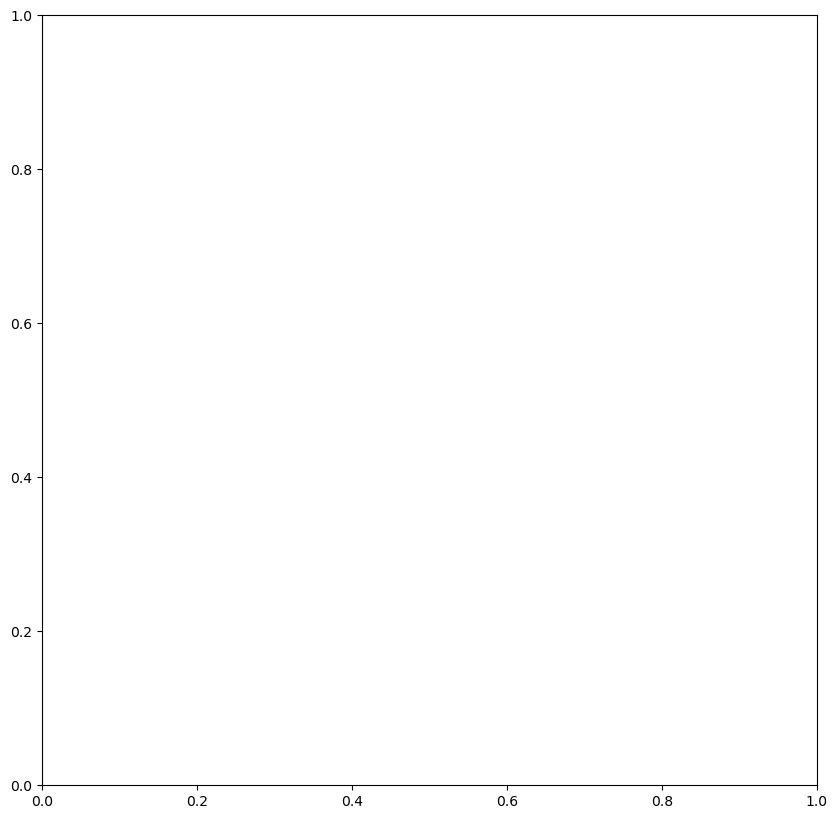

In [104]:
#Plotting time difference

ellipsoidn_dims = jnp.array(dims)

ellipsoidn_score_tmean = jnp.array([time.average for time in time_score])
ellipsoidn_score_tstd = jnp.array([time.stdev for time in time_bridge])

ellipsoidn_bridge_tmean = jnp.array([time.average for time in time_bridge])
ellipsoidn_bridge_tstd = jnp.array([time.stdev for time in time_bridge])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(sn_dims, ellipsoidn_score_tmean, color='orange')
ax.plot(sn_dims, ellipsoidn_bridge_tmean, color='blue')
ax.set_xlabel(f'$N$')
ax.set_ylabel(f'$Time$')
ax.grid(True)
ax.fill_between(
    rn_dims,
    jnp.maximum(ellipsoidn_score_tmean - 1.96 * ellipsoidn_score_tstd, jnp.zeros_like(ellipsoidn_score_tmean)),
    jnp.maximum(ellipsoidn_score_tmean + 1.96 * ellipsoidn_score_tstd, jnp.zeros_like(ellipsoidn_score_tmean)),
    color="tab:red",
    alpha=0.5,
)
ax.fill_between(
    dims,
    jnp.maximum(ellipsoidn_bridge_tmean - 1.96 * ellipsoidn_bridge_tstd, jnp.zeros_like(ellipsoidn_bridge_tmean)),
    jnp.maximum(ellipsoidn_bridge_tmean + 1.96 * ellipsoidn_bridge_tstd, jnp.zeros_like(ellipsoidn_bridge_tmean)),
    color="tab:pink",
    alpha=0.5,
)
ax.grid(True)



# Cylinder

## Defining Manifold and Loading Score

In [139]:
M = Cylinder(params=(1.,jnp.array([0.,0.,1.]),jnp.pi/2.))
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)

using M.Exp for Logarithm


In [162]:
file_path = 'scores/Cylinder/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

#file_path_s2 = 'scores/Cylinder/s2/'
#state_s2 = model_loader.load_model(file_path_s2)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log_ad(x,y,t):
    
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

def ggrady_log_score(x,y,t):
    
    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[1],y[1],t)))
    
    return jnp.dot(M.invJF((M.F(y), y[1])), ggrad)

if s2_approximation:
    ggrady_log = ggrady_log_score
else:
    ggrady_log = ggrady_log_ad

## Loading Loss

In [163]:
loss = jnp.load('scores/Cylinder/s1_' + loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


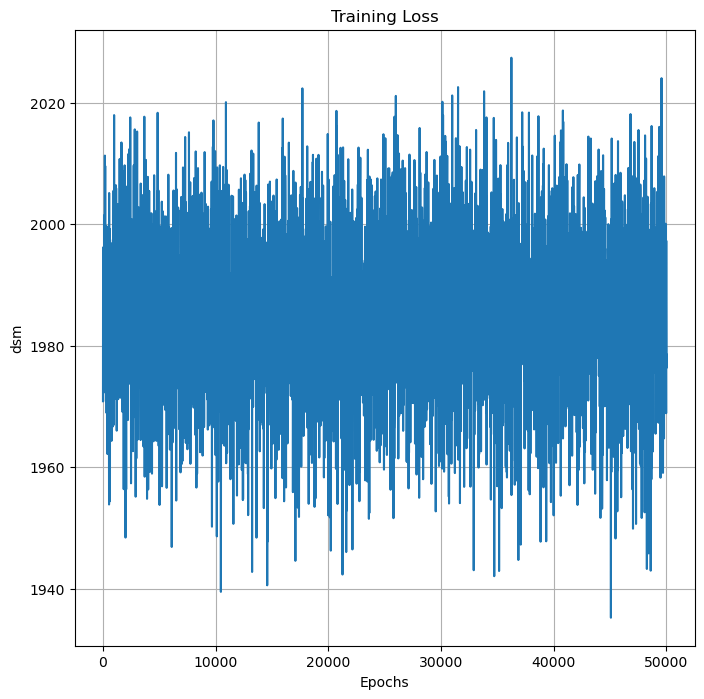

In [164]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [165]:
xs = pd.read_csv('Data/Cylinder/xs.csv', header=None)
charts = pd.read_csv('Data/Cylinder/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [150]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.01, max_iter=1000)

In [146]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.135751e+01 | T: ((Array([-0.05872891, -0.04805093], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.024655e+01 | T: ((Array([-0.04898103, -0.03818516], dtype=float32), Array(0.2199283, dtype=float32)), Array([0., 0.], dtype=float32))
Final 1 | T: 1.024655e+01 | T: (Array([-0.04898103, -0.03818516], dtype=float32), Array(0.2199283, dtype=float32))
Step 0 | T: 1.135751e+01 | T: ((Array([-0.05872891, -0.04805093], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.024655e+01 | T: ((Array([-0.04898103, -0.03818516], dtype=float32), Array(0.2199283, dtype=float32)), Array([0., 0.], dtype=float32))
Step 2 | T: 9.303733e+00 | T: ((Array([-0.03971378, -0.02855165], dtype=float32), Array(0.22974525, dtype=float32)), Array([0., 0.], dtype=float32))
Step 3 | T: 8.501101e+00 | T: ((Array([-0.03118584, -0.01925099], dtype=float32), Array(0.23941708, dtype=float32)), Array([0., 0.], dtype=flo

Step 53 | T: 2.570148e+00 | T: ((Array([-0.02293508,  0.0101991 ], dtype=float32), Array(0.48120186, dtype=float32)), Array([0., 0.], dtype=float32))
Step 54 | T: 2.559716e+00 | T: ((Array([-0.02304988,  0.01049353], dtype=float32), Array(0.48325464, dtype=float32)), Array([0., 0.], dtype=float32))
Step 55 | T: 2.549699e+00 | T: ((Array([-0.02321837,  0.01082371], dtype=float32), Array(0.4852669, dtype=float32)), Array([0., 0.], dtype=float32))
Step 56 | T: 2.540071e+00 | T: ((Array([-0.02343213,  0.01118275], dtype=float32), Array(0.48724052, dtype=float32)), Array([0., 0.], dtype=float32))
Step 57 | T: 2.530809e+00 | T: ((Array([-0.0236826 ,  0.01156408], dtype=float32), Array(0.48917726, dtype=float32)), Array([0., 0.], dtype=float32))
Step 58 | T: 2.521894e+00 | T: ((Array([-0.02396121,  0.01196148], dtype=float32), Array(0.4910788, dtype=float32)), Array([0., 0.], dtype=float32))
Step 59 | T: 2.513302e+00 | T: ((Array([-0.0242596 ,  0.01236912], dtype=float32), Array(0.4929467, dt

In [151]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -0.0270 0.0392 )
T = 0.5400


In [152]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.0000 0.0000 )
T = 0.5505


In [153]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_sm[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.0475 
 -T error = 0.0105


In [154]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_sm[1][-1])/2:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1])/2:.5f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.02377 
 -T error = 0.0400
Bridge Diffusion mean: 
 -mean error = 0.00000 
 -T error = 0.0505


In [ ]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# Torus

## Defining Manifold and Loading Score

In [155]:
M = Torus()
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)
x0[1]

using M.Exp for Logarithm


Array([0., 0.], dtype=float32)

In [169]:
file_path = 'scores/Torus/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

file_path_s2 = 'scores/Torus/s2/'
state_s2 = model_loader.load_model(file_path_s2)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log_ad(x,y,t):
    
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

def ggrady_log_score(x,y,t):
    
    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[1],y[1],t)))
    
    return jnp.dot(M.invJF((M.F(y), y[1])), ggrad)

if s2_approximation:
    ggrady_log = ggrady_log_score
else:
    ggrady_log = ggrady_log_ad

FileNotFoundError: [Errno 2] No such file or directory: 'scores/Torus/s1_dsm/tree.pkl'

## Loading Loss

In [120]:
loss = jnp.load('scores/Torus/' + loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


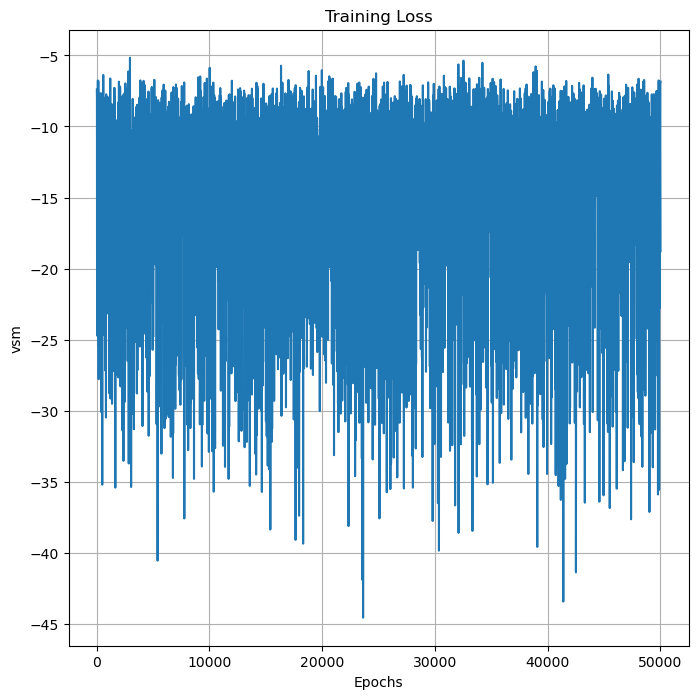

In [93]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [94]:
xs = pd.read_csv('Data/Torus/xs.csv', header=None)
charts = pd.read_csv('Data/Torus/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [95]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), 
                                     step_size=0.1, max_iter=100)

In [96]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.453338e+01 | T: ((Array([-0.18177876, -0.00945805], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.265824e+01 | T: ((Array([-0.17184542, -0.01500721], dtype=float32), Array(0.219913, dtype=float32)), Array([0., 0.], dtype=float32))
Final 1 | T: 1.265824e+01 | T: (Array([-0.17184542, -0.01500721], dtype=float32), Array(0.219913, dtype=float32))
Step 0 | T: 1.453340e+01 | T: ((Array([-0.18177876, -0.00945805], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.265763e+01 | T: ((Array([-0.17184542, -0.015028  ], dtype=float32), Array(0.21991298, dtype=float32)), Array([0., 0.], dtype=float32))
Step 2 | T: 1.108802e+01 | T: ((Array([-0.16201945, -0.02065388], dtype=float32), Array(0.22969085, dtype=float32)), Array([0., 0.], dtype=float32))
Step 3 | T: 9.771928e+00 | T: ((Array([-0.15233807, -0.02273714], dtype=float32), Array(0.2392931, dtype=float32)), Array([0., 0.], dtype=float

Step 53 | T: 1.572088e+00 | T: ((Array([ 0.01941139, -0.01369051], dtype=float32), Array(0.46345207, dtype=float32)), Array([0., 0.], dtype=float32))
Step 54 | T: 1.560797e+00 | T: ((Array([ 0.01918913, -0.0135701 ], dtype=float32), Array(0.4653291, dtype=float32)), Array([0., 0.], dtype=float32))
Step 55 | T: 1.549640e+00 | T: ((Array([ 0.01893759, -0.01354981], dtype=float32), Array(0.46717286, dtype=float32)), Array([0., 0.], dtype=float32))
Step 56 | T: 1.538876e+00 | T: ((Array([ 0.01866033, -0.0136252 ], dtype=float32), Array(0.4689849, dtype=float32)), Array([0., 0.], dtype=float32))
Step 57 | T: 1.528749e+00 | T: ((Array([ 0.01836071, -0.01377137], dtype=float32), Array(0.4707667, dtype=float32)), Array([0., 0.], dtype=float32))
Step 58 | T: 1.518717e+00 | T: ((Array([ 0.01804182, -0.01395113], dtype=float32), Array(0.47251964, dtype=float32)), Array([0., 0.], dtype=float32))
Step 59 | T: 1.508847e+00 | T: ((Array([ 0.01770659, -0.01414127], dtype=float32), Array(0.47424498, dt

In [97]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0266 -0.0372 )
T = 0.5016


In [98]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.0000 0.0000 )
T = 0.5290


In [99]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_sm[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.0457 
 -T error = 0.0274


In [101]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_sm[1][-1])/2:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1])/2:.5f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.02286 
 -T error = 0.0016
Bridge Diffusion mean: 
 -mean error = 0.00000 
 -T error = 0.0290


In [ ]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# Hyperbolic Parabolid

## Defining Manifold and Loading Score

In [170]:
M = HypParaboloid()
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)

using M.Exp for Logarithm


In [193]:
file_path = 'scores/HypParaboloid/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

#file_path_s2 = 'scores/HypParaboloid/s2/'
#state_s2 = model_loader.load_model(file_path_s2)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log_ad(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

def ggrady_log_score(x,y,t):
    
    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[0],y[0],t)))
    
    return ggrad

if s2_approximation:
    ggrady_log = ggrady_log_score
else:
    ggrady_log = ggrady_log_ad

In [194]:
grady_log(x0,x0,0.5)

ValueError: 'mlp_s1/~model/linear_2/w' with retrieved shape (100, 100) does not match shape=[100, 200] dtype=dtype('float32')

## Loading Loss

In [179]:
loss = jnp.load('scores/HypParaboloid/s1_' + loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


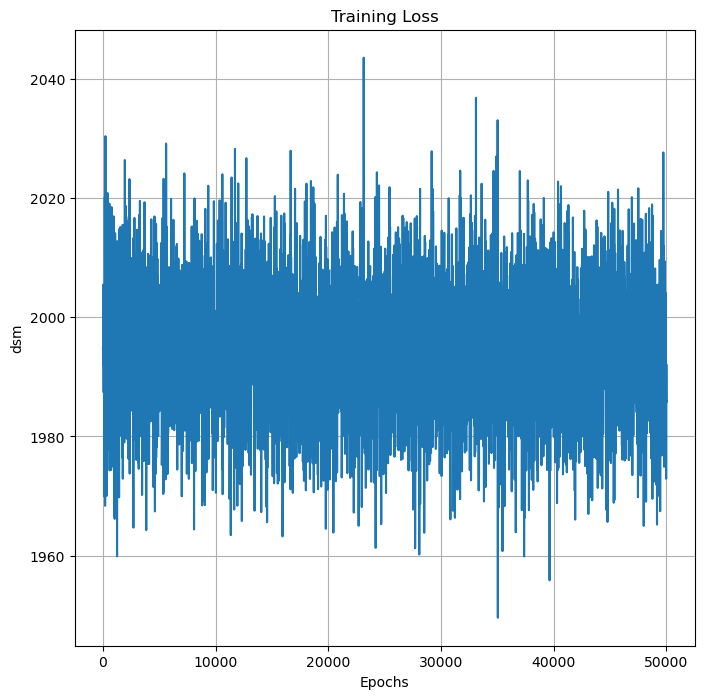

In [180]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [188]:
xs = pd.read_csv('Data/HypParaboloid/xs.csv', header=None)
charts = pd.read_csv('Data/HypParaboloid/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [185]:
grady_log((x0[0],jnp.zeros(3)),(x0[0],jnp.zeros(3)),0.5)

ValueError: 'mlp_s1/~model/linear_2/w' with retrieved shape (100, 100) does not match shape=[100, 200] dtype=dtype('float32')

In [186]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.3]), 
                                     step_size=0.001, max_iter=1000)

ValueError: 'mlp_s1/~model/linear_2/w' with retrieved shape (100, 100) does not match shape=[100, 200] dtype=dtype('float32')

In [187]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log((mu_sm[0][-1], mu_sm[1][-1]), (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

ValueError: 'mlp_s1/~model/linear_2/w' with retrieved shape (100, 100) does not match shape=[100, 200] dtype=dtype('float32')

In [109]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

ValueError: The user-provided objective function must return a scalar value.

In [175]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[0][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.2148 -0.7179 )
T = 0.7120


In [173]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:


NameError: name 'mu_bridgechart' is not defined

In [112]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_sm[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.0000 
 -T error = 0.4710


In [167]:
M.F((mu_sm[0][-1], mu_sm[1][-1]))

Array([  1.0282233,  -3.7317057, -12.868383 ], dtype=float32)

In [166]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 3.8708 
 -T error = 0.2000


NameError: name 'mu_bridgechart' is not defined

In [253]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

426 ms ± 7.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# SPDN

## Defining Manifold and Loading Score

In [1244]:
N = 2

In [1245]:
M = SPDN(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([10.]*(N*(N+1)//2))

using M.Exp for Logarithm


In [1246]:
file_path = 'scores/SPDN'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)
file_path_s2 = 'scores/SPDN'+str(N)+'/s2/'
state_s2 = model_loader.load_model(file_path_s2)
from jax import jacfwd
if N*N<10:
    layers = [50,100,100,50]
elif N*N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    #ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[0],y[0],t)))
    
    return ggrad

## Loading Loss

In [1247]:
loss = jnp.load('scores/SPDN'+str(N)+'/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  100


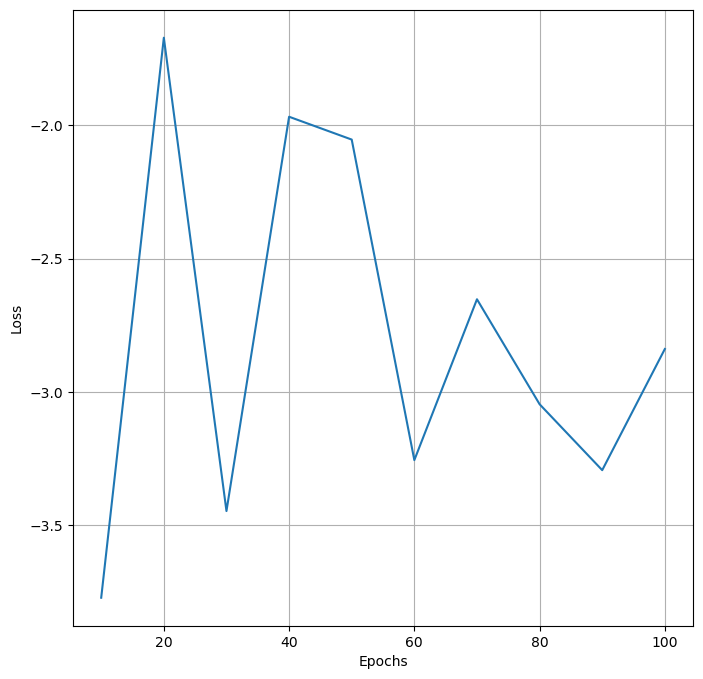

In [1248]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [1249]:
xs = pd.read_csv('Data/SPDN'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/SPDN'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values)[~jnp.isnan(xs.values).any(axis=1)], jnp.array(charts.values)[~jnp.isnan(xs.values).any(axis=1)])

In [1250]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.3]), 
                                     step_size=0.1, max_iter=1000)

/home/fmry/anaconda3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


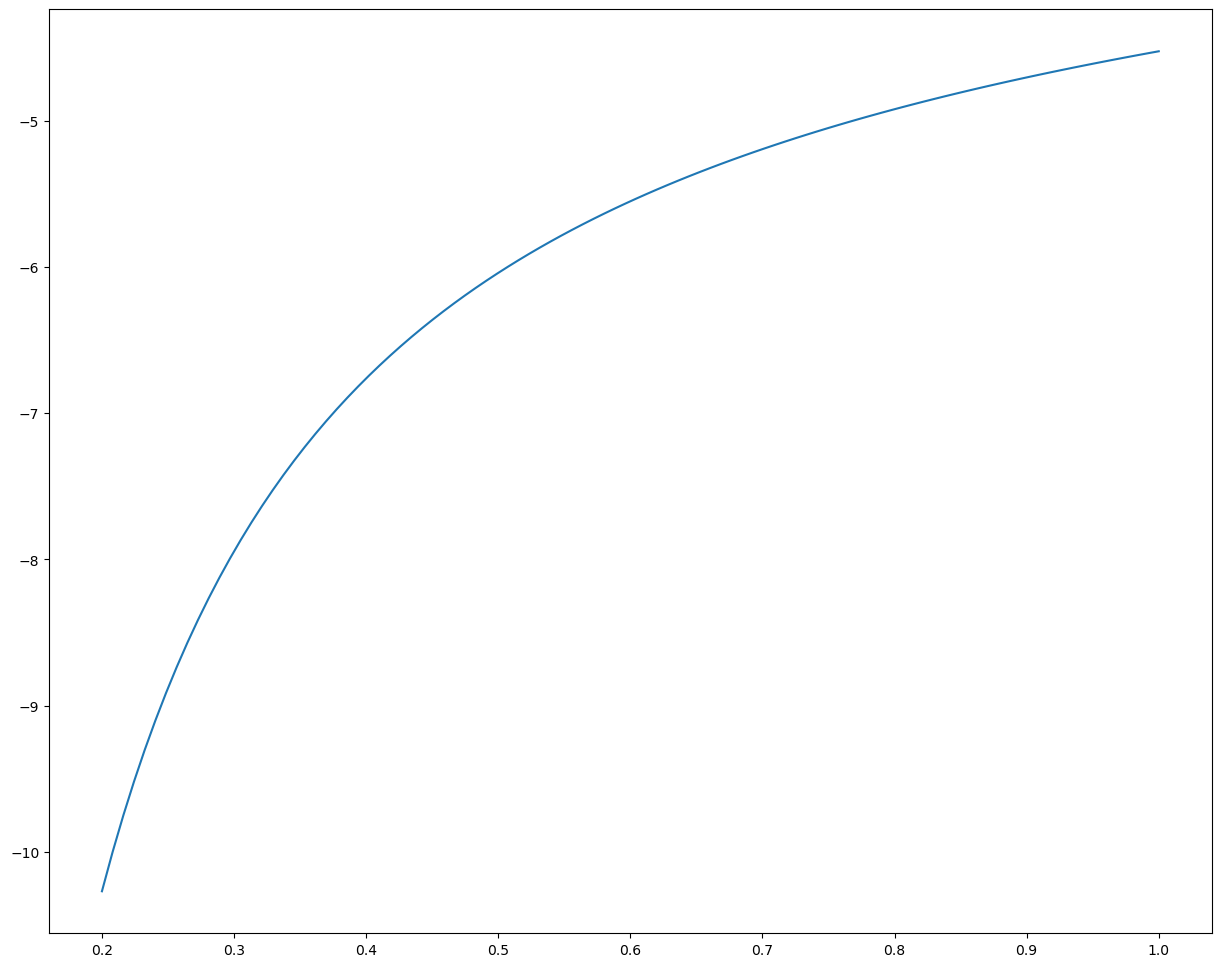

In [1251]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

In [40]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

ValueError: The user-provided objective function must return a scalar value.

In [1252]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 3.6371 
 -T error = 0.3990


In [140]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

1min 7s ± 2.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Sym

## Defining Manifold and Loading Score

In [251]:
N = 5

In [252]:
M = Sym(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([10.]*(N*(N+1)//2))

using M.Exp for Logarithm


In [253]:
file_path = 'scores/Sym'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)
from jax import jacfwd
if N*N<10:
    layers = [50,100,100,50]
elif N*N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    #ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[0],y[0],t)))
    
    return ggrad

## Loading Loss

In [254]:
loss = jnp.load('scores/Sym'+str(N)+'/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


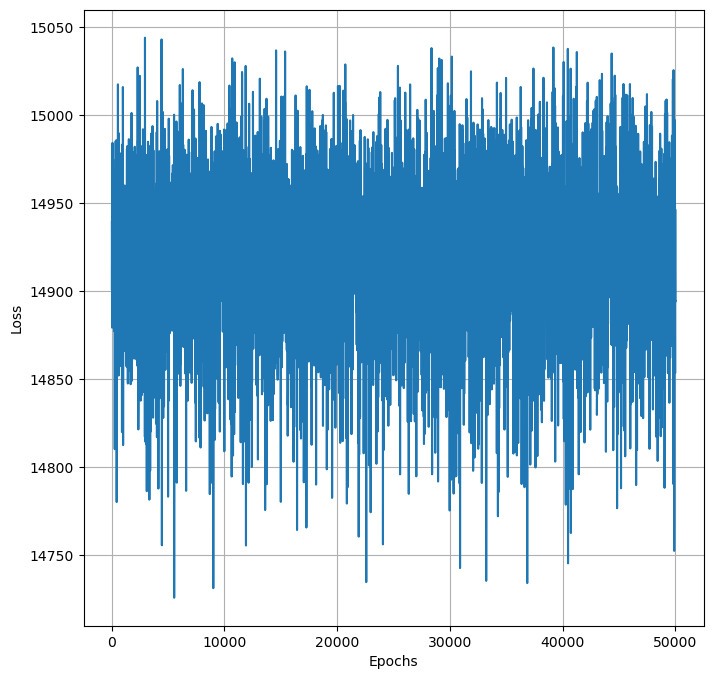

In [255]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [256]:
xs = pd.read_csv('Data/Sym'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/Sym'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values)[~jnp.isnan(xs.values).any(axis=1)], jnp.array(charts.values)[~jnp.isnan(xs.values).any(axis=1)])

In [257]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.3]), 
                                     step_size=0.001, max_iter=1000)

ValueError: Incompatible shapes for broadcasting: shapes=[(5, 5), (25,)]

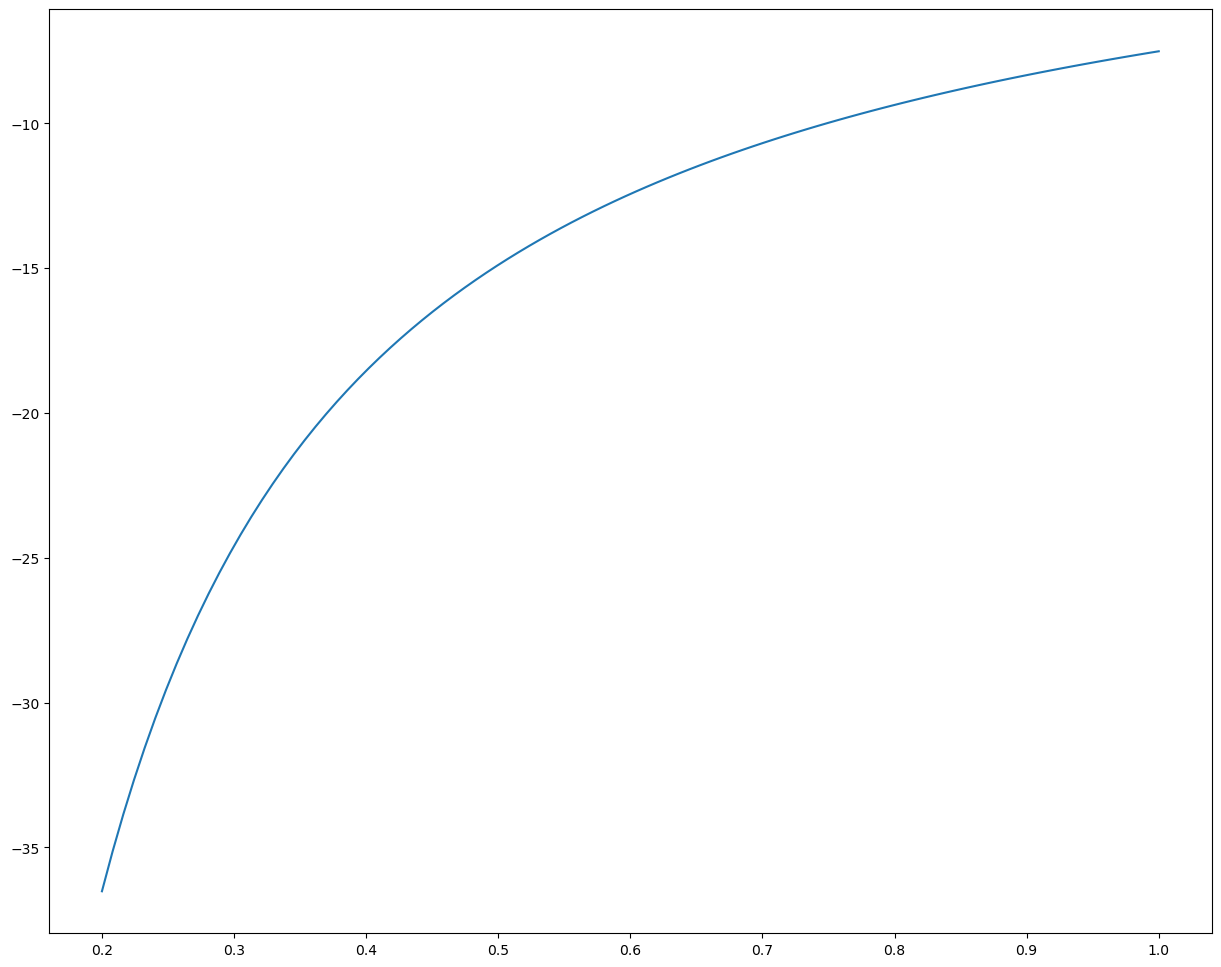

In [229]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

In [40]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

ValueError: The user-provided objective function must return a scalar value.

In [221]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.0089 
 -T error = 0.4960


In [140]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

1min 7s ± 2.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Landmarks

## Defining Manifold and Loading Score

In [1149]:
N = 2

In [1150]:
M = Landmarks(N=N,m=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.linspace(5.0,-5.0,M.N))).T.flatten())
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.zeros(M.N))).T.flatten())
if N >=10:
    with open('../../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt', 'r') as the_file:
        all_data = [line.strip() for line in the_file.readlines()]

        x1 = jnp.array([float(x) for x in all_data[0].split()[2:]])
        x2 = jnp.array([float(x) for x in all_data[1].split()[2:]])

        x0 = M.coords(jnp.vstack((x1[::len(x1)//N],x2[::len(x2)//N])).T.flatten())

using M.Exp for Logarithm


In [1151]:
x0[0].reshape(-1,2)

Array([[-5.,  0.],
       [ 5.,  0.]], dtype=float32)

In [1152]:
file_path = 'scores/Landmarks'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

file_path_s2 = 'scores/Landmarks'+str(N)+'/s2/'
state_s2 = model_loader.load_model(file_path_s2)
if 2*N<10:
    layers = [50,100,100,50]
elif 2*N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    #ggrad = s2.apply(state_s2.params,rng_key, jnp.hstack((x[0], y[0], t)))
    
    return ggrad

## Loading Loss

In [1153]:
loss = jnp.load('scores/Landmarks'+str(N)+'/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  90


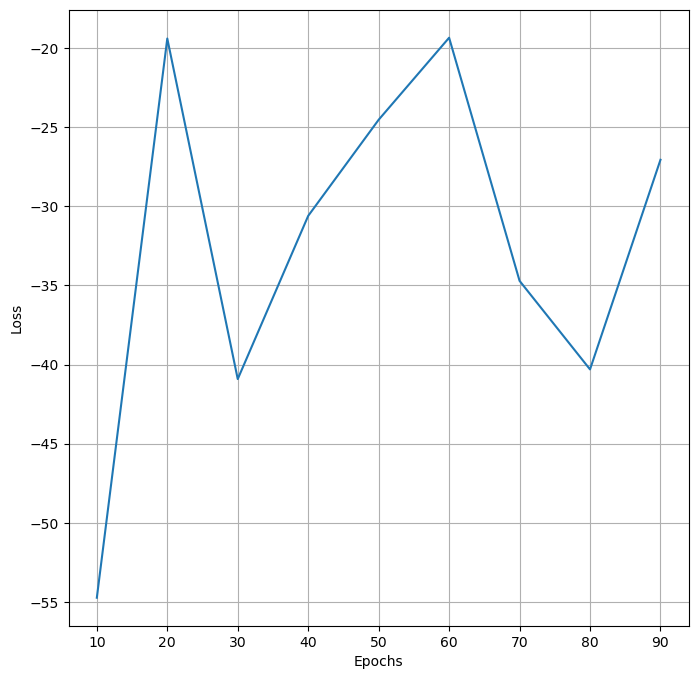

In [1154]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

In [1155]:
loss = jnp.load('scores/Landmarks'+str(N)+'/s2/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  210


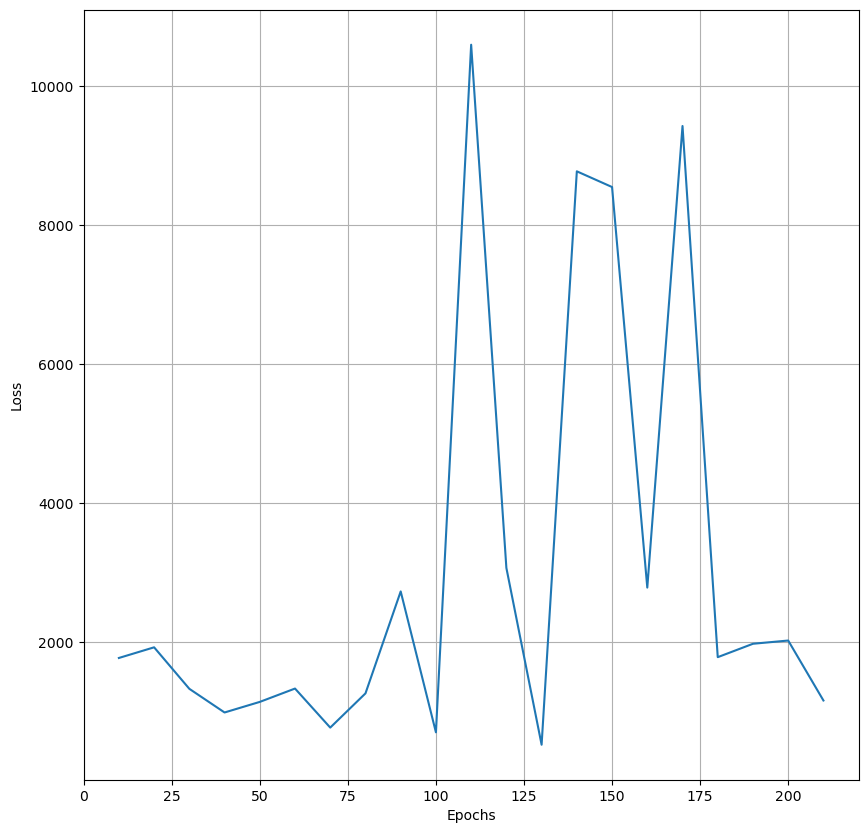

In [1156]:
fig = plt.figure(figsize=(10,10))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

In [1157]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

TypeError: sub got incompatible shapes for broadcasting: (4,), (3,).

## Estimating Diffusion t-Mean

In [1158]:
xs = pd.read_csv('Data/Landmarks'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/Landmarks'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [1159]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                    step_size=0.01, max_iter=100)

In [323]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

ValueError: The user-provided objective function must return a scalar value.

In [1160]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[0][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -5.0323 -0.0567 4.9516 0.1371 )
T = 0.5158


In [1161]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.1594 
 -T error = 0.0158


In [334]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

10.1 s ± 2.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
